# Table of contents

[Fig 2](#fig2) <br/>
[Fig 3](#fig3) <br/>
[Fig 4](#fig4) <br/>
[Fig 5](#fig5) <br/>

In [1]:
# # # recreate the exact environment

# conda create -y -n morphine_cfos_paper_jupyter python=3.9
# conda activate morphine_cfos_paper_jupyter
# pip install notebook==6.4.10
# pip install bg-atlasapi==1.0.2
# pip install brainrender==2.1.9
# pip install statannotations==0.6.0
# pip install seaborn==0.12.2
# pip install plotly==5.24.1
# pip install jupyterlab==3.3.3
# pip install traitlets==5.9.0
# pip install --upgrade pandas==1.4.2
# pip install --upgrade numpy==1.24
# pip install --upgrade matplotlib==3.5.1
# pip install kaleido==0.2.1
# # pip install --upgrade importlib-metadata==6.8.0  # if there's a metadata related error

In [2]:
import os
import json
from glob import glob

import brainrender
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import tifffile
from IPython.display import Image, display
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
from brainrender import Scene
from brainrender._colors import map_color
from datetime import datetime
from scipy import stats
from skimage.filters import gaussian
from skimage.segmentation import find_boundaries
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings('ignore')

In [3]:
start_time = datetime.now()  # to measure how long the whole notebook takes to run

In [4]:
# constants (for visualizations)
significant_only = True
significance_threshold = 0.05
volume_mm3_threshold = 0.25
exclude_fiber_tracts = True
show_top_structures = 20
min_cells = 25

In [5]:
# This can take really long the first time - to download the atlas
atlas = BrainGlobeAtlas("allen_mouse_10um")
tree = atlas.structures.tree
root_node_id = tree.root
get_acronym = lambda x: x.split(">")[-1]

# "csv_files" archive needs to be downloaded and unpacked (see README.md file for instructions)
region_volumes = json.load(open("./csv_files/region_volumes_10um.json", "r"))

def structure_from_acronym(acronym):
    return ">".join(atlas.get_structure_ancestors(acronym) + [acronym])

In [6]:
def get_all_structures_cell_density(df_path):
    print("reading DF:", df_path)
    raw_df = pd.read_csv(df_path, sep="\t")
    treatment = raw_df['treatment'].unique()[0]
    sex = raw_df['sex'].unique()[0]
    time_point = raw_df['time_point'].unique()[0]
    print(f"treatment: {treatment}, sex: {sex}, time: {time_point}")

    # remove entries without atlas structure
    nonzero_mask = raw_df['atlas_structure_number'] != 0
    filtered_df = raw_df[nonzero_mask]

    # merge records from the same structure into count per structure
    count_per_value = filtered_df.groupby('atlas_structure_acronym').size().reset_index(name='count')
    count_per_value = count_per_value.sort_values(by='count', ascending=False)

    df = atlas.lookup_df
    all_levels_list = []

    for depth_level in range(10):  # depth of the atlas tree is 9
        descendants_at_depth = extract_descendants(tree, root_node_id, depth_level)
        descendants_at_depth = [df.loc[df['id'] == id, 'acronym'].values[0] for id in descendants_at_depth]
        ancestor_counts = {structure: {'cell_count': 0, 'density': 0, 'volume': 0} for structure in descendants_at_depth}

        for index, row in count_per_value.iterrows():
            atlas_structure_acronym = row['atlas_structure_acronym']
            count = row['count']
            structure_ancestors = atlas.get_structure_ancestors(atlas_structure_acronym)
            structure_ancestors.append(atlas_structure_acronym)
            for major_structure in descendants_at_depth:
                if major_structure in structure_ancestors:
                    ancestor_counts[major_structure]['cell_count'] += count

        voxel_volume = atlas.resolution[0] / 1000 * atlas.resolution[1] / 1000 * atlas.resolution[2] / 1000  # cubic mm
        for structure in ancestor_counts.keys():
            if structure in region_volumes:
                volume = region_volumes[structure]
            else:
                mask = atlas.get_structure_mask(structure)
                voxels = mask[mask > 0].shape[0]
                volume = voxels * voxel_volume
                region_volumes[structure] = volume
            ancestor_counts[structure]['volume'] = volume
            ancestor_counts[structure]['density'] = ancestor_counts[structure]['cell_count'] / volume

        ancestor_data_list = [{'Structure': ">".join([*atlas.get_structure_ancestors(ancestor), ancestor]), **counts} for ancestor, counts in ancestor_counts.items()]
        result_df = pd.DataFrame(ancestor_data_list)
        all_levels_list.append(result_df)

    all_levels_df = pd.concat(all_levels_list, ignore_index=True)
    all_levels_df.sort_values(by='Structure', inplace=True)
    all_levels_df.to_csv(df_path.replace(".csv", "all_structures_density.csv"))
    return treatment, sex, time_point, all_levels_df, raw_df


def extract_descendants(tree, node_id, depth, current_depth=0):
    descendants = []

    if current_depth == depth:
        return [node_id]

    children = tree.children(node_id)
    for child in children:
        descendants.extend(extract_descendants(tree, child.identifier, depth, current_depth + 1))

    return descendants

def get_major_parent(acronym):
    parents = atlas.get_structure_ancestors(acronym)
    for structure in large_structures:
        if structure in parents:
            return structure
    return "Other"

In [7]:
# filtering functions
def is_large_enough(acronym):
    volume = region_volumes[acronym]
    return volume >= volume_mm3_threshold

def is_grey(acronym):
    parents = atlas.get_structure_ancestors(acronym)
    return "grey" in parents

def both_above_threshold(structure, df1, df2):
    return (
        df1[df1['Structure'] == structure]['cell_count'].values[0] >= min_cells 
        and df2[df2['Structure'] == structure]['cell_count'].values[0] >= min_cells 
    )

In [8]:
# calculate p-values between two datasets
def get_p_value(ds1, ds2):

    t_stat, p_val = stats.ttest_ind(ds1, ds2)
    
    return p_val

In [9]:
def exclude_parents(acronyms):
    """
    Goes through the list of acronyms, and removes structures that are parents of other structures in this list.
    For example, if list contains both ACB and STR (STR being parent of ACB), this function will exclude STR
    """
    acronyms_filtered = acronyms[:]
    for acronym in acronyms:
        parents = atlas.get_structure_ancestors(acronym)
        for parent in parents:
            if parent in acronyms_filtered:
                acronyms_filtered.remove(parent)
    return acronyms_filtered

In [10]:
# "csv_files" archive needs to be downloaded and unpacked (see README.md file for instructions)
brain_dfs_02CL89 = sorted(glob(os.path.join(os.getcwd(), "csv_files", "02CL89", "*with_metadata.csv")))
brain_dfs_03CL12 = sorted(glob(os.path.join(os.getcwd(), "csv_files", "03CL12", "*with_metadata.csv")))
brain_dfs_03CL47 = sorted(glob(os.path.join(os.getcwd(), "csv_files", "03CL47", "*with_metadata.csv")))

all_dfs = []
all_dfs.extend(brain_dfs_02CL89)
all_dfs.extend(brain_dfs_03CL12)
all_dfs.extend(brain_dfs_03CL47)

raw_dfs = {}
density_dfs = {}
for df_path in all_dfs:
    density_dfs[df_path] = {}
    treatment, sex, time_point, density_df, raw_df = get_all_structures_cell_density(df_path)
    raw_dfs[df_path] = raw_df
    density_dfs[df_path]['treatment'] = treatment
    density_dfs[df_path]['sex'] = sex
    density_dfs[df_path]['time_point'] = time_point
    density_dfs[df_path]['df'] = density_df

    
morphine_dfs = []
saline_dfs = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict['df']
    treatment = df_path_dict['treatment']
    if treatment == "morphine":
        morphine_dfs.append(density_df)
    elif treatment == "saline":
        saline_dfs.append(density_df)

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs = pd.concat(morphine_dfs)
assert morphine_dfs.shape[0] == 840 * 15

saline_dfs = pd.concat(saline_dfs)
assert saline_dfs.shape[0] == 840 * 12

morphine_dfs.sort_values(by='Structure', inplace=True)
saline_dfs.sort_values(by='Structure', inplace=True)

morphine_dfs.reset_index(drop=True, inplace=True)
saline_dfs.reset_index(drop=True, inplace=True)

reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00833_df_for_dashboard_with_metadata.csv
treatment: morphine, sex: m, time: 1.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00834_df_for_dashboard_with_metadata.csv
treatment: morphine, sex: m, time: 4.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00835_df_for_dashboard_with_metadata.csv
treatment: saline, sex: m, time: 1.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00836_df_for_dashboard_with_metadata.csv
treatment: saline, sex: m, time: 4.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01093_df_for_dashboard_with_metadata.csv
treatment: morphine, sex: f, time: 4.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01103_df_for_dashboard_with_metadata.csv
treatment: saline, sex: f, time: 4.0
reading DF: /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01106_df_for_dashboard_with_metadata.csv
treatment

In [11]:
# male

morphine_dfs_male = []
saline_dfs_male = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict['df']
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'm':
        morphine_dfs_male.append(density_df)
    elif treatment == "saline" and sex == 'm':
        saline_dfs_male.append(density_df)
    else:
        pass

morphine_dfs_male = pd.concat(morphine_dfs_male)
assert morphine_dfs_male.shape[0] == 840 * 9

saline_dfs_male = pd.concat(saline_dfs_male)
assert saline_dfs_male.shape[0] == 840 * 6

morphine_dfs_male.sort_values(by='Structure', inplace=True)
saline_dfs_male.sort_values(by='Structure', inplace=True)

morphine_dfs_male.reset_index(drop=True, inplace=True)
saline_dfs_male.reset_index(drop=True, inplace=True)

morphine_male_average_density_df = morphine_dfs_male.groupby('Structure')['density'].mean().reset_index()
saline_male_average_density_df = saline_dfs_male.groupby('Structure')['density'].mean().reset_index()


# female

morphine_dfs_female = []
saline_dfs_female = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict['df']
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'f':
        morphine_dfs_female.append(density_df)
    elif treatment == "saline" and sex == 'f':
        saline_dfs_female.append(density_df)
    else:
        pass

morphine_dfs_female = pd.concat(morphine_dfs_female)
assert morphine_dfs_female.shape[0] == 840 * 6

saline_dfs_female = pd.concat(saline_dfs_female)
assert saline_dfs_female.shape[0] == 840 * 6

morphine_dfs_female.sort_values(by='Structure', inplace=True)
saline_dfs_female.sort_values(by='Structure', inplace=True)

morphine_dfs_female.reset_index(drop=True, inplace=True)
saline_dfs_female.reset_index(drop=True, inplace=True)

morphine_female_average_density_df = morphine_dfs_female.groupby('Structure')['density'].mean().reset_index()
saline_female_average_density_df = saline_dfs_female.groupby('Structure')['density'].mean().reset_index()


# 1h

morphine_dfs_1h = []
saline_dfs_1h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict['df']
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 1:
        morphine_dfs_1h.append(density_df)
    elif treatment == "saline" and time_point == 1:
        saline_dfs_1h.append(density_df)
    else:
        pass

morphine_dfs_1h = pd.concat(morphine_dfs_1h)
assert morphine_dfs_1h.shape[0] == 840 * 8

saline_dfs_1h = pd.concat(saline_dfs_1h)
assert saline_dfs_1h.shape[0] == 840 * 5

morphine_dfs_1h.sort_values(by='Structure', inplace=True)
saline_dfs_1h.sort_values(by='Structure', inplace=True)

morphine_dfs_1h.reset_index(drop=True, inplace=True)
saline_dfs_1h.reset_index(drop=True, inplace=True)

morphine_1h_average_density_df = morphine_dfs_1h.groupby('Structure')['density'].mean().reset_index()
saline_1h_average_density_df = saline_dfs_1h.groupby('Structure')['density'].mean().reset_index()


# 4h

morphine_dfs_4h = []
saline_dfs_4h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict['df']
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 4:
        morphine_dfs_4h.append(density_df)
    elif treatment == "saline" and time_point == 4:
        saline_dfs_4h.append(density_df)
    else:
        pass

morphine_dfs_4h = pd.concat(morphine_dfs_4h)
assert morphine_dfs_4h.shape[0] == 840 * 7

saline_dfs_4h = pd.concat(saline_dfs_4h)
assert saline_dfs_4h.shape[0] == 840 * 7

morphine_dfs_4h.sort_values(by='Structure', inplace=True)
saline_dfs_4h.sort_values(by='Structure', inplace=True)

morphine_dfs_4h.reset_index(drop=True, inplace=True)
saline_dfs_4h.reset_index(drop=True, inplace=True)

morphine_4h_average_density_df = morphine_dfs_4h.groupby('Structure')['density'].mean().reset_index()
saline_4h_average_density_df = saline_dfs_4h.groupby('Structure')['density'].mean().reset_index()


In [12]:
morphine_average_density_df = morphine_dfs.groupby('Structure')['density'].mean().reset_index()
saline_average_density_df = saline_dfs.groupby('Structure')['density'].mean().reset_index()
morphine_average_density_df['acronym'] = list(map(get_acronym, morphine_average_density_df['Structure'].to_list()))
saline_average_density_df['acronym'] = list(map(get_acronym, saline_average_density_df['Structure'].to_list()))
morphine_1h_average_density_df['acronym'] = list(map(get_acronym, morphine_1h_average_density_df['Structure'].to_list()))
morphine_4h_average_density_df['acronym'] = list(map(get_acronym, morphine_4h_average_density_df['Structure'].to_list()))
morphine_male_average_density_df['acronym'] = list(map(get_acronym, morphine_male_average_density_df['Structure'].to_list()))
morphine_female_average_density_df['acronym'] = list(map(get_acronym, morphine_female_average_density_df['Structure'].to_list()))
saline_1h_average_density_df['acronym'] = list(map(get_acronym, saline_1h_average_density_df['Structure'].to_list()))
saline_4h_average_density_df['acronym'] = list(map(get_acronym, saline_4h_average_density_df['Structure'].to_list()))
saline_male_average_density_df['acronym'] = list(map(get_acronym, saline_male_average_density_df['Structure'].to_list()))
saline_female_average_density_df['acronym'] = list(map(get_acronym, saline_female_average_density_df['Structure'].to_list()))

# Figure 2 <a id="fig2"/>

## 2a

In [13]:
heatmap_img = np.zeros(atlas.reference.shape, dtype=np.uint16)
saline_brains = 0
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    treatment = df_path_dict['treatment']
    if treatment == "saline":
        print("Working on", df_path)
        # read dataframe
        df = raw_dfs[df_path]
        saline_brains += 1
        df = df[df['atlas_structure_number'] > 0]
        # extract transformed points (z_transformed_px etc)
        atlas_points = df[['z_transformed_px', 'y_transformed_px', 'x_transformed_px']].to_numpy()
        # brute force method: go through every point, add 1 at these coordinates
        failed_points = []
        ind = 0
        for point in atlas_points:
            try:
                heatmap_img[point[0], point[1], point[2]] += 1
            except IndexError:
                failed_points.append(point)
            ind += 1
print("Saline brains (should be 12)", saline_brains)
heatmap_img = heatmap_img.astype('float32') / saline_brains
# save the resulting 3d numpy array and tiff
print("filtering heatmap... (slow step)")
heatmap_img = gaussian(heatmap_img, sigma=4)

# generate brain boundaries
boundaries_image = find_boundaries(atlas.annotation, mode="inner").astype(
    np.int8, copy=False
)
print("generating max intensity projections...")
# generate heatmaps with 1 mm step
hm_sa = heatmap_img
hm_sa = hm_sa[20:,:,:]
hm_sa = hm_sa.reshape(13, 100, 800, 1140)  # based on shape of 10um atlas
hm_sa_maxip = np.max(hm_sa, axis=1)
## contrast limits 0.002 (both morphine and saline)



Working on /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00835_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00836_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01103_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01111_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01116_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01117_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01159_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01175_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01179_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bi

<Figure size 864x864 with 17 Axes>

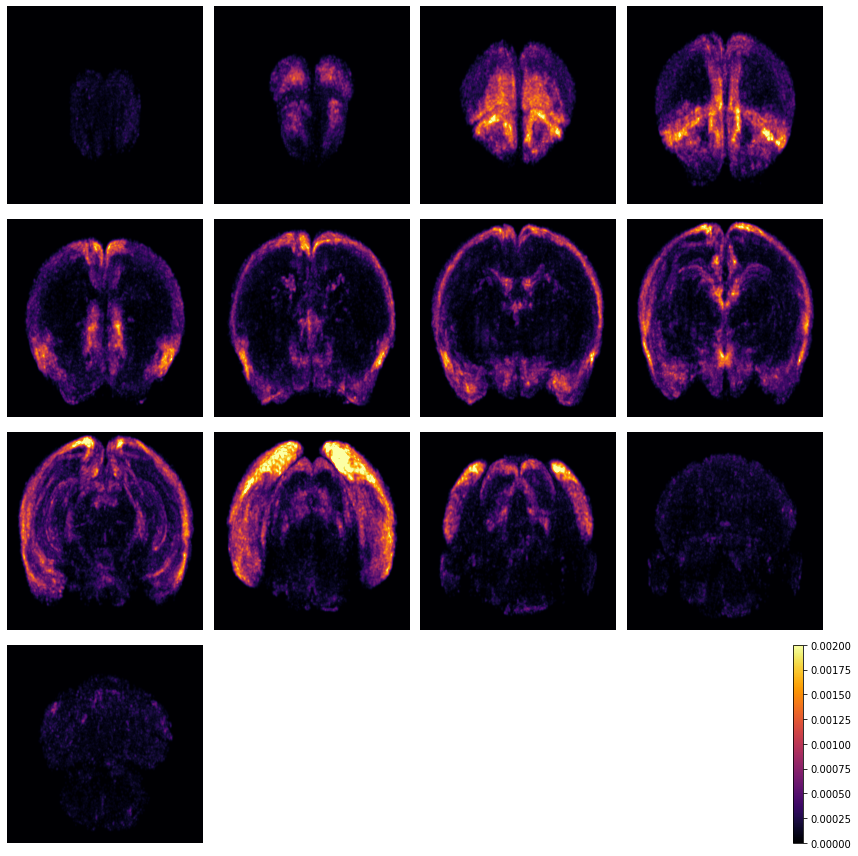

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Plot the 13 panels
for i in range(13):
    im = axes[i].imshow(hm_sa_maxip[i], cmap='inferno', aspect='auto', vmin=0, vmax=0.002)
    axes[i].axis('off')  # Turn off axis ticks and labels

# Remove axes for the remaining empty plots
for i in range(13, 16):
    axes[i].axis('off')

# Add a colorbar
fig.colorbar(im)


plt.tight_layout()
plt.show()

## 2b

In [15]:
heatmap_img = np.zeros(atlas.reference.shape, dtype=np.uint16)
morphine_brains = 0
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    treatment = df_path_dict['treatment']
    if treatment == "morphine":
        print("Working on", df_path)
        # read dataframe
        df = raw_dfs[df_path]
        morphine_brains += 1
        df = df[df['atlas_structure_number'] > 0]
        # extract transformed points (z_transformed_px etc)
        atlas_points = df[['z_transformed_px', 'y_transformed_px', 'x_transformed_px']].to_numpy()
        # brute force method: go through every point, add 1 at these coordinates
        failed_points = []
        ind = 0
        for point in atlas_points:
            try:
                heatmap_img[point[0], point[1], point[2]] += 1
            except IndexError:
                # print("Failed point", point)
                failed_points.append(point)
            ind += 1
print("Morphine brains (should be 15)", morphine_brains)
heatmap_img = heatmap_img.astype('float32') / morphine_brains
print("filtering heatmap... (slow step)")
heatmap_img = gaussian(heatmap_img, sigma=4)


# generate heatmaps with 1 mm step
print("generating max intensity projections...")
hm_mo = heatmap_img
hm_mo = hm_mo[20:, :, :]
hm_mo = hm_mo.reshape(13, 100, 800, 1140) # based on shape of 10um atlas
hm_mo_maxip = np.max(hm_mo, axis=1)
# contrast limits 0.002 (both morphine and saline)


Working on /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00833_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/02CL89/job_00834_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01093_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01106_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01109_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01115_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01151_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01161_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bio/notebooks/cebra/csv_files/03CL12/job_01174_df_for_dashboard_with_metadata.csv
Working on /h20/home/iana/bi

<Figure size 864x864 with 17 Axes>

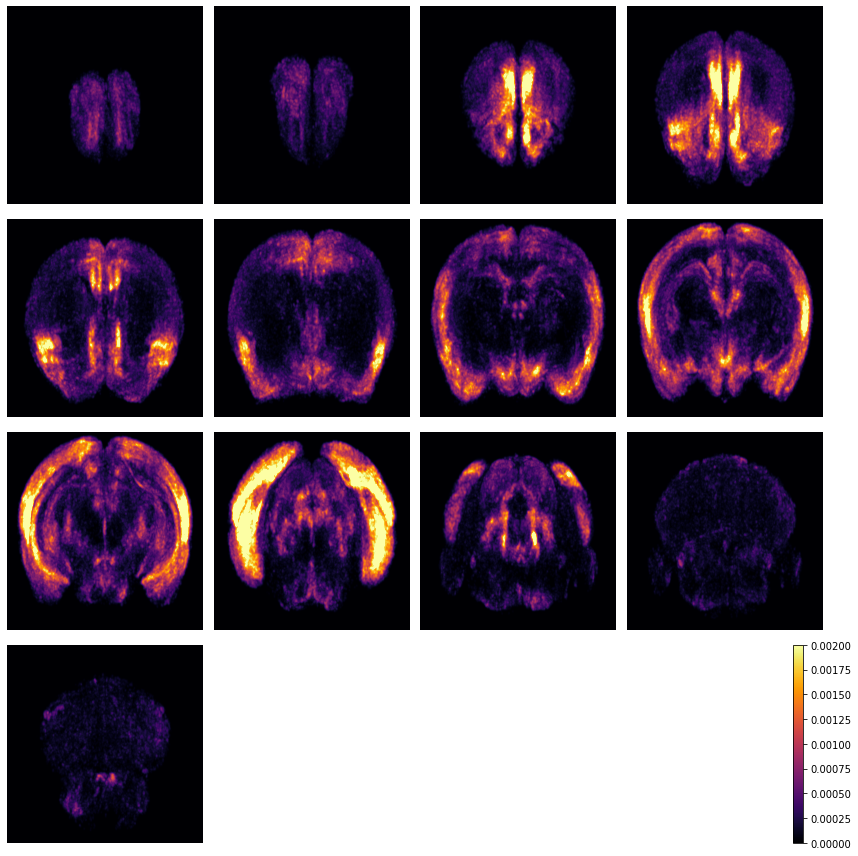

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.ravel()

# Plot the 13 panels
for i in range(13):
    im = axes[i].imshow(hm_mo_maxip[i], cmap='inferno', aspect='auto', vmin=0, vmax=0.002)  # Change cmap to your preferred colormap
    axes[i].axis('off')  # Turn off axis ticks and labels

# Remove axes for the remaining empty plots
for i in range(13, 16):
    axes[i].axis('off')

# Add a colorbar
fig.colorbar(im)


plt.tight_layout()
plt.show()

## 2c

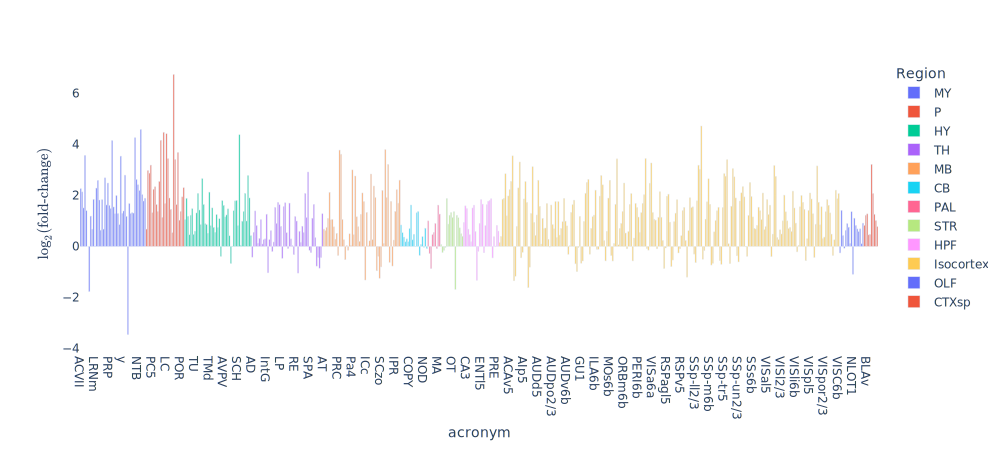

In [17]:
merged_df = pd.merge(morphine_average_density_df, saline_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df = merged_df[merged_df['density_saline'] > 0]

merged_df['density_ratio'] = merged_df['density_morphine'] / merged_df['density_saline']

density_ratio_df = merged_df[['Structure', 'density_ratio']]

# calculate p-values for every structure
p_values = []
significance = []
for structure in density_ratio_df['Structure'].to_list():
    morphine_dataset = morphine_dfs[morphine_dfs['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset) == 15
    saline_dataset = saline_dfs[saline_dfs['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset) == 12
    p_val = get_p_value(morphine_dataset, saline_dataset)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df['p_value'] = p_values
density_ratio_df['significant'] = significance

density_ratio_df['acronym'] = list(map(get_acronym, density_ratio_df['Structure'].to_list()))

large_structures = ['Isocortex', 'CTXsp', 'HPF', 'OLF', 'HY', 'MB', 'P', 'PAL', 'STR', 'TH', 'MY', 'CB']

density_ratio_df['acronym'] = list(map(get_acronym, density_ratio_df['Structure'].to_list()))
major_structure = list(map(get_major_parent, density_ratio_df['acronym'].to_list()))
density_ratio_df['major_structure'] = major_structure

tree = atlas.structures.tree
tree_leaves = [x.tag.split()[0] for x in tree.leaves()]

density_ratio_df_leaves = density_ratio_df[density_ratio_df['acronym'].isin(tree_leaves)]

grey_structures = list(map(is_grey, density_ratio_df_leaves['acronym'].to_list()))
density_ratio_df_leaves['is_grey'] = grey_structures
density_ratio_df_leaves = density_ratio_df_leaves[density_ratio_df_leaves['is_grey'] == True]

density_ratio_df_leaves['log_density_ratio'] = np.log2(density_ratio_df_leaves['density_ratio'].to_numpy())


fig = px.bar(density_ratio_df_leaves, x="acronym", y="log_density_ratio", color='major_structure', opacity=1)
fig.update_layout(
    {
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "autosize": False,
        "width":1000,
        "height":450,
        "yaxis_title": r"$\text{log}_2 \text{(fold-change)}$",
        "legend": {"title":"Region"}
    }
)
fig.show('svg')

## 2d

<Figure size 2016x288 with 2 Axes>

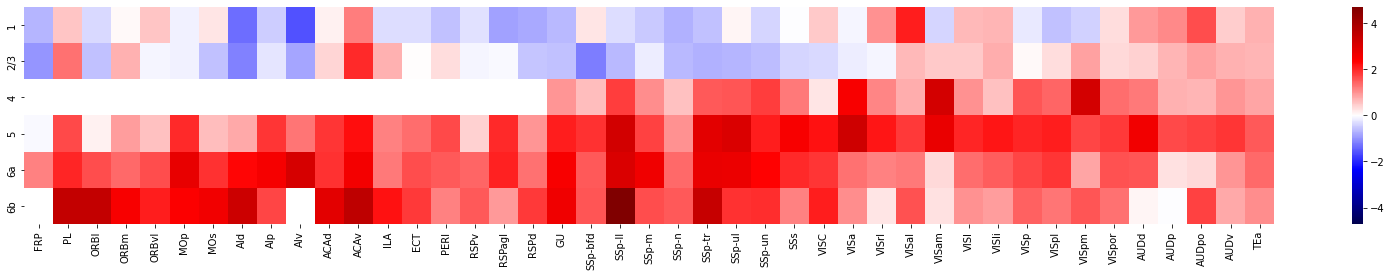

In [18]:
# all layers (1, 2/3, 4, 5, 6a, 6b)
six_layer_regions = ["RSPd", "GU", "SSp-bfd", "SSp-ll", "SSp-m", "SSp-n", "SSp-tr", "SSp-ul", "SSp-un", "SSs", "VISC", "VISa", "VISrl", "VISal", "VISam", "VISl", "VISli", "VISp", "VISpl", "VISpm", "VISpor", "AUDd", "AUDp", "AUDpo", "AUDv", "TEa"]

# no layer 4 (1, 2/3, 5, 6a, 6b)
five_layer_regions = ["FRP", "PL", "ORBl", "ORBm", "ORBvl", "MOp", "MOs", "AId", "AIp", "AIv", "ACAd", "ACAv", "ILA", "ECT", "PERI", "RSPv", "RSPagl"]


cortex_heatmap = []

for region in five_layer_regions:
    region_children = sorted(atlas.get_structure_descendants(region))
    assert len(region_children) == 5
    children_densities = []
    for child in region_children:
        try:
            children_densities.append(density_ratio_df_leaves[density_ratio_df_leaves['acronym'] == child]['log_density_ratio'].values[0])
        except IndexError:
            children_densities.append(float("nan"))
    children_densities.insert(2, float("nan"))
    cortex_heatmap.append(children_densities)

for region in six_layer_regions:
    region_children = sorted(atlas.get_structure_descendants(region))
    assert len(region_children) == 6
    children_densities = []
    for child in region_children:
        try:
            children_densities.append(density_ratio_df_leaves[density_ratio_df_leaves['acronym'] == child]['log_density_ratio'].values[0])
        except IndexError:
            children_densities.append(float("nan"))
    cortex_heatmap.append(children_densities)

cortex_heatmap = np.array(cortex_heatmap)

color_max = cortex_heatmap[~np.isnan(cortex_heatmap)].max()

dims = (28, 4)
cortical_layers = ['1', '2/3', '4', '5', '6a', '6b']
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(cortex_heatmap.transpose(), cmap="seismic", yticklabels=cortical_layers, xticklabels=five_layer_regions+six_layer_regions, vmin=-color_max, vmax=color_max)#, cbar_kws={'label': r"$\text{log}_2 \text{(fold-change)}$"})
plt.show()

# Figure 3 <a id="fig3"/>

In [19]:
def get_parent(acronym):
    return atlas.get_structure_ancestors(acronym)[-1]

def get_larger_parent(acronym):
    if is_large_enough(acronym):
        return acronym
    parent = get_parent(acronym)
    return get_larger_parent(parent)

tree_leaves = [x.tag.split()[0] for x in tree.leaves()]
tree_leaves.remove('CUL4,')  # bug in bg_atlasapi
grey_leaves = [x for x in tree_leaves if is_grey(x)]
large_leaves = [x for x in grey_leaves if is_large_enough(x)]
small_leaves = [x for x in grey_leaves if not is_large_enough(x)]

small_leaves_parents = [get_larger_parent(x) for x in small_leaves]
small_leaves_parents = list(set(small_leaves_parents))

large_enough_structures = large_leaves + small_leaves_parents
large_enough_structures_filtered = exclude_parents(large_enough_structures)

leaves_by_parent = dict.fromkeys(large_structures, [])
for acronym in large_enough_structures_filtered:
    parents = set(atlas.get_structure_ancestors(acronym))
    parent = parents.intersection(set(large_structures))
    parent = list(parent)[0]
    leaves_by_parent[parent] = leaves_by_parent[parent] + [acronym]

In [20]:
# split dfs into morphine and saline
morphine_dfs_male_1h = []
saline_dfs_male_1h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    sex = df_path_dict['sex']
    if treatment == "morphine" and time_point == 1 and sex == 'm':
        morphine_dfs_male_1h.append(density_df)
    elif treatment == "saline" and time_point == 1 and sex == 'm':
        saline_dfs_male_1h.append(density_df)

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_male_1h = pd.concat(morphine_dfs_male_1h)
assert morphine_dfs_male_1h.shape[0] == 840 * 5

saline_dfs_male_1h = pd.concat(saline_dfs_male_1h)
assert saline_dfs_male_1h.shape[0] == 840 * 3

morphine_dfs_male_1h.sort_values(by='Structure', inplace=True)
saline_dfs_male_1h.sort_values(by='Structure', inplace=True)

morphine_dfs_male_1h.reset_index(drop=True, inplace=True)
saline_dfs_male_1h.reset_index(drop=True, inplace=True)

# split dfs into morphine and saline
morphine_dfs_female_1h = []
saline_dfs_female_1h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    sex = df_path_dict['sex']
    if treatment == "morphine" and time_point == 1 and sex == 'f':
        morphine_dfs_female_1h.append(density_df)
    elif treatment == "saline" and time_point == 1 and sex == 'f':
        saline_dfs_female_1h.append(density_df)

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_female_1h = pd.concat(morphine_dfs_female_1h)
assert morphine_dfs_female_1h.shape[0] == 840 * 3

saline_dfs_female_1h = pd.concat(saline_dfs_female_1h)
assert saline_dfs_female_1h.shape[0] == 840 * 2

morphine_dfs_female_1h.sort_values(by='Structure', inplace=True)
saline_dfs_female_1h.sort_values(by='Structure', inplace=True)

morphine_dfs_female_1h.reset_index(drop=True, inplace=True)
saline_dfs_female_1h.reset_index(drop=True, inplace=True)

# split dfs into morphine and saline
morphine_dfs_male_4h = []
saline_dfs_male_4h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    sex = df_path_dict['sex']
    if treatment == "morphine" and time_point == 4 and sex == 'm':
        morphine_dfs_male_4h.append(density_df)
    elif treatment == "saline" and time_point == 4 and sex == 'm':
        saline_dfs_male_4h.append(density_df)

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_male_4h = pd.concat(morphine_dfs_male_4h)
assert morphine_dfs_male_4h.shape[0] == 840 * 4

saline_dfs_male_4h = pd.concat(saline_dfs_male_4h)
assert saline_dfs_male_4h.shape[0] == 840 * 3

morphine_dfs_male_4h.sort_values(by='Structure', inplace=True)
saline_dfs_male_4h.sort_values(by='Structure', inplace=True)

morphine_dfs_male_4h.reset_index(drop=True, inplace=True)
saline_dfs_male_4h.reset_index(drop=True, inplace=True)

morphine_dfs_male_4h.head(20)


# split dfs into morphine and saline
morphine_dfs_female_4h = []
saline_dfs_female_4h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    sex = df_path_dict['sex']
    if treatment == "morphine" and time_point == 4 and sex == 'f':
        morphine_dfs_female_4h.append(density_df)
    elif treatment == "saline" and time_point == 4 and sex == 'f':
        saline_dfs_female_4h.append(density_df)

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_female_4h = pd.concat(morphine_dfs_female_4h)
assert morphine_dfs_female_4h.shape[0] == 840 * 3

saline_dfs_female_4h = pd.concat(saline_dfs_female_4h)
assert saline_dfs_female_4h.shape[0] == 840 * 4

morphine_dfs_female_4h.sort_values(by='Structure', inplace=True)
saline_dfs_female_4h.sort_values(by='Structure', inplace=True)

morphine_dfs_female_4h.reset_index(drop=True, inplace=True)
saline_dfs_female_4h.reset_index(drop=True, inplace=True)


saline_1h_male_average_density_df = saline_dfs_male_1h.groupby('Structure')['density'].mean().reset_index()
saline_1h_female_average_density_df = saline_dfs_female_1h.groupby('Structure')['density'].mean().reset_index()
saline_4h_male_average_density_df = saline_dfs_male_4h.groupby('Structure')['density'].mean().reset_index()
saline_4h_female_average_density_df = saline_dfs_female_4h.groupby('Structure')['density'].mean().reset_index()

morphine_1h_male_average_density_df = morphine_dfs_male_1h.groupby('Structure')['density'].mean().reset_index()
morphine_1h_female_average_density_df = morphine_dfs_female_1h.groupby('Structure')['density'].mean().reset_index()
morphine_4h_male_average_density_df = morphine_dfs_male_4h.groupby('Structure')['density'].mean().reset_index()
morphine_4h_female_average_density_df = morphine_dfs_female_4h.groupby('Structure')['density'].mean().reset_index()


morphine_average_density_df = morphine_dfs.groupby('Structure')['density'].mean().reset_index()
saline_average_density_df = saline_dfs.groupby('Structure')['density'].mean().reset_index()
morphine_average_density_df['acronym'] = list(map(get_acronym, morphine_average_density_df['Structure'].to_list()))
saline_average_density_df['acronym'] = list(map(get_acronym, saline_average_density_df['Structure'].to_list()))
morphine_1h_average_density_df['acronym'] = list(map(get_acronym, morphine_1h_average_density_df['Structure'].to_list()))
morphine_4h_average_density_df['acronym'] = list(map(get_acronym, morphine_4h_average_density_df['Structure'].to_list()))
morphine_male_average_density_df['acronym'] = list(map(get_acronym, morphine_male_average_density_df['Structure'].to_list()))
morphine_female_average_density_df['acronym'] = list(map(get_acronym, morphine_female_average_density_df['Structure'].to_list()))
saline_1h_average_density_df['acronym'] = list(map(get_acronym, saline_1h_average_density_df['Structure'].to_list()))
saline_4h_average_density_df['acronym'] = list(map(get_acronym, saline_4h_average_density_df['Structure'].to_list()))
saline_male_average_density_df['acronym'] = list(map(get_acronym, saline_male_average_density_df['Structure'].to_list()))
saline_female_average_density_df['acronym'] = list(map(get_acronym, saline_female_average_density_df['Structure'].to_list()))


saline_1h_male_average_density_df['acronym'] = list(map(get_acronym, saline_1h_male_average_density_df['Structure'].to_list()))
saline_1h_female_average_density_df['acronym'] = list(map(get_acronym, saline_1h_female_average_density_df['Structure'].to_list()))
saline_4h_male_average_density_df['acronym'] = list(map(get_acronym, saline_4h_male_average_density_df['Structure'].to_list()))
saline_4h_female_average_density_df['acronym'] = list(map(get_acronym, saline_4h_female_average_density_df['Structure'].to_list()))

morphine_1h_male_average_density_df['acronym'] = list(map(get_acronym, morphine_1h_male_average_density_df['Structure'].to_list()))
morphine_1h_female_average_density_df['acronym'] = list(map(get_acronym, morphine_1h_female_average_density_df['Structure'].to_list()))
morphine_4h_male_average_density_df['acronym'] = list(map(get_acronym, morphine_4h_male_average_density_df['Structure'].to_list()))
morphine_4h_female_average_density_df['acronym'] = list(map(get_acronym, morphine_4h_female_average_density_df['Structure'].to_list()))

In [21]:
def get_matrix_heatmap_small_groups(subset_of_regions):
    conditions = ['All S', 'S-1h-m', 'S-1h-f', 'S-4h-m', 'S-4h-f', 'All M', 'M-1h-m', 'M-1h-f', 'M-4h-m', 'M-4h-f']

    heatmap = np.zeros((len(subset_of_regions), len(conditions)), dtype='float')

    heatmap_all_saline = []
    for structure in subset_of_regions:
        heatmap_all_saline.append(saline_average_density_df[saline_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,0] = heatmap_all_saline

    heatmap_saline_1h_male = []
    for structure in subset_of_regions:
        heatmap_saline_1h_male.append(saline_1h_male_average_density_df[saline_1h_male_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,1] = heatmap_saline_1h_male

    heatmap_saline_1h_female = []
    for structure in subset_of_regions:
        heatmap_saline_1h_female.append(saline_1h_female_average_density_df[saline_1h_female_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,2] = heatmap_saline_1h_female

    heatmap_saline_4h_male = []
    for structure in subset_of_regions:
        heatmap_saline_4h_male.append(saline_4h_male_average_density_df[saline_4h_male_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,3] = heatmap_saline_4h_male

    heatmap_saline_4h_female = []
    for structure in subset_of_regions:
        heatmap_saline_4h_female.append(saline_4h_female_average_density_df[saline_4h_female_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,4] = heatmap_saline_4h_female

    heatmap_all_morphine = []
    for structure in subset_of_regions:
        heatmap_all_morphine.append(morphine_average_density_df[morphine_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,5] = heatmap_all_morphine

    heatmap_morphine_1h_male = []
    for structure in subset_of_regions:
        heatmap_morphine_1h_male.append(morphine_1h_male_average_density_df[morphine_1h_male_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,6] = heatmap_morphine_1h_male

    heatmap_morphine_1h_female = []
    for structure in subset_of_regions:
        heatmap_morphine_1h_female.append(morphine_1h_female_average_density_df[morphine_1h_female_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,7] = heatmap_morphine_1h_female
    
    heatmap_morphine_4h_male = []
    for structure in subset_of_regions:
        heatmap_morphine_4h_male.append(morphine_4h_male_average_density_df[morphine_4h_male_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,8] = heatmap_morphine_4h_male

    heatmap_morphine_4h_female = []
    for structure in subset_of_regions:
        heatmap_morphine_4h_female.append(morphine_4h_female_average_density_df[morphine_4h_female_average_density_df['acronym'] == structure]['density'].values[0])
    heatmap[:,9] = heatmap_morphine_4h_female

    return heatmap

In [22]:
subset_of_regions = large_enough_structures_filtered
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)
hm_max = heatmap.max()

In [23]:
figure_scale = 0.25
sns.set_theme(font_scale=4*figure_scale)
conditions = ['All S', 'S-1h-m', 'S-1h-f', 'S-4h-m', 'S-4h-f', 'All M', 'M-1h-m', 'M-1h-f', 'M-4h-m', 'M-4h-f']

## Sensory areas

<Figure size 180x1224 with 1 Axes>

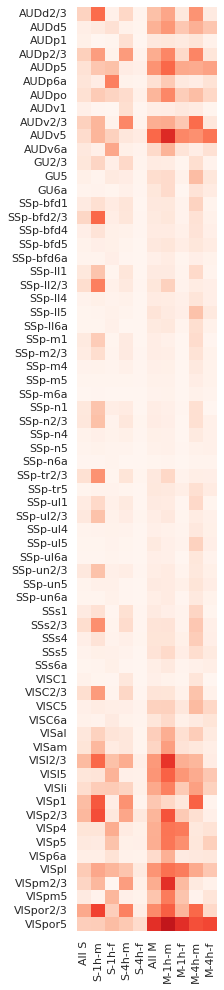

In [24]:
sensory_areas = set(["SS", "GU", "VISC", "AUD", "VIS"])
sensory_regions = []
for acronym in leaves_by_parent['Isocortex']:
    parents = set(atlas.get_structure_ancestors(acronym))
    if len(parents.intersection(sensory_areas)):
        sensory_regions.append(acronym)

# Sensory regions heatmap
subset_of_regions = sorted(sensory_regions)

heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
plt.show()

## Association areas

<Figure size 180x1008 with 1 Axes>

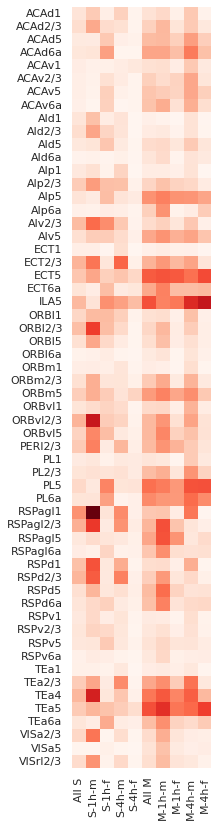

In [25]:
association_areas = set(["ACA", "PL", "ILA", "ORB", "AI", "RSP", "PTLp", "TEa", "PERI", "ECT"])
association_regions = []
for acronym in leaves_by_parent['Isocortex']:
    parents = set(atlas.get_structure_ancestors(acronym))
    if len(parents.intersection(association_areas)):
        association_regions.append(acronym)

# association regions heatmap
subset_of_regions = sorted(association_regions)
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g.set(xticklabels=[])
plt.show()

## Motor areas

<Figure size 180x144 with 1 Axes>

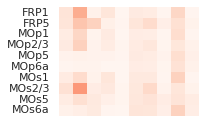

In [26]:
motor_areas = set(["FRP", "MO"])
motor_regions = []
for acronym in leaves_by_parent['Isocortex']:
    parents = set(atlas.get_structure_ancestors(acronym))
    if len(parents.intersection(motor_areas)):
        motor_regions.append(acronym)

# Motor regions heatmap
subset_of_regions = sorted(motor_regions)
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=True, cbar_kws={"orientation": "horizontal"})  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## olfactory areas

<Figure size 180x216 with 1 Axes>

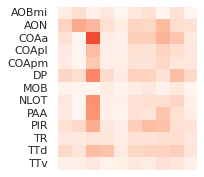

In [27]:
# olfactory areas heatmap
subset_of_regions = sorted(leaves_by_parent['OLF'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Hippocampal formation

<Figure size 180x360 with 1 Axes>

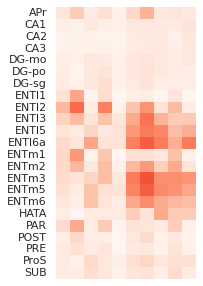

In [28]:
# hippocampal formation heatmap
subset_of_regions = sorted(leaves_by_parent['HPF'])

heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Cortical subplate

<Figure size 180x144 with 1 Axes>

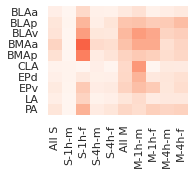

In [29]:
# cortical subplate heatmap
subset_of_regions = sorted(leaves_by_parent['CTXsp'])

heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g.set(xticklabels=[])
plt.show()

## Striatum

<Figure size 180x216 with 1 Axes>

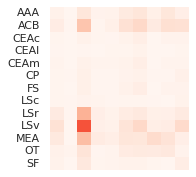

In [30]:
# Striatum heatmap
subset_of_regions = sorted(leaves_by_parent['STR'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Pallidum

<Figure size 180x144 with 1 Axes>

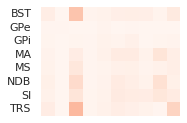

In [31]:
# Pallidum heatmap
subset_of_regions = sorted(leaves_by_parent['PAL'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Midbrain

<Figure size 180x360 with 1 Axes>

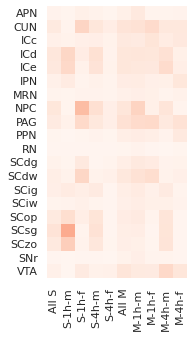

In [32]:
# Midbrain heatmap
subset_of_regions = sorted(leaves_by_parent['MB'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g.set(xticklabels=[])
plt.show()

## Hypothalamus

<Figure size 180x216 with 1 Axes>

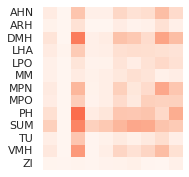

In [33]:
# Hypothalamus heatmap
subset_of_regions = sorted(leaves_by_parent['HY'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Thalamus

<Figure size 180x360 with 1 Axes>

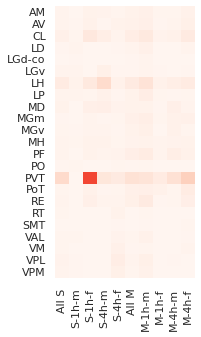

In [34]:
# Thalamus heatmap
subset_of_regions = sorted(leaves_by_parent['TH'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g.set(xticklabels=[])
plt.show()

## Pons

<Figure size 180x216 with 1 Axes>

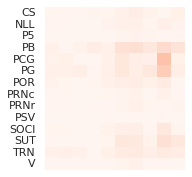

In [35]:
# Pons heatmap
subset_of_regions = sorted(leaves_by_parent['P'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Medulla

<Figure size 180x360 with 1 Axes>

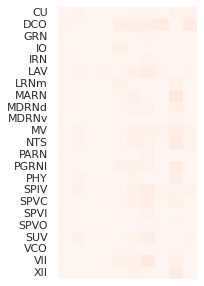

In [36]:
# Medulla heatmap
subset_of_regions = sorted(leaves_by_parent['MY'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
g.set(xticklabels=[])
plt.show()

## Cerebellum

<Figure size 180x288 with 1 Axes>

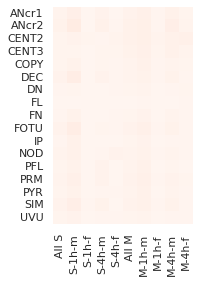

In [37]:
# Cerebellum heatmap
subset_of_regions = sorted(leaves_by_parent['CB'])
heatmap = get_matrix_heatmap_small_groups(subset_of_regions)

dims = (10*figure_scale, int(len(subset_of_regions)*figure_scale))
fig, ax = plt.subplots(figsize=dims)
g = sns.heatmap(heatmap, cmap="Reds", yticklabels=subset_of_regions, xticklabels=conditions, vmin=0, vmax=hm_max, cbar=False)  # Customize cmap for different color schemes
# g.set(xticklabels=[])
plt.show()

# Figure 4 <a id="fig4"/>

## 4a

Text(0, 0.5, '$\\mathrm{-log}_{10} \\mathrm{(p)}$')

<Figure size 2016x576 with 1 Axes>

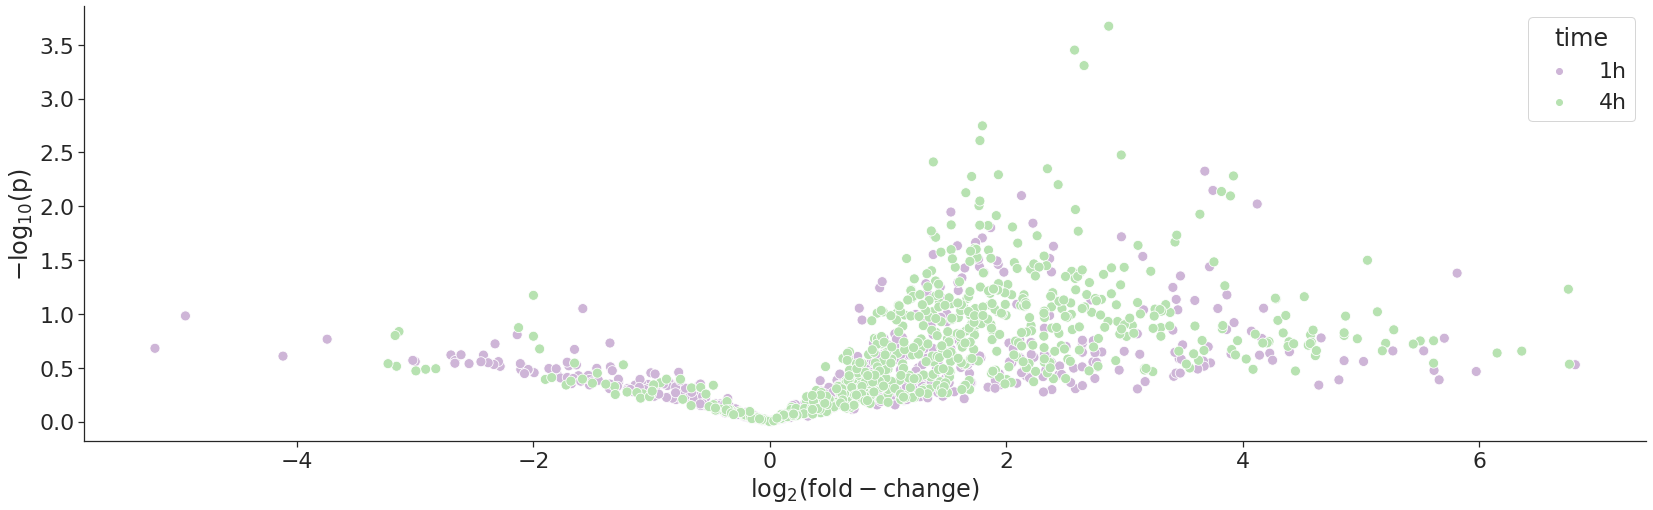

In [38]:
# 1h
merged_df_1h = pd.merge(morphine_1h_average_density_df, saline_1h_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df_1h = merged_df_1h[merged_df_1h['density_saline'] > 0]

merged_df_1h['density_ratio'] = merged_df_1h['density_morphine'] / merged_df_1h['density_saline']

density_ratio_df_1h = merged_df_1h[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_1h['Structure'].to_list():
    morphine_dataset = morphine_dfs_1h[morphine_dfs_1h['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset) == 8
    saline_dataset = saline_dfs_1h[saline_dfs_1h['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset) == 5
    p_val = get_p_value(morphine_dataset, saline_dataset)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_1h['p_value'] = p_values

density_ratio_df_1h['acronym'] = list(map(get_acronym, density_ratio_df_1h['Structure'].to_list()))

density_ratio_df_1h['log2FC'] = np.log2(density_ratio_df_1h['density_ratio'])
density_ratio_df_1h['negative_log_pval'] = np.log10(density_ratio_df_1h['p_value']) * (-1)

density_ratio_df_1h['is_grey'] = list(map(is_grey, density_ratio_df_1h['acronym'].to_list()))
volcano_plot_df_1h = density_ratio_df_1h.copy()[density_ratio_df_1h['is_grey'] == True]


# 4h
merged_df_4h = pd.merge(morphine_4h_average_density_df, saline_4h_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df_4h = merged_df_4h[merged_df_4h['density_saline'] > 0]

merged_df_4h['density_ratio'] = merged_df_4h['density_morphine'] / merged_df_4h['density_saline']

density_ratio_df_4h = merged_df_4h[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_4h['Structure'].to_list():
    morphine_dataset = morphine_dfs_4h[morphine_dfs_4h['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset) == 7
    saline_dataset = saline_dfs_4h[saline_dfs_4h['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset) == 7
    p_val = get_p_value(morphine_dataset, saline_dataset)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_4h['p_value'] = p_values
density_ratio_df_4h['acronym'] = list(map(get_acronym, density_ratio_df_4h['Structure'].to_list()))

density_ratio_df_4h['log2FC'] = np.log2(density_ratio_df_4h['density_ratio'])
density_ratio_df_4h['negative_log_pval'] = np.log10(density_ratio_df_4h['p_value']) * (-1)

density_ratio_df_4h['is_grey'] = list(map(is_grey, density_ratio_df_4h['acronym'].to_list()))
volcano_plot_df_4h = density_ratio_df_4h.copy()[density_ratio_df_4h['is_grey'] == True]

volcano_plot_df_1h['time'] = '1h'
volcano_plot_df_4h['time'] = '4h'
volcano_plot_df_1h_4h = pd.concat([volcano_plot_df_1h, volcano_plot_df_4h])

volcano_plot_df_1h_4h.drop(volcano_plot_df_1h_4h[volcano_plot_df_1h_4h['log2FC'] == volcano_plot_df_1h_4h['log2FC'].min()].index, inplace=True)

palette = "PRGn"

sns.set_theme(font_scale=2, style="ticks", palette="pastel", rc={'figure.figsize':(28,8)})

ax = sns.scatterplot(data=volcano_plot_df_1h_4h, x='log2FC', y='negative_log_pval', hue='time', s=100, palette=palette)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel(r"$\mathrm{log}_2 \mathrm{(fold-change)}$")
plt.ylabel(r"$\mathrm{-log}_{10} \mathrm{(p)}$")

## 4b

All structures 840
Filtered structures 452
Significant (47, 3)
Structures with parents excluded 30
Structures with parents excluded ['MRN', 'SUB', 'AUDv5', 'PL5', 'VISC5', 'AIv', 'AUDd', 'DP', 'TEa4', 'AUDp5', 'ACB', 'ORBvl', 'ORBl5', 'ACAd', 'SSp-n4', 'AId5', 'MOs', 'SSs4', 'DMH', 'MOp', 'ACAv5', 'SSp-m', 'SSs2/3', 'SCzo', 'MPN', 'PL6a', 'SSp-bfd4', 'SSp-ul', 'MSC', 'SSp-un']
Structures with parents excluded DF (30, 3)
1h higher ['MRN']
4h higher ['SUB', 'AUDv5', 'PL5', 'VISC5', 'AIv', 'AUDd', 'DP', 'TEa4', 'AUDp5', 'ACB', 'ORBvl', 'ORBl5', 'ACAd', 'SSp-n4', 'AId5', 'MOs', 'SSs4', 'DMH', 'MOp', 'ACAv5', 'SSp-m', 'SSs2/3', 'SCzo', 'MPN', 'PL6a', 'SSp-bfd4', 'SSp-ul', 'MSC', 'SSp-un']


Saving new screenshot at 1h_vs_4h_normalized_full_brain.png

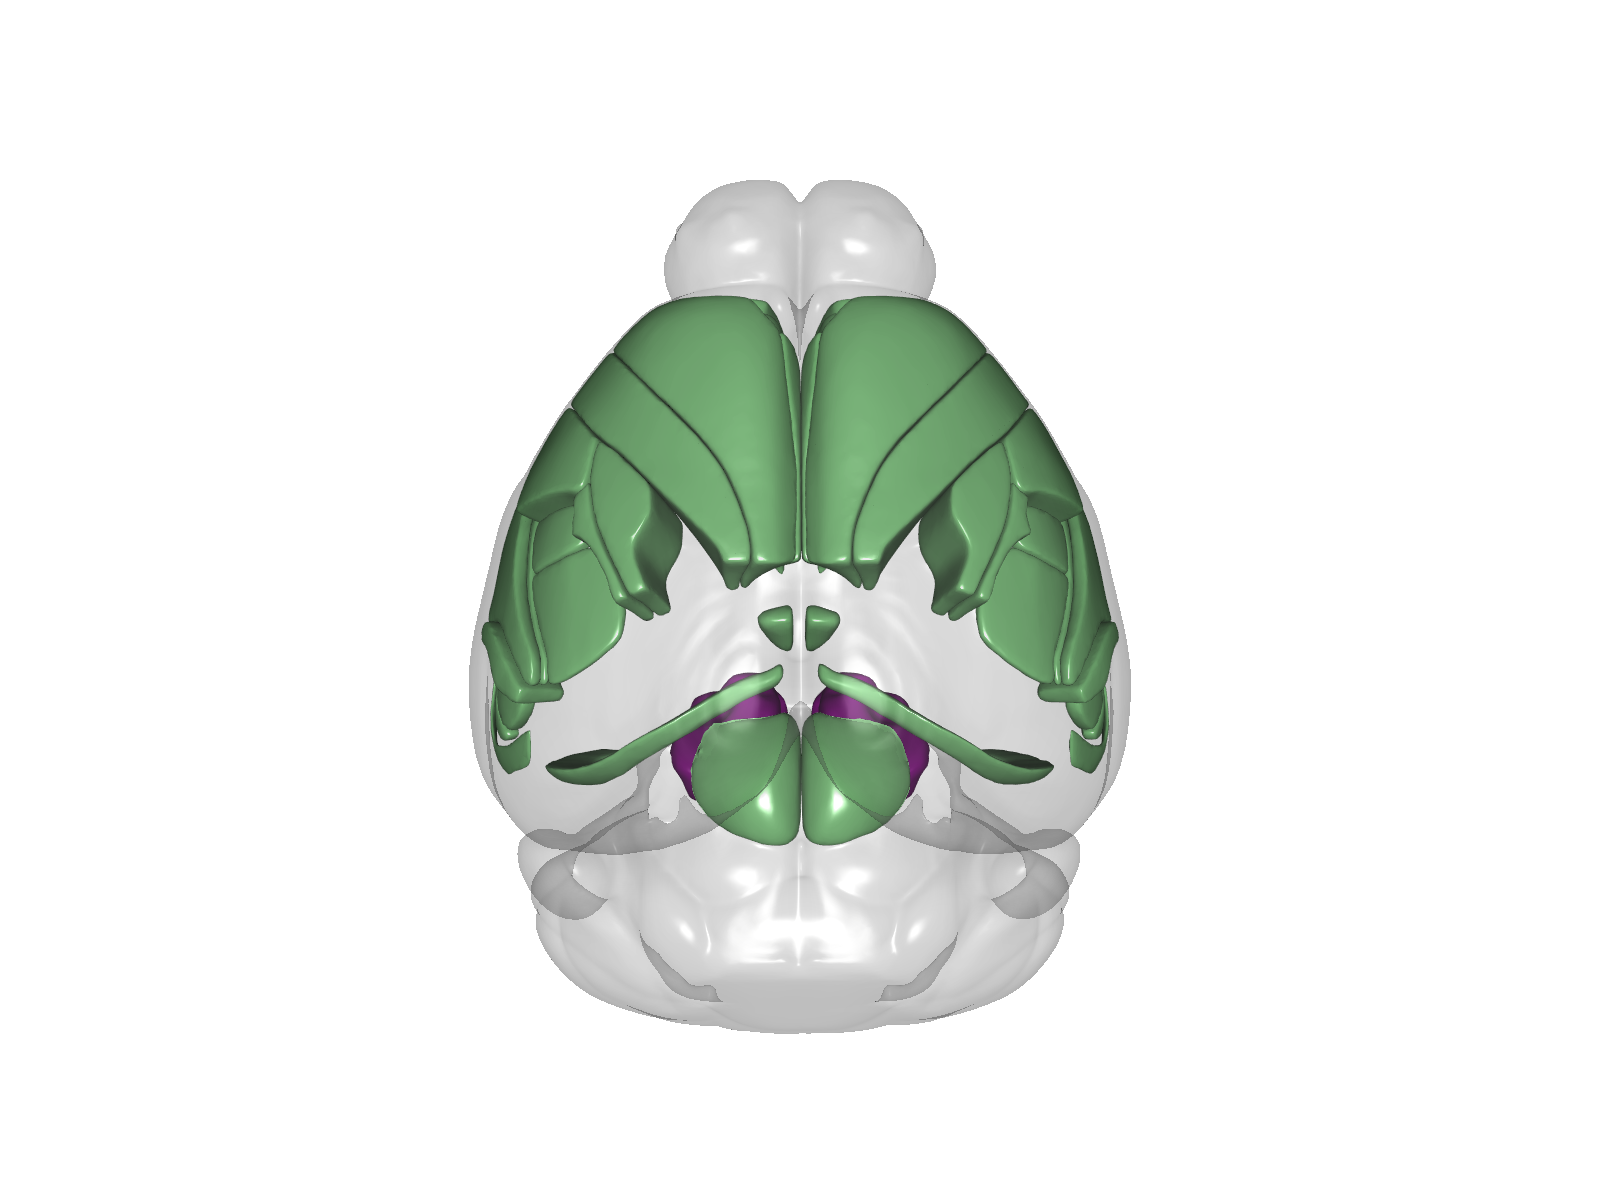

In [39]:
brainrender.settings.SHADER_STYLE = "glossy"


class CustomScene(Scene):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _make_axes(self):
        return {}


get_acronym = lambda x: x.split(">")[-1]

def is_large_enough(acronym):
    volume = region_volumes[acronym]
    return volume >= volume_mm3_threshold

def is_grey(acronym):
    parents = atlas.get_structure_ancestors(acronym)
    return "grey" in parents

def structure_from_acronym(acronym):
    return ">".join(atlas.get_structure_ancestors(acronym) + [acronym])

def exclude_parents(acronyms):
    """
    Goes through the list of acronyms, and removes structures that are parents of other structures in this list.
    For example, if list contains both ACB and STR (STR being parent of ACB), this function will exclude ACB
    """
    acronyms_filtered = acronyms[:]
    for acronym in acronyms:
        parents = atlas.get_structure_ancestors(acronym)
        for parent in parents:
            if parent in acronyms_filtered:
                acronyms_filtered.remove(parent)
    return acronyms_filtered

######### read 1h only ############
morphine_dfs_1h = []
saline_dfs_1h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 1:
        morphine_dfs_1h.append(density_df)
    elif treatment == "saline" and time_point == 1:
        saline_dfs_1h.append(density_df)
    else:
        pass

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_1h = pd.concat(morphine_dfs_1h)
assert morphine_dfs_1h.shape[0] == 840 * 8

saline_dfs_1h = pd.concat(saline_dfs_1h)
assert saline_dfs_1h.shape[0] == 840 * 5

morphine_dfs_1h.sort_values(by='Structure', inplace=True)
saline_dfs_1h.sort_values(by='Structure', inplace=True)

morphine_dfs_1h.reset_index(drop=True, inplace=True)
saline_dfs_1h.reset_index(drop=True, inplace=True)

######### read 4h only ############
morphine_dfs_4h = []
saline_dfs_4h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 4:
        morphine_dfs_4h.append(density_df)
    elif treatment == "saline" and time_point == 4:
        saline_dfs_4h.append(density_df)
    else:
        pass

# create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
morphine_dfs_4h = pd.concat(morphine_dfs_4h)
assert morphine_dfs_4h.shape[0] == 840 * 7

saline_dfs_4h = pd.concat(saline_dfs_4h)
assert saline_dfs_4h.shape[0] == 840 * 7

morphine_dfs_4h.sort_values(by='Structure', inplace=True)
saline_dfs_4h.sort_values(by='Structure', inplace=True)

morphine_dfs_4h.reset_index(drop=True, inplace=True)
saline_dfs_4h.reset_index(drop=True, inplace=True)

structures = list(morphine_dfs_1h['Structure'].unique())
print("All structures", len(structures))

filtered_structures = []
for structure in structures:
    acronym = get_acronym(structure)
    if is_grey(acronym) and is_large_enough(acronym):
        filtered_structures.append(structure)
print("Filtered structures", len(filtered_structures))

# normalization by division
p_values_div = []
effect_1h_4h_div = []

for structure in filtered_structures:
    avg_1h_saline_count = np.mean(saline_dfs_1h[saline_dfs_1h['Structure'] == structure]['cell_count'].to_numpy())
    if avg_1h_saline_count < min_cells:
        p_values_div.append(1)
        effect_1h_4h_div.append(0)
        continue
    all_1h_morphine_count_values = morphine_dfs_1h[morphine_dfs_1h['Structure'] == structure]['cell_count'].to_numpy()
    avg_1h_morphine_count = np.mean(all_1h_morphine_count_values)
    if avg_1h_morphine_count < min_cells:
        p_values_div.append(1)
        effect_1h_4h_div.append(0)
        continue
    normalized_1h_morphine_count_values = all_1h_morphine_count_values / avg_1h_saline_count

    avg_4h_saline_count = np.mean(saline_dfs_4h[saline_dfs_4h['Structure'] == structure]['cell_count'].to_numpy())
    if avg_4h_saline_count < min_cells:
        p_values_div.append(1)
        effect_1h_4h_div.append(0)
        continue
    all_4h_morphine_count_values = morphine_dfs_4h[morphine_dfs_4h['Structure'] == structure]['cell_count'].to_numpy()
    avg_4h_morphine_count = np.mean(all_4h_morphine_count_values)
    if avg_4h_morphine_count < min_cells:
        p_values_div.append(1)
        effect_1h_4h_div.append(0)
        continue
    normalized_4h_morphine_count_values = all_4h_morphine_count_values / avg_4h_saline_count

    p_val = get_p_value(normalized_1h_morphine_count_values, normalized_4h_morphine_count_values)
    p_values_div.append(p_val)
    effect = np.mean(normalized_1h_morphine_count_values) / np.mean(normalized_4h_morphine_count_values)
    effect_1h_4h_div.append(effect)

p_values_div = np.array(p_values_div)

df_1h_4h_normalized_division = pd.DataFrame()
df_1h_4h_normalized_division['structure'] = filtered_structures
df_1h_4h_normalized_division['p_value'] = p_values_div
df_1h_4h_normalized_division['effect'] = effect_1h_4h_div
df_1h_4h_normalized_signif = df_1h_4h_normalized_division[df_1h_4h_normalized_division['p_value'] < 0.05]

print("Significant", df_1h_4h_normalized_signif.shape)
df_1h_4h_normalized_signif.sort_values('effect', ascending=False, inplace=True)
structures = list(map(get_acronym, df_1h_4h_normalized_signif['structure'].to_list()))
structures_no_parents = exclude_parents(structures)
print("Structures with parents excluded", len(structures_no_parents))
print("Structures with parents excluded", structures_no_parents)
structures_no_parents = list(map(structure_from_acronym, structures_no_parents))
df_1h_4h_normalized_signif_no_parents = df_1h_4h_normalized_signif[df_1h_4h_normalized_signif['structure'].isin(structures_no_parents)]
print("Structures with parents excluded DF", df_1h_4h_normalized_signif_no_parents.shape)

structures_1h_higher = df_1h_4h_normalized_signif_no_parents[df_1h_4h_normalized_signif_no_parents['effect'] > 1]
structures_1h_higher = structures_1h_higher['structure'].to_list()
structures_1h_higher = list(map(get_acronym, structures_1h_higher))
print("1h higher", structures_1h_higher)

structures_4h_higher = df_1h_4h_normalized_signif_no_parents[df_1h_4h_normalized_signif_no_parents['effect'] < 1]
structures_4h_higher = structures_4h_higher['structure'].to_list()
structures_4h_higher = list(map(get_acronym, structures_4h_higher))
print("4h higher", structures_4h_higher)

# # full brain
scene = CustomScene(atlas_name="allen_mouse_10um")
for structure in structures_1h_higher:
    scene.add_brain_region(structure, color="purple")
for structure in structures_4h_higher:
    scene.add_brain_region(structure, color="lightgreen")
scene.render(interactive=False, camera='top', zoom=1)
scene.screenshot(name="1h_vs_4h_normalized_full_brain")

screenshot_path = "1h_vs_4h_normalized_full_brain.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

Saving new screenshot at 1h_vs_4h_normalized_sagittal_slice.png

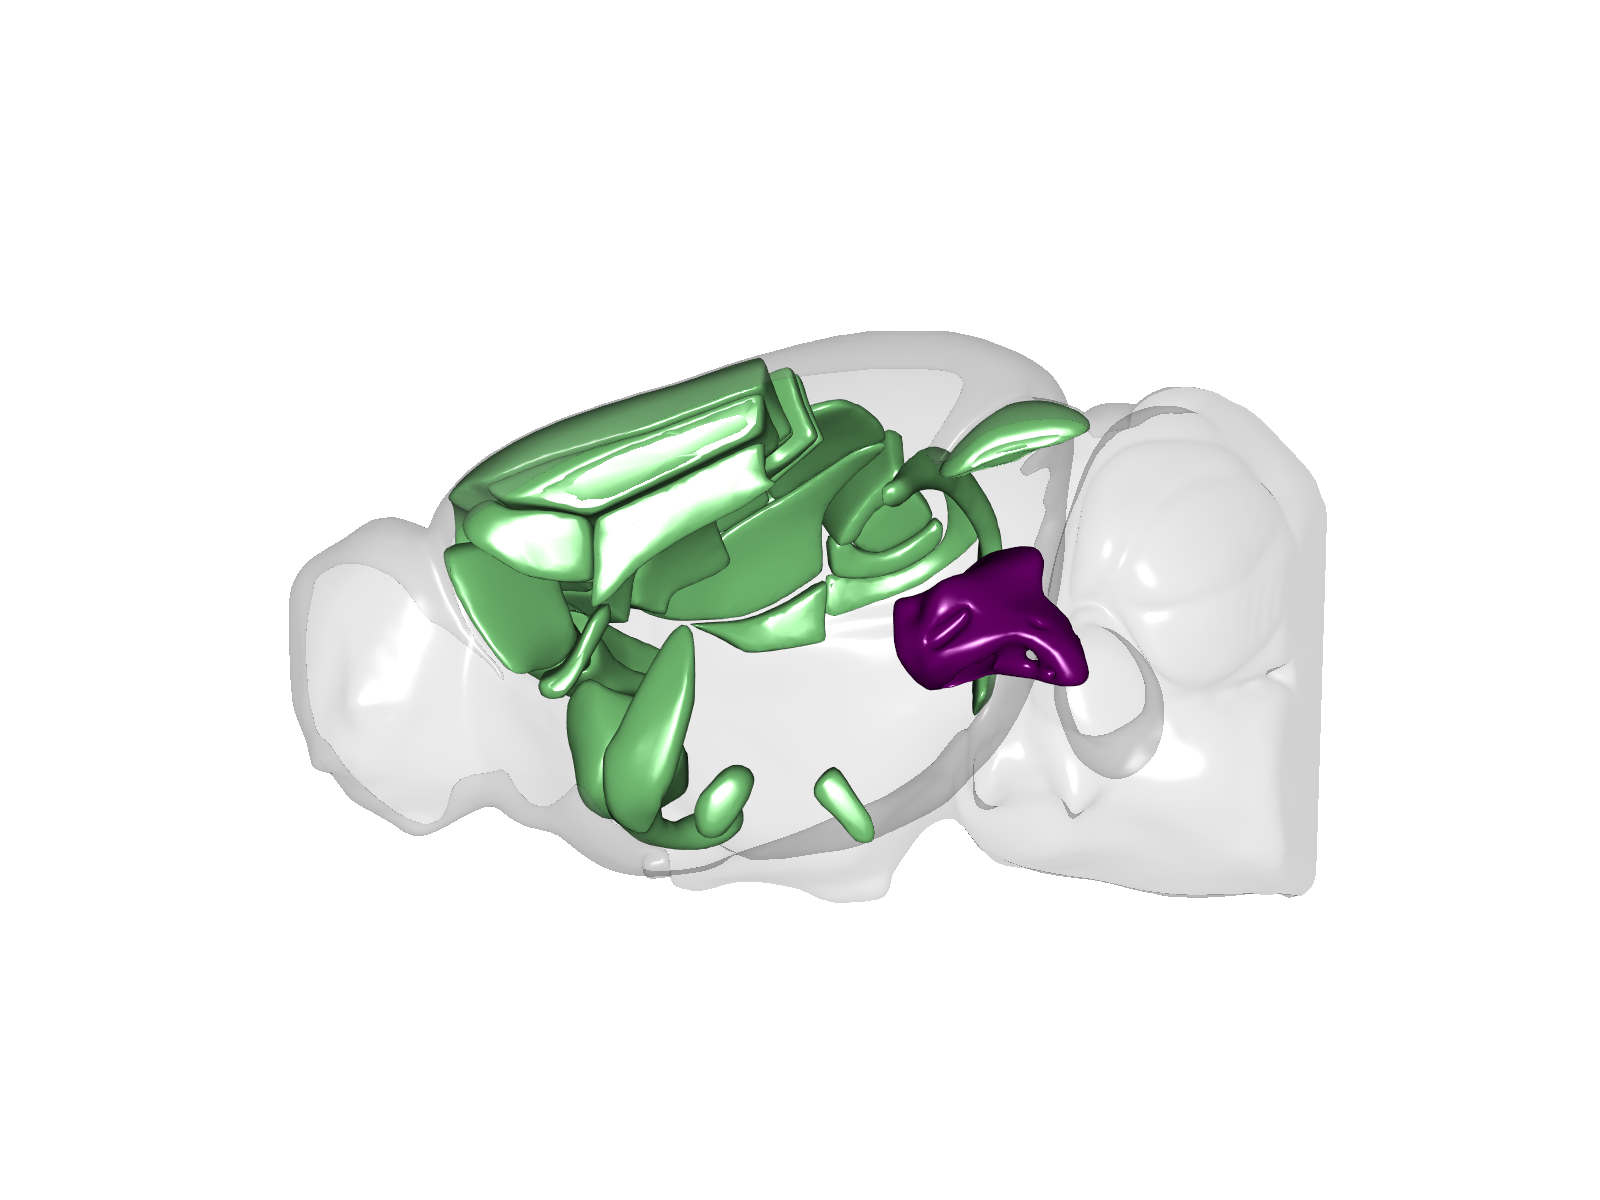

In [40]:
## sagittal slice
scene = CustomScene(atlas_name="allen_mouse_10um")
for structure in structures_1h_higher:
    scene.add_brain_region(structure, color="purple")
for structure in structures_4h_higher:
    scene.add_brain_region(structure, color="lightgreen")
scene.slice('sagittal')
custom_cam = {
    'pos': (6514, -34, -36854),
    'viewup': (0, -1, 0),
    'clipping_range': (29281, 60290),
}
scene.render(interactive=False, camera=custom_cam, zoom=1)
scene.screenshot(name="1h_vs_4h_normalized_sagittal_slice")

# Replace 'some_name.png' with the actual file path to the screenshot
screenshot_path = "1h_vs_4h_normalized_sagittal_slice.png"

# Display the image in the Jupyter Notebook
display(Image(filename=screenshot_path))

Saving new screenshot at 1h_vs_4h_normalized_coronal_slice_STR.png

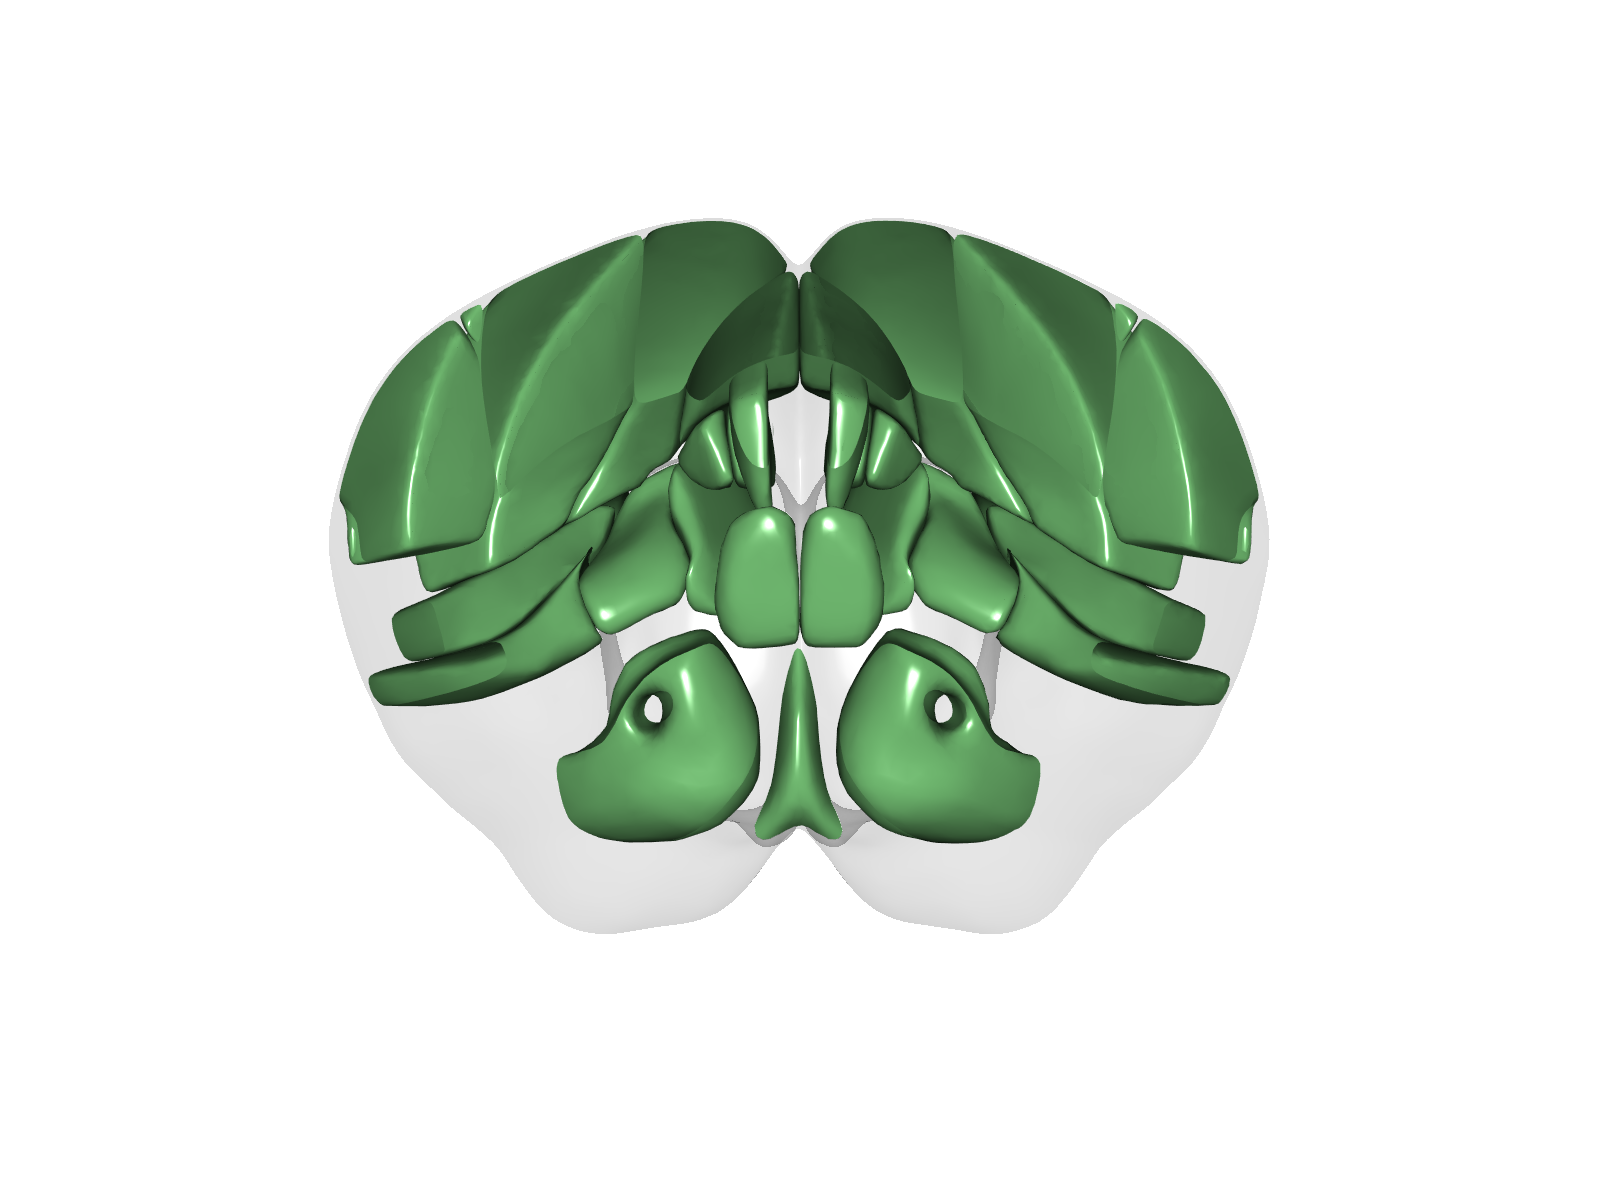

In [41]:
## coronal slice (striatum)
scene = CustomScene(atlas_name="allen_mouse_10um")

plane = scene.atlas.get_plane(pos=(430*10, 400*10, 570*10), norm=(-1, 0, 0))  # Striatum
for structure in structures_1h_higher:
    scene.add_brain_region(structure, color="purple")
for structure in structures_4h_higher:
    scene.add_brain_region(structure, color="lightgreen")
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="1h_vs_4h_normalized_coronal_slice_STR")

# Replace 'some_name.png' with the actual file path to the screenshot
screenshot_path = "1h_vs_4h_normalized_coronal_slice_STR.png"

# Display the image in the Jupyter Notebook
display(Image(filename=screenshot_path))

Saving new screenshot at 1h_vs_4h_normalized_coronal_slice_DMH.png

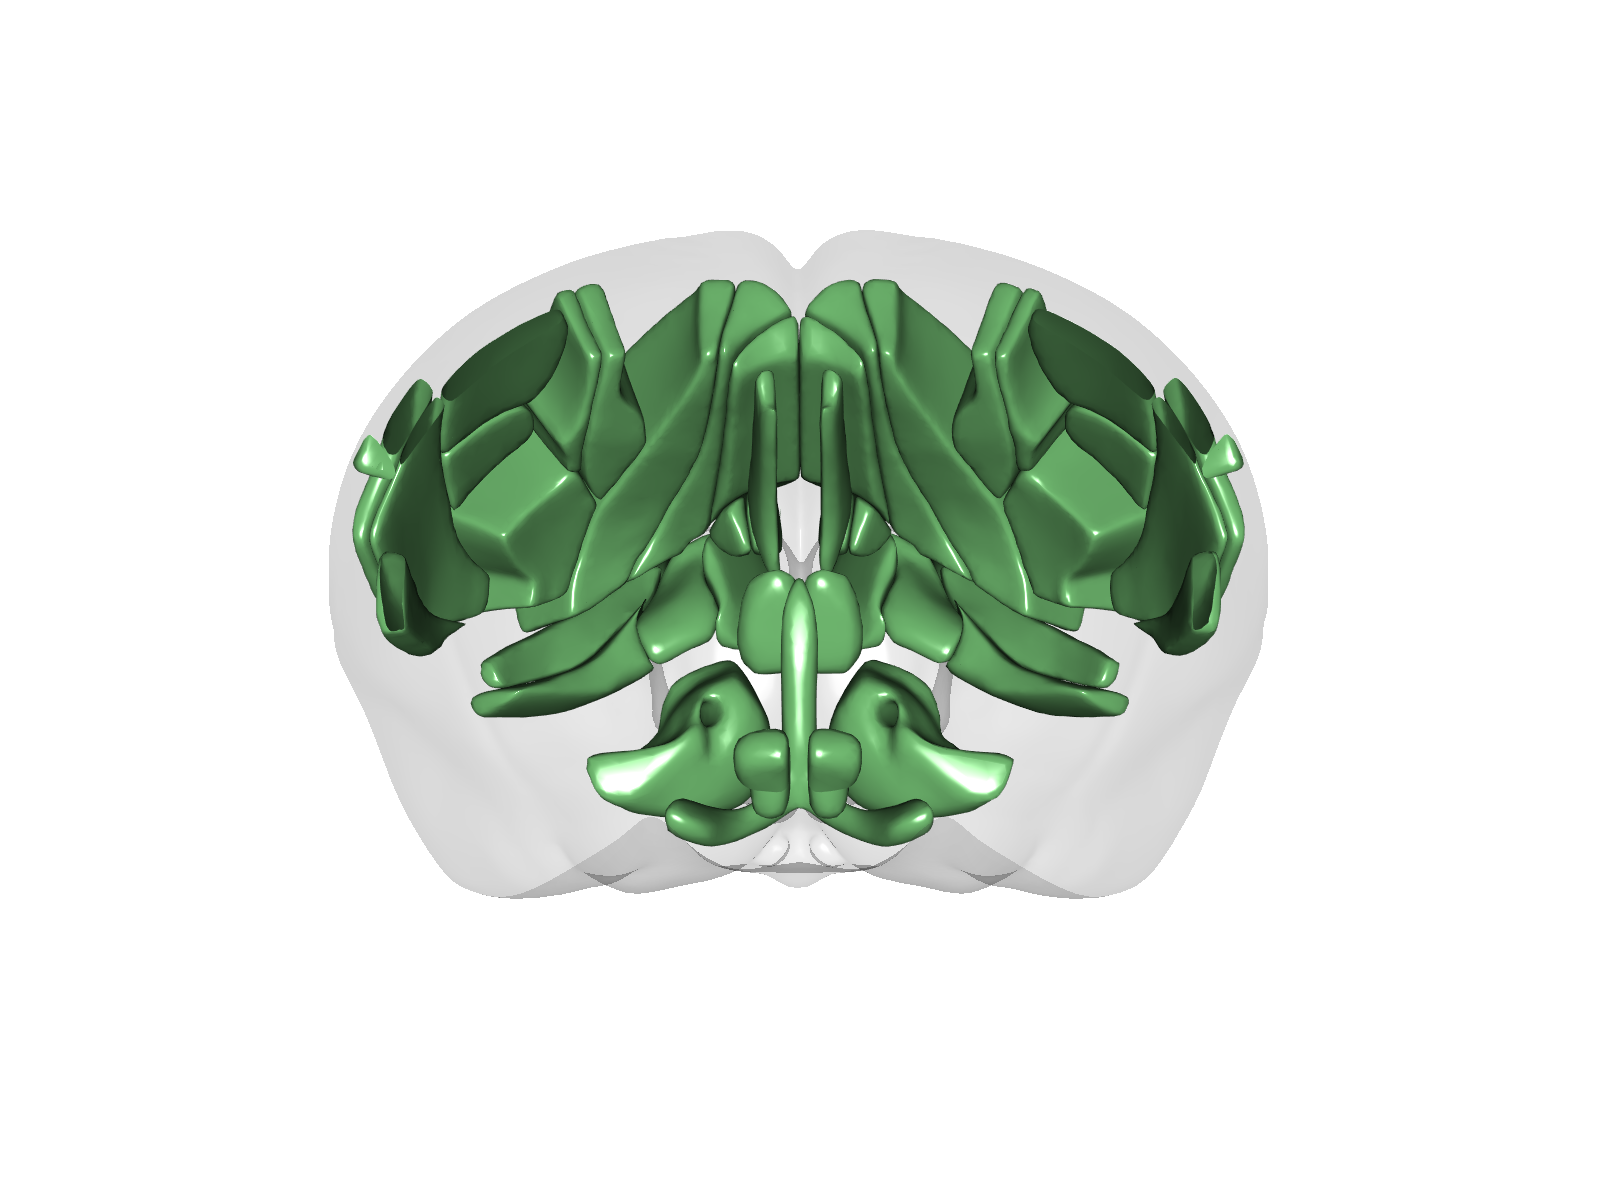

In [42]:
## coronal slice (DMH)
scene = CustomScene(atlas_name="allen_mouse_10um")
plane = scene.atlas.get_plane(pos=(700*10, 400*10, 570*10), norm=(-1, 0, 0))  # HIP
for structure in structures_1h_higher:
    scene.add_brain_region(structure, color="purple")
for structure in structures_4h_higher:
    scene.add_brain_region(structure, color="lightgreen")
# scene.slice('sagittal')
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="1h_vs_4h_normalized_coronal_slice_DMH")

# Replace 'some_name.png' with the actual file path to the screenshot
screenshot_path = "1h_vs_4h_normalized_coronal_slice_DMH.png"

# Display the image in the Jupyter Notebook
display(Image(filename=screenshot_path))

Saving new screenshot at 1h_vs_4h_normalized_coronal_slice_MRN.png

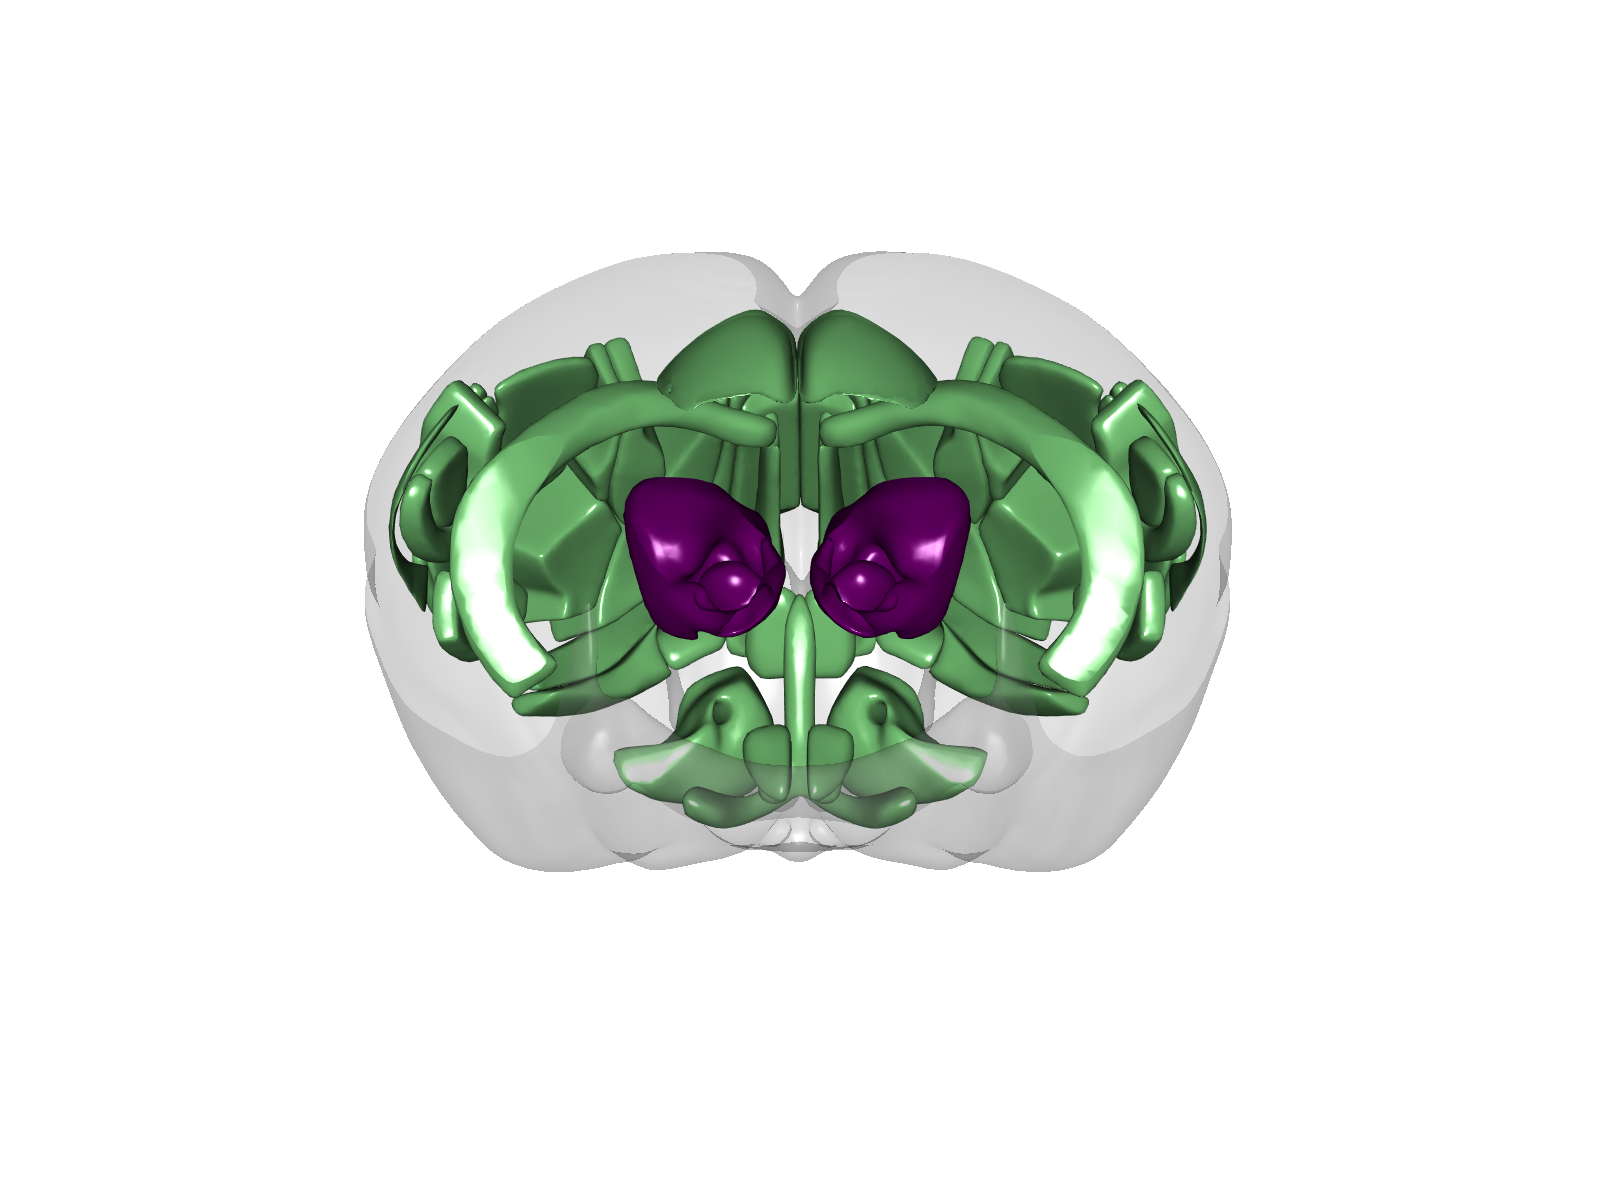

In [43]:
## coronal slice (MRN)
scene = CustomScene(atlas_name="allen_mouse_10um")
plane = scene.atlas.get_plane(pos=(925*10, 400*10, 570*10), norm=(-1, 0, 0))
for structure in structures_1h_higher:
    scene.add_brain_region(structure, color="purple")
for structure in structures_4h_higher:
    scene.add_brain_region(structure, color="lightgreen")
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
# scene.render()
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="1h_vs_4h_normalized_coronal_slice_MRN")

# Replace 'some_name.png' with the actual file path to the screenshot
screenshot_path = "1h_vs_4h_normalized_coronal_slice_MRN.png"

# Display the image in the Jupyter Notebook
display(Image(filename=screenshot_path))

## 4c

<Figure size 2160x576 with 1 Axes>

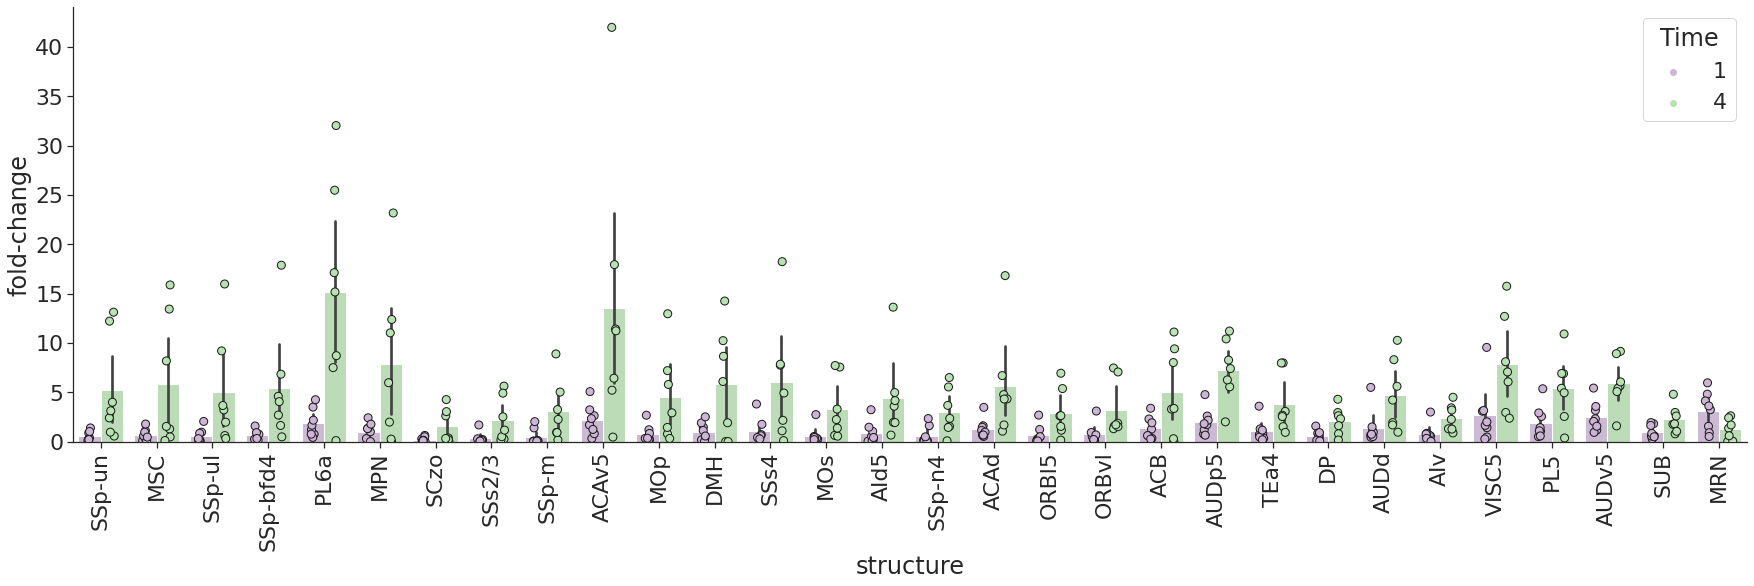

In [44]:
structures_data_1h = []
structures_data_4h = []
structures = list(reversed(structures_no_parents))
for structure in structures:
    avg_1h_saline_count = np.mean(saline_dfs_1h[saline_dfs_1h['Structure'] == structure]['cell_count'].to_numpy())
    all_1h_morphine_count_values = morphine_dfs_1h[morphine_dfs_1h['Structure'] == structure]['cell_count'].to_numpy()
    normalized_1h_morphine_count_values = all_1h_morphine_count_values / avg_1h_saline_count
    structure_df_1h = pd.DataFrame()
    structure_df_1h['value'] = normalized_1h_morphine_count_values
    structure_df_1h['structure'] = [get_acronym(structure)] * len(normalized_1h_morphine_count_values)
    structure_df_1h['time_point'] = ['1'] * len(normalized_1h_morphine_count_values)
    structures_data_1h.append(structure_df_1h)

    avg_4h_saline_count = np.mean(saline_dfs_4h[saline_dfs_4h['Structure'] == structure]['cell_count'].to_numpy())
    all_4h_morphine_count_values = morphine_dfs_4h[morphine_dfs_4h['Structure'] == structure]['cell_count'].to_numpy()
    normalized_4h_morphine_count_values = all_4h_morphine_count_values / avg_4h_saline_count   
    structure_df_4h = pd.DataFrame()
    structure_df_4h['value'] = normalized_4h_morphine_count_values
    structure_df_4h['structure'] = [get_acronym(structure)] * len(normalized_4h_morphine_count_values)
    structure_df_4h['time_point'] = ['4'] * len(normalized_4h_morphine_count_values)
    structures_data_4h.append(structure_df_4h)
    
structures_data_1h = pd.concat(structures_data_1h)
structures_data_4h = pd.concat(structures_data_4h)
structures_data_1h_4h = pd.concat([structures_data_1h, structures_data_4h])

palette = "PRGn"  # "GnBu"

sns.set_theme(font_scale=2, style="ticks", palette="pastel", rc={'figure.figsize':(30,8)})


ax = sns.barplot(x="structure", y="value", hue="time_point", data=structures_data_1h_4h, palette=palette)

# add stripplot with dodge=True
sns.stripplot(x="structure", y="value", hue="time_point", data=structures_data_1h_4h, palette=palette, dodge=True, ax=ax, s=8, edgecolor='k', linewidth=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], title='Treatment', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.legend(handles[:2], labels[:2], title='Time')
ax.set(xlabel="structure", ylabel="fold-change")
ax.tick_params(axis='x', rotation=90)
# ax.set_xlabel('structure', fontsize=20);

## 4d

Text(0, 0.5, '$\\mathrm{-log}_{10} \\mathrm{(p)}$')

<Figure size 2016x576 with 1 Axes>

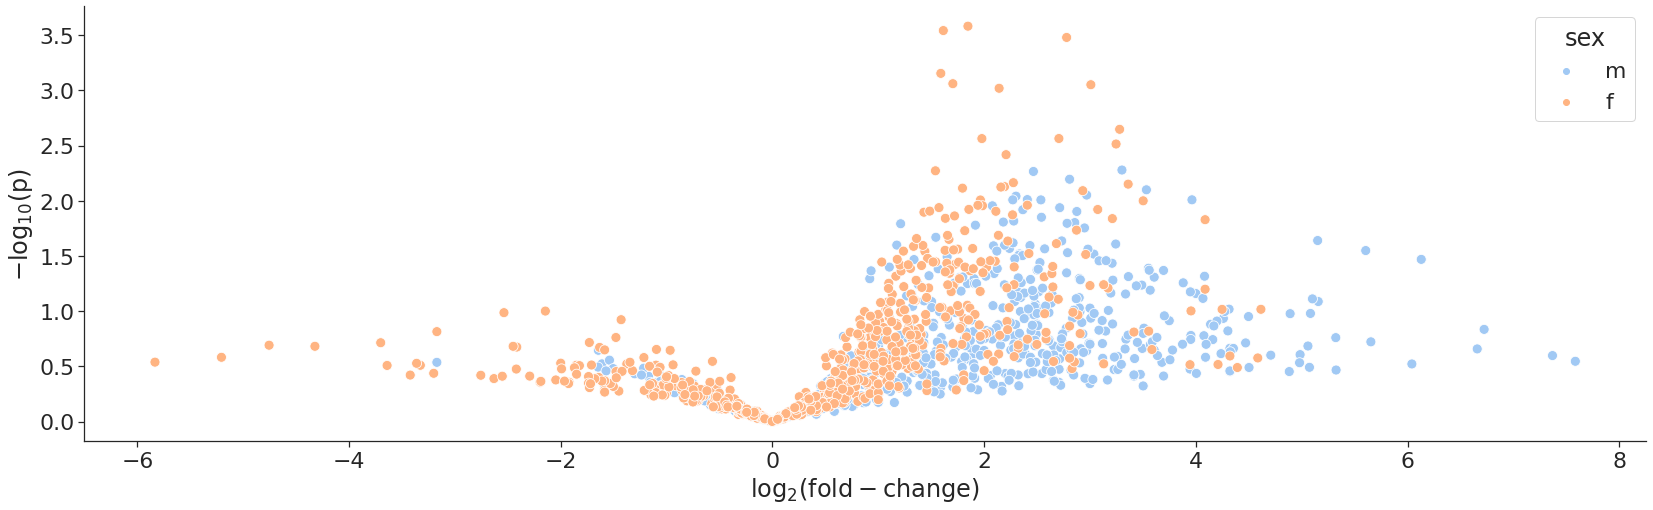

In [45]:
# male
merged_df_male = pd.merge(morphine_male_average_density_df, saline_male_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df_male = merged_df_male[merged_df_male['density_saline'] > 0]   # TODO: how do we deal with binary effects?
merged_df_male = merged_df_male[merged_df_male['density_morphine'] > 0]   # TODO: how do we deal with binary effects?

merged_df_male['density_ratio'] = merged_df_male['density_morphine'] / merged_df_male['density_saline']

density_ratio_df_male = merged_df_male[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_male['Structure'].to_list():
    morphine_dataset_m = morphine_dfs_male[morphine_dfs_male['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset_m) == 9
    saline_dataset_m = saline_dfs_male[saline_dfs_male['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset_m) == 6
    p_val = get_p_value(morphine_dataset_m, saline_dataset_m)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_male['p_value'] = p_values
density_ratio_df_male['acronym'] = list(map(get_acronym, density_ratio_df_male['Structure'].to_list()))

density_ratio_df_male['log2FC'] = np.log2(density_ratio_df_male['density_ratio'])
density_ratio_df_male['negative_log_pval'] = np.log10(density_ratio_df_male['p_value']) * (-1)

density_ratio_df_male['is_grey'] = list(map(is_grey, density_ratio_df_male['acronym'].to_list()))
volcano_plot_df_male = density_ratio_df_male.copy()[density_ratio_df_male['is_grey'] == True]


# female
merged_df_female = pd.merge(morphine_female_average_density_df, saline_female_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df_female = merged_df_female[merged_df_female['density_morphine'] > 0]   # TODO: how do we deal with binary effects?
merged_df_female = merged_df_female[merged_df_female['density_saline'] > 0]   # TODO: how do we deal with binary effects?

merged_df_female['density_ratio'] = merged_df_female['density_morphine'] / merged_df_female['density_saline']

density_ratio_df_female = merged_df_female[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_female['Structure'].to_list():
    morphine_dataset_f = morphine_dfs_female[morphine_dfs_female['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset_f) == 6
    saline_dataset_f = saline_dfs_female[saline_dfs_female['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset_f) == 6
    p_val = get_p_value(morphine_dataset_f, saline_dataset_f)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_female['p_value'] = p_values
density_ratio_df_female['acronym'] = list(map(get_acronym, density_ratio_df_female['Structure'].to_list()))

density_ratio_df_female['log2FC'] = np.log2(density_ratio_df_female['density_ratio'])
density_ratio_df_female['negative_log_pval'] = np.log10(density_ratio_df_female['p_value']) * (-1)

density_ratio_df_female['is_grey'] = list(map(is_grey, density_ratio_df_female['acronym'].to_list()))
volcano_plot_df_female = density_ratio_df_female.copy()[density_ratio_df_female['is_grey'] == True]


volcano_plot_df_male['sex'] = 'm'
volcano_plot_df_female['sex'] = 'f'
volcano_plot_df_male_female = pd.concat([volcano_plot_df_male, volcano_plot_df_female])

sns.set_theme(font_scale=2, style="ticks", palette="pastel", rc={'figure.figsize':(28,8)})
ax = sns.scatterplot(data=volcano_plot_df_male_female, x='log2FC', y='negative_log_pval', hue='sex', s=100)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel(r"$\mathrm{log}_2 \mathrm{(fold-change)}$")
plt.ylabel(r"$\mathrm{-log}_{10} \mathrm{(p)}$")

## 4e

Filtered structures 452
Significant (47, 7)
Structures with parents excluded 31
Structures with parents excluded ['ACB', 'LA', 'PAL', 'BLAa', 'BMAp', 'BLAp', 'sAMY', 'LHA', 'PA', 'EPd', 'ACAv1', 'ECT6a', 'SUB', 'ProS', 'AUDv', 'VISC', 'VISrl', 'ICd', 'SSp-ll', 'ENTl2', 'SSp-bfd2/3', 'ICe', 'TEa2/3', 'SSp-tr', 'VISa', 'PERI2/3', 'ECT2/3', 'SSs2/3', 'AUDp2/3', 'TEa4', 'ENTm1']
Structures with parents excluded DF (31, 7)
Male higher ['ACB', 'LA', 'PAL', 'BLAa', 'BMAp', 'BLAp', 'sAMY', 'LHA', 'PA', 'EPd', 'ACAv1', 'ECT6a', 'SUB', 'ProS']
Female higher ['AUDv', 'VISC', 'VISrl', 'ICd', 'SSp-ll', 'ENTl2', 'SSp-bfd2/3', 'ICe', 'TEa2/3', 'SSp-tr', 'VISa', 'PERI2/3', 'ECT2/3', 'SSs2/3', 'AUDp2/3', 'TEa4', 'ENTm1']


Saving new screenshot at Male_vs_female_normalized_full_brain.png

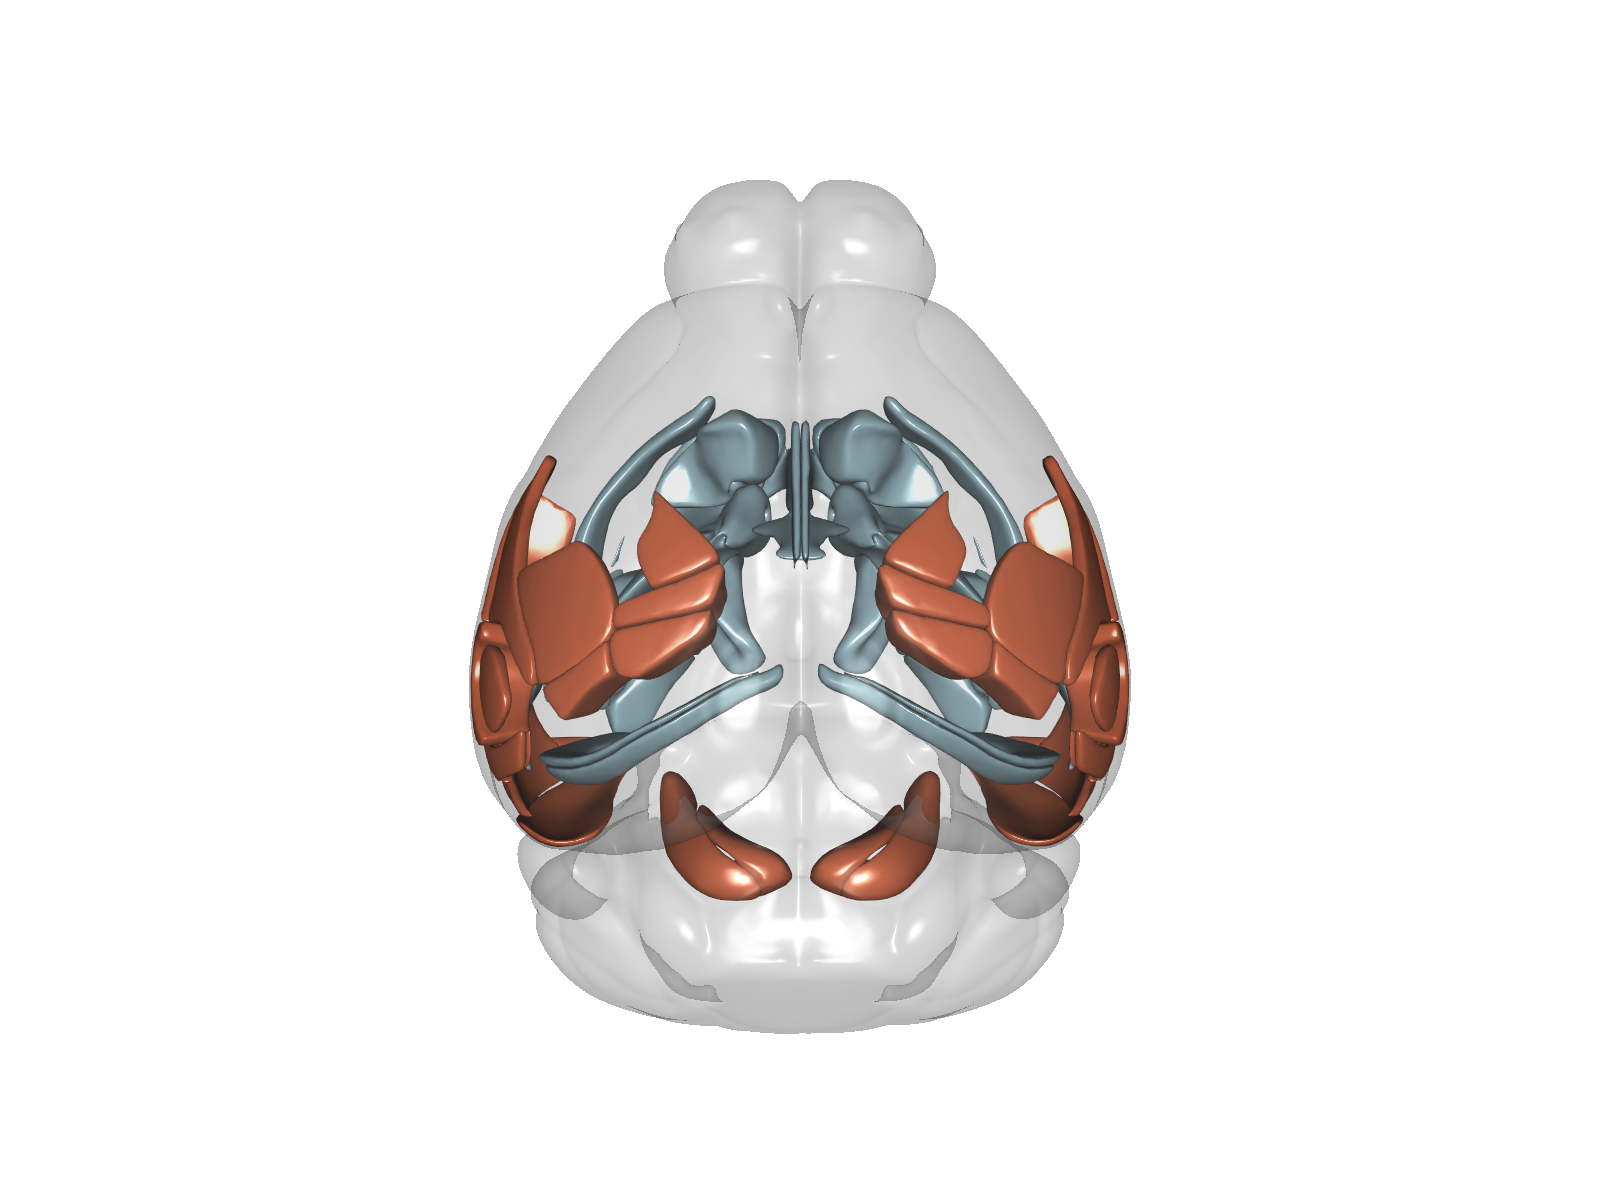

In [46]:
from myterial import salmon
brainrender.settings.SHADER_STYLE = "glossy"

get_acronym = lambda x: x.split(">")[-1]

def is_large_enough(acronym):
    volume = region_volumes[acronym]
    return volume >= volume_mm3_threshold

def is_grey(acronym):
    parents = atlas.get_structure_ancestors(acronym)
    return "grey" in parents

def structure_from_acronym(acronym):
    return ">".join(atlas.get_structure_ancestors(acronym) + [acronym])

def exclude_parents(acronyms):
    """
    Goes through the list of acronyms, and removes structures that are parents of other structures in this list.
    For example, if list contains both ACB and STR (STR being parent of ACB), this function will exclude ACB
    """
    acronyms_filtered = acronyms[:]
    for acronym in acronyms:
        parents = atlas.get_structure_ancestors(acronym)
        for parent in parents:
            if parent in acronyms_filtered:
                acronyms_filtered.remove(parent)
    return acronyms_filtered

######### read male only #########
morphine_dfs_male = []
saline_dfs_male = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'm':
        morphine_dfs_male.append(density_df)
    elif treatment == "saline" and sex == 'm':
        saline_dfs_male.append(density_df)
    else:
        pass

morphine_dfs_male = pd.concat(morphine_dfs_male)
assert morphine_dfs_male.shape[0] == 840 * 9

saline_dfs_male = pd.concat(saline_dfs_male)
assert saline_dfs_male.shape[0] == 840 * 6

morphine_dfs_male.sort_values(by='Structure', inplace=True)
saline_dfs_male.sort_values(by='Structure', inplace=True)

morphine_dfs_male.reset_index(drop=True, inplace=True)
saline_dfs_male.reset_index(drop=True, inplace=True)

######### read female only #########
morphine_dfs_female = []
saline_dfs_female = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'f':
        morphine_dfs_female.append(density_df)
    elif treatment == "saline" and sex == 'f':
        saline_dfs_female.append(density_df)
    else:
        pass

morphine_dfs_female = pd.concat(morphine_dfs_female)
assert morphine_dfs_female.shape[0] == 840 * 6

saline_dfs_female = pd.concat(saline_dfs_female)
assert saline_dfs_female.shape[0] == 840 * 6

morphine_dfs_female.sort_values(by='Structure', inplace=True)
saline_dfs_female.sort_values(by='Structure', inplace=True)

morphine_dfs_female.reset_index(drop=True, inplace=True)
saline_dfs_female.reset_index(drop=True, inplace=True)

structures = list(morphine_dfs_male['Structure'].unique())

filtered_structures = []
for structure in structures:
    acronym = get_acronym(structure)
    if is_grey(acronym) and is_large_enough(acronym):
        filtered_structures.append(structure)
print("Filtered structures", len(filtered_structures))

p_values_div = []
effect_male_over_female_div = []
effect_female_over_male_div = []
male_avg = []
female_avg = []

for structure in filtered_structures:
    avg_male_saline_count = np.mean(
        saline_dfs_male[saline_dfs_male['Structure'] == structure]['cell_count'].to_numpy())
    if avg_male_saline_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    all_male_morphine_count_values = morphine_dfs_male[morphine_dfs_male['Structure'] == structure][
        'cell_count'].to_numpy()
    avg_male_morphine_count = np.mean(all_male_morphine_count_values)
    if avg_male_morphine_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    normalized_male_morphine_count_values = all_male_morphine_count_values / avg_male_saline_count

    avg_female_saline_count = np.mean(
        saline_dfs_female[saline_dfs_female['Structure'] == structure]['cell_count'].to_numpy())
    if avg_female_saline_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    all_female_morphine_count_values = morphine_dfs_female[morphine_dfs_female['Structure'] == structure][
        'cell_count'].to_numpy()
    avg_female_morphine_count = np.mean(all_female_morphine_count_values)
    if avg_female_morphine_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    normalized_female_morphine_count_values = all_female_morphine_count_values / avg_female_saline_count

    p_val = get_p_value(normalized_male_morphine_count_values, normalized_female_morphine_count_values)
    effect1 = np.mean(normalized_male_morphine_count_values) / np.mean(normalized_female_morphine_count_values)
    effect_male_over_female_div.append(effect1)
    effect2 = np.mean(normalized_female_morphine_count_values) / np.mean(normalized_male_morphine_count_values)
    effect_female_over_male_div.append(effect2)
    male_avg.append(np.mean(normalized_male_morphine_count_values))
    female_avg.append(np.mean(normalized_female_morphine_count_values))
    p_values_div.append(p_val)

p_values_div = np.array(p_values_div)

df_male_female_normalized_division = pd.DataFrame()
df_male_female_normalized_division['structure'] = filtered_structures
df_male_female_normalized_division['p_value'] = p_values_div
df_male_female_normalized_division['male_avg'] = male_avg
df_male_female_normalized_division['female_avg'] = female_avg
df_male_female_normalized_division['effect'] = effect_male_over_female_div
df_male_female_normalized_division['effect_f_over_m'] = effect_female_over_male_div
df_male_female_normalized_division['log_effect'] = np.abs(np.log2(effect_male_over_female_div))
df_male_female_normalized_signif = df_male_female_normalized_division[df_male_female_normalized_division['p_value'] < 0.05]
print("Significant", df_male_female_normalized_signif.shape)
df_male_female_normalized_signif.sort_values('effect', ascending=False, inplace=True)
structures = list(map(get_acronym, df_male_female_normalized_signif['structure'].to_list()))
structures_no_parents = exclude_parents(structures)
print("Structures with parents excluded", len(structures_no_parents))
print("Structures with parents excluded", structures_no_parents)
structures_no_parents = list(map(structure_from_acronym, structures_no_parents))
df_male_female_normalized_signif_no_parents = df_male_female_normalized_signif[df_male_female_normalized_signif['structure'].isin(structures_no_parents)]
print("Structures with parents excluded DF", df_male_female_normalized_signif_no_parents.shape)

structures_male_higher = df_male_female_normalized_signif_no_parents[df_male_female_normalized_signif_no_parents['effect'] > 1]
structures_male_higher = structures_male_higher['structure'].to_list()
structures_male_higher = list(map(get_acronym, structures_male_higher))
print("Male higher", structures_male_higher)

structures_female_higher = df_male_female_normalized_signif_no_parents[df_male_female_normalized_signif_no_parents['effect'] < 1]
structures_female_higher = structures_female_higher['structure'].to_list()
structures_female_higher = list(map(get_acronym, structures_female_higher))
print("Female higher", structures_female_higher)

# # full brain
scene = CustomScene(atlas_name="allen_mouse_10um")
for structure in structures_male_higher:
    scene.add_brain_region(structure, color="lightblue")
for structure in structures_female_higher:
    scene.add_brain_region(structure, color=salmon)
scene.render(interactive=False, camera='top', zoom=1)
scene.screenshot(name="Male_vs_female_normalized_full_brain")

screenshot_path = "Male_vs_female_normalized_full_brain.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))


Saving new screenshot at Male_vs_female_normalized_sagittal_slice.png

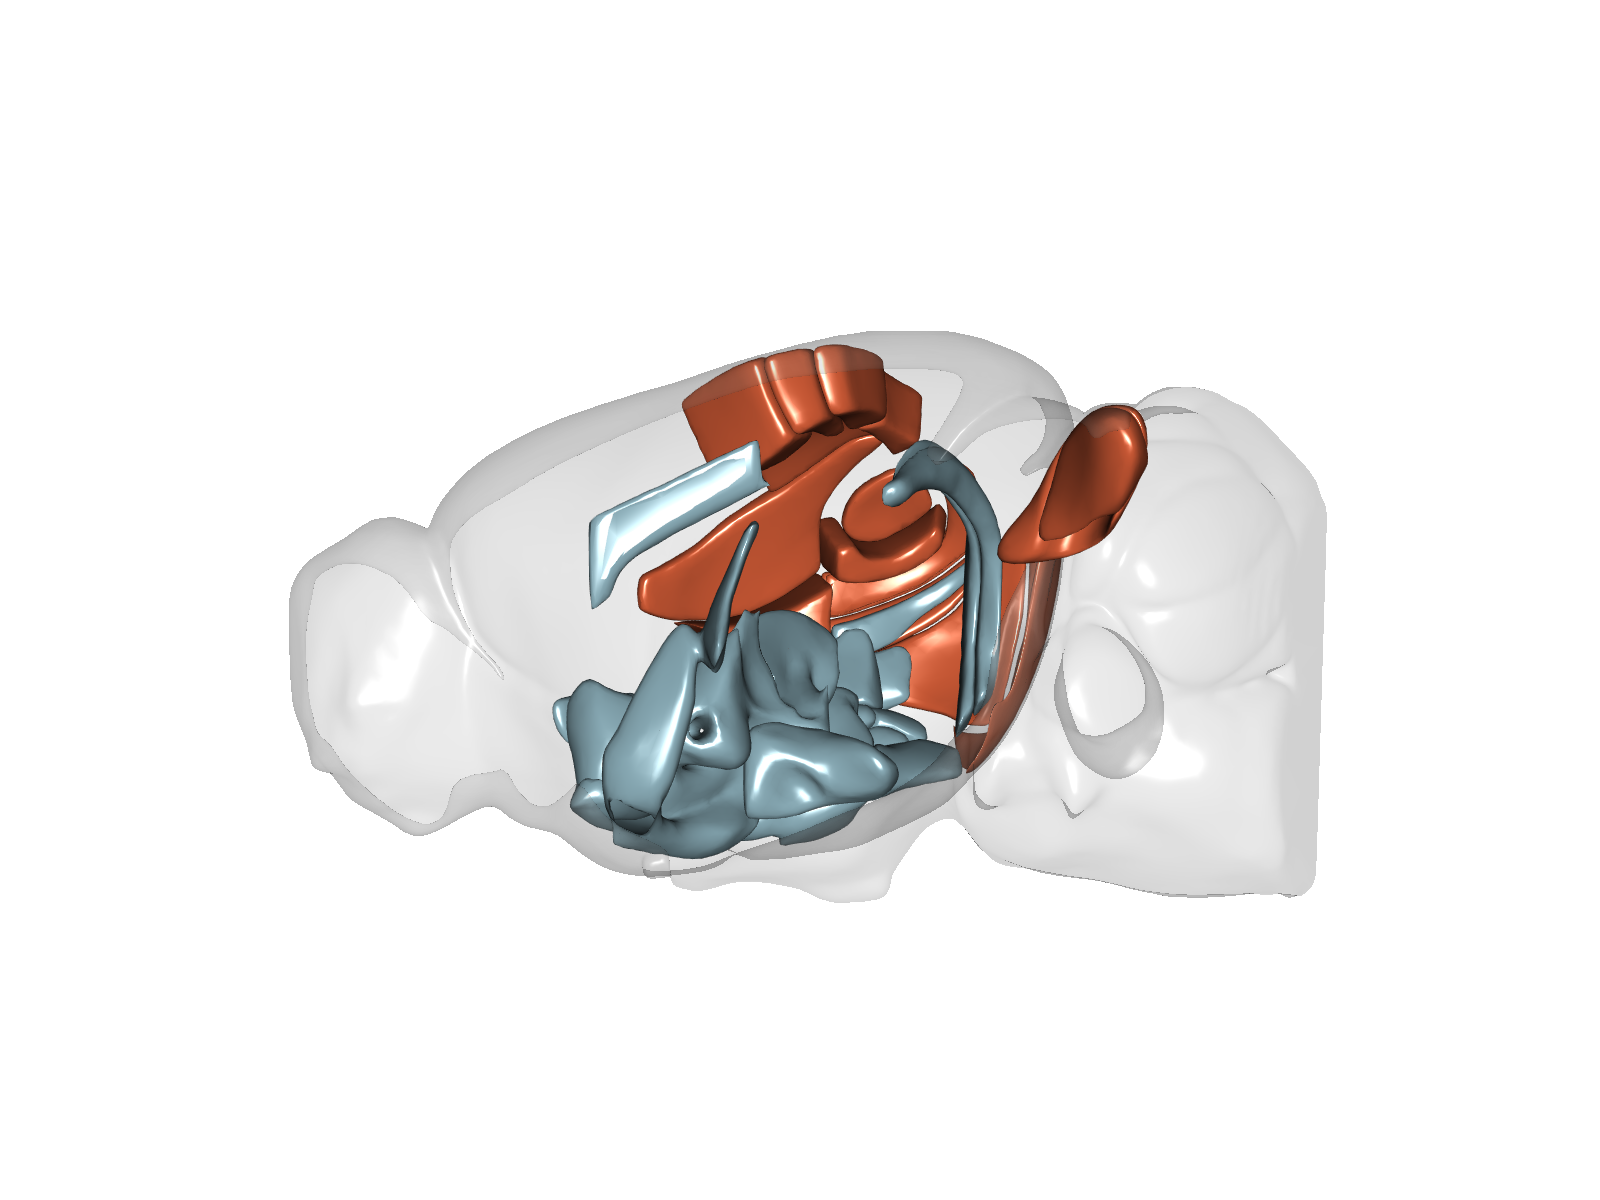

In [47]:
## sagittal slice
scene = CustomScene(atlas_name="allen_mouse_10um")
for structure in structures_male_higher:
    scene.add_brain_region(structure, color="lightblue")
for structure in structures_female_higher:
    scene.add_brain_region(structure, color=salmon)
scene.slice('sagittal')
custom_cam = {
    'pos': (6514, -34, -36854),
    'viewup': (0, -1, 0),
    'clipping_range': (29281, 60290),
}
scene.render(interactive=False, camera=custom_cam, zoom=1)
scene.screenshot(name="Male_vs_female_normalized_sagittal_slice")

screenshot_path = "Male_vs_female_normalized_sagittal_slice.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

Saving new screenshot at Male_vs_female_normalized_coronal_slice_STR.png

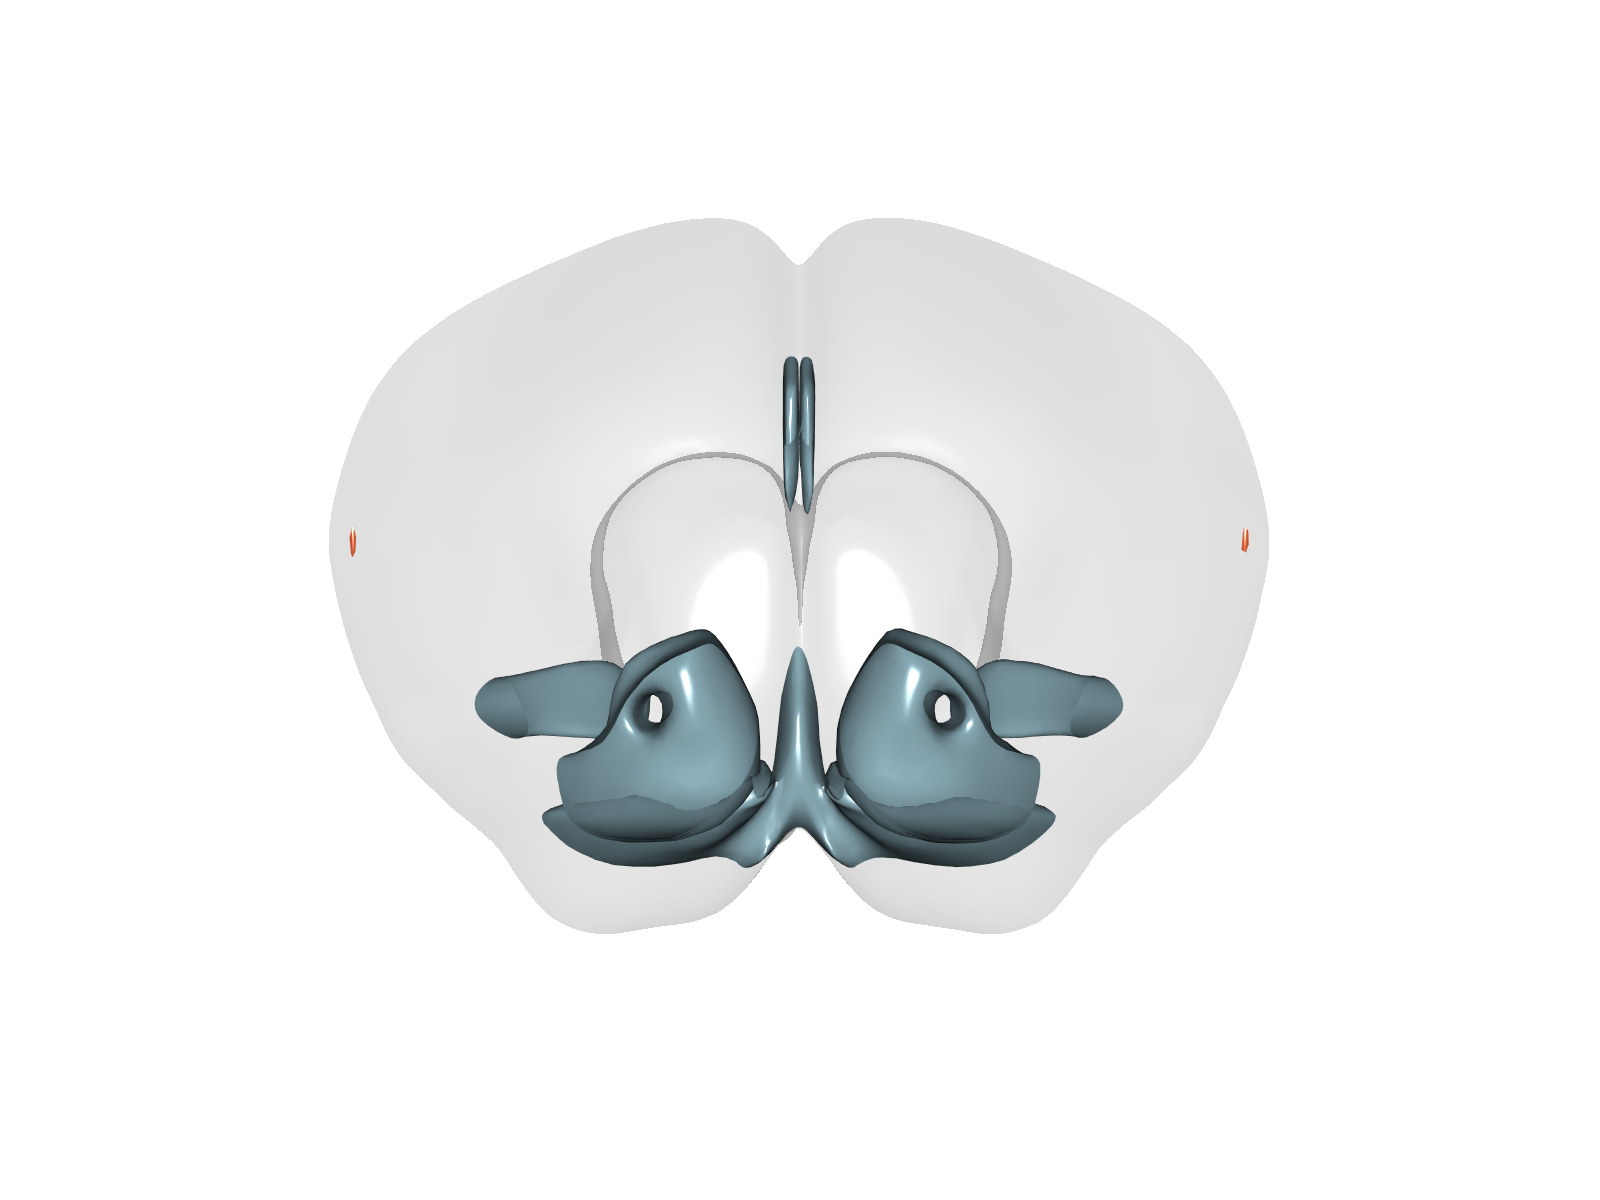

In [48]:
## coronal slice (striatum)
scene = CustomScene(atlas_name="allen_mouse_10um")
plane = scene.atlas.get_plane(pos=(430*10, 400*10, 570*10), norm=(-1, 0, 0))  # Striatum
for structure in structures_male_higher:
    scene.add_brain_region(structure, color="lightblue")
for structure in structures_female_higher:
    scene.add_brain_region(structure, color=salmon)
# scene.slice('sagittal')
# scene.slice(plane, close_actors=True)
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
# scene.render()
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="Male_vs_female_normalized_coronal_slice_STR")

screenshot_path = "Male_vs_female_normalized_coronal_slice_STR.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

Saving new screenshot at Male_vs_female_normalized_coronal_slice_AMYGDALA.png

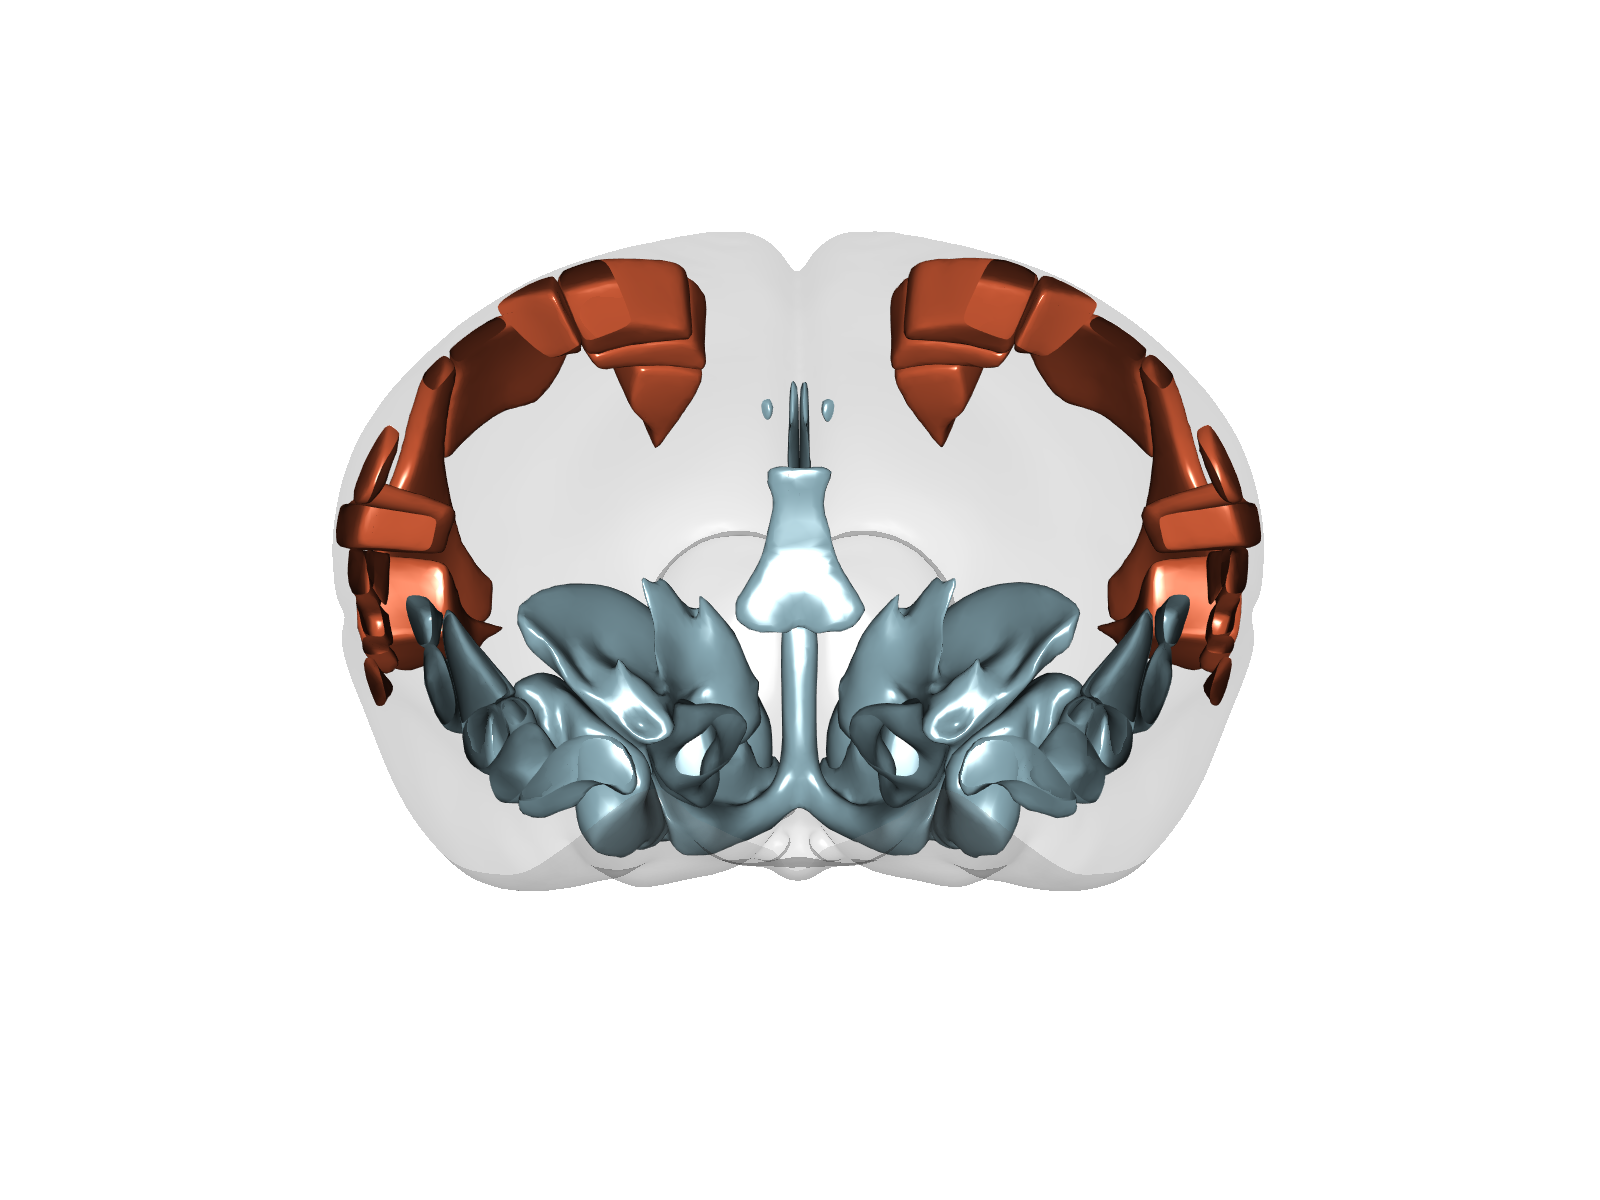

In [49]:
## coronal slice (amygdala)
scene = CustomScene(atlas_name="allen_mouse_10um")
plane = scene.atlas.get_plane(pos=(760*10, 400*10, 570*10), norm=(-1, 0, 0))  # HIP
for structure in structures_male_higher:
    scene.add_brain_region(structure, color="lightblue")
for structure in structures_female_higher:
    scene.add_brain_region(structure, color=salmon)
# scene.slice('sagittal')
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="Male_vs_female_normalized_coronal_slice_AMYGDALA")

screenshot_path = "Male_vs_female_normalized_coronal_slice_AMYGDALA.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

Saving new screenshot at Male_vs_female_normalized_coronal_slice_MB.png

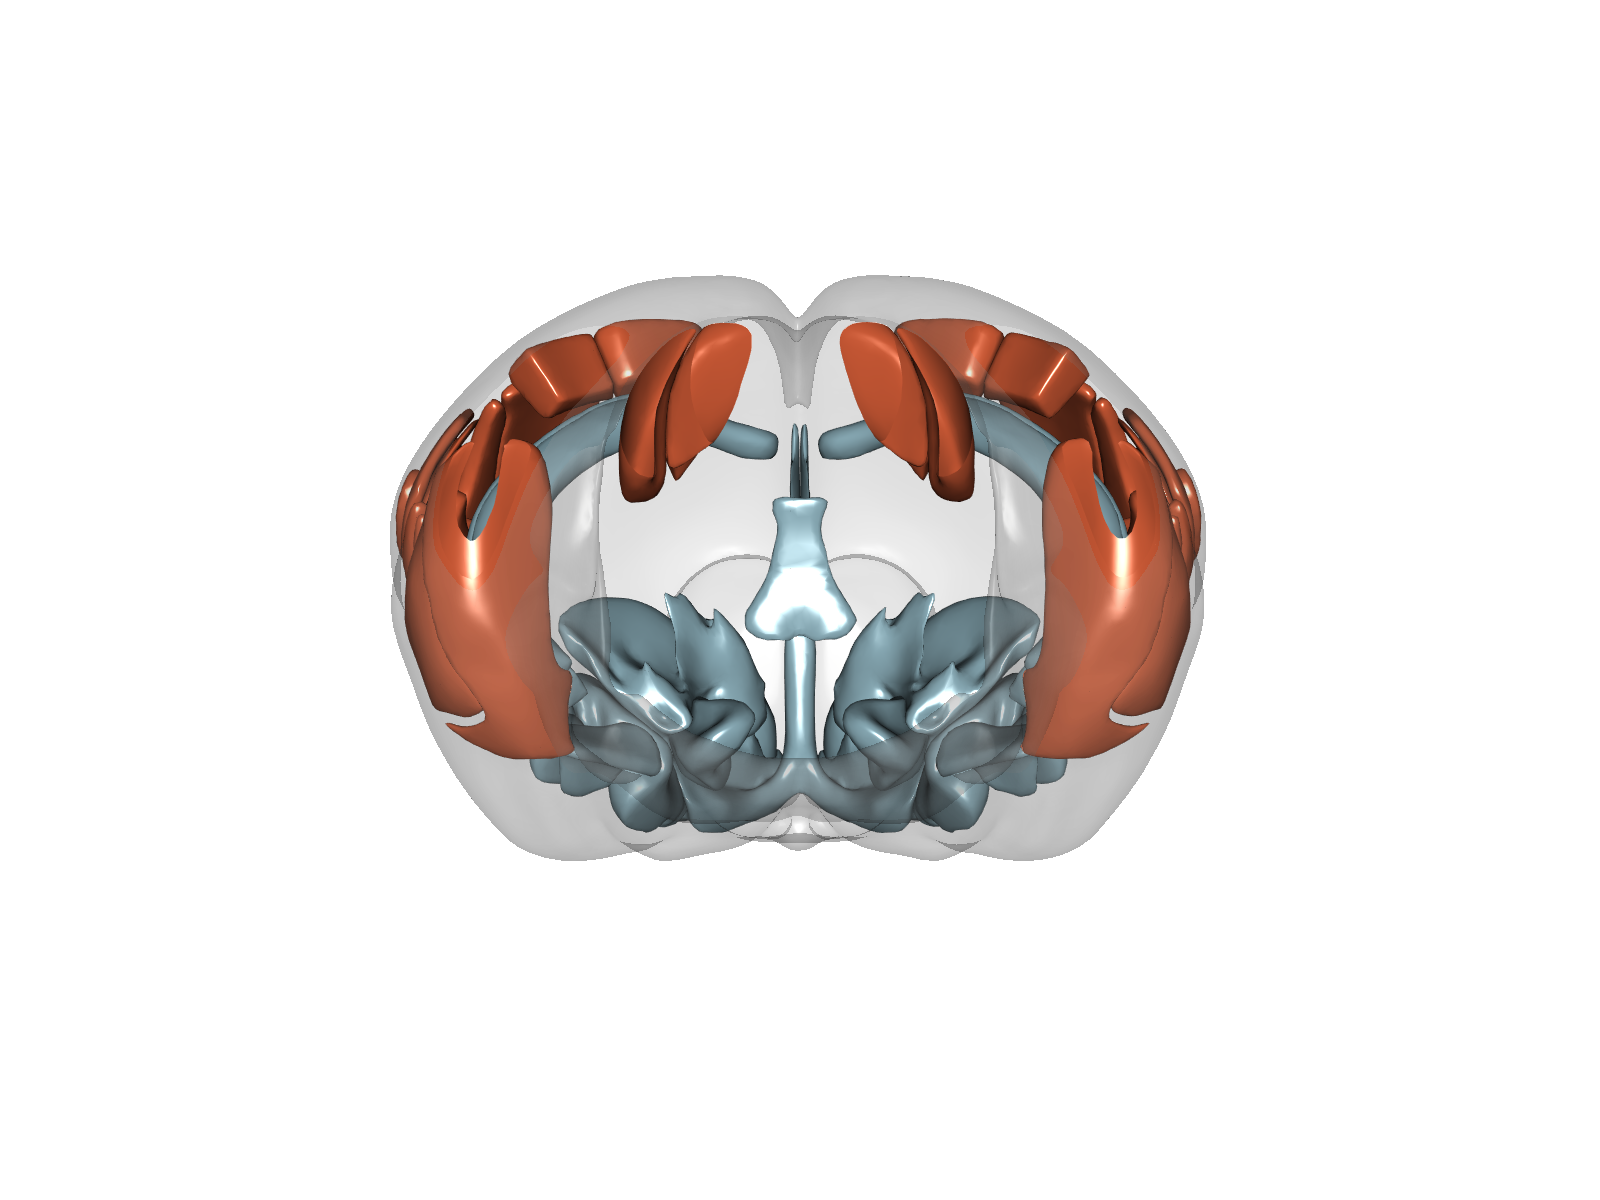

In [50]:
## coronal slice (Inferior Colliculus)
scene = CustomScene(atlas_name="allen_mouse_10um")
plane = scene.atlas.get_plane(pos=(1025*10, 400*10, 570*10), norm=(-1, 0, 0))
for structure in structures_male_higher:
    scene.add_brain_region(structure, color="lightblue")
for structure in structures_female_higher:
    scene.add_brain_region(structure, color=salmon)
# scene.slice('sagittal')
scene.slice(plane, close_actors=False)
cam = {
 'pos': (34550, 8612, -5463),
 'viewup': (0, -1, 0),
 'clipping_range': (27125, 39734),
 'focalPoint': (2248, 4424, -5688),
 'distance': 32573
}
# scene.render()
scene.render(interactive=False, camera=cam, zoom=1)
scene.screenshot(name="Male_vs_female_normalized_coronal_slice_MB")

screenshot_path = "Male_vs_female_normalized_coronal_slice_MB.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

## 4f

Structures with parents excluded 31
Structures with parents excluded ['ACB', 'LA', 'PAL', 'BLAa', 'BMAp', 'BLAp', 'sAMY', 'LHA', 'PA', 'EPd', 'ACAv1', 'ECT6a', 'SUB', 'ProS', 'AUDv', 'VISC', 'VISrl', 'ICd', 'SSp-ll', 'ENTl2', 'SSp-bfd2/3', 'ICe', 'TEa2/3', 'SSp-tr', 'VISa', 'PERI2/3', 'ECT2/3', 'SSs2/3', 'AUDp2/3', 'TEa4', 'ENTm1']


[Text(0.5, 0, 'structure'), Text(0, 0.5, 'fold-change')]

<Figure size 2016x576 with 1 Axes>

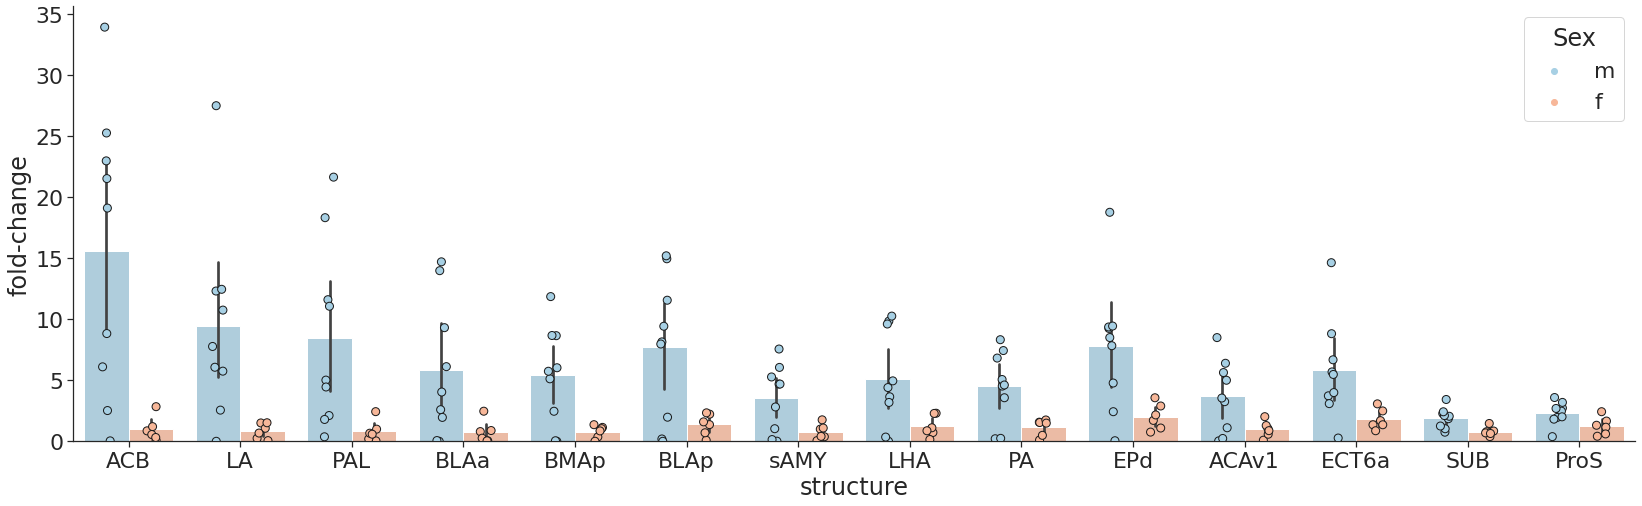

In [51]:
# normalization by division

p_values_div = []
effect_male_over_female_div = []
effect_female_over_male_div = []
male_avg = []
female_avg = []

for structure in filtered_structures:
    avg_male_saline_count = np.mean(saline_dfs_male[saline_dfs_male['Structure'] == structure]['cell_count'].to_numpy())
    if avg_male_saline_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    all_male_morphine_count_values = morphine_dfs_male[morphine_dfs_male['Structure'] == structure]['cell_count'].to_numpy()
    avg_male_morphine_count = np.mean(all_male_morphine_count_values)
    if avg_male_morphine_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    normalized_male_morphine_count_values = all_male_morphine_count_values / avg_male_saline_count

    avg_female_saline_count = np.mean(saline_dfs_female[saline_dfs_female['Structure'] == structure]['cell_count'].to_numpy())
    if avg_female_saline_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    all_female_morphine_count_values = morphine_dfs_female[morphine_dfs_female['Structure'] == structure]['cell_count'].to_numpy()
    avg_female_morphine_count = np.mean(all_female_morphine_count_values)
    if avg_female_morphine_count < min_cells:
        p_values_div.append(1)
        effect_male_over_female_div.append(0)
        effect_female_over_male_div.append(0)
        male_avg.append(0)
        female_avg.append(0)
        continue
    normalized_female_morphine_count_values = all_female_morphine_count_values / avg_female_saline_count
    
    p_val = get_p_value(normalized_male_morphine_count_values, normalized_female_morphine_count_values)
    effect1 = np.mean(normalized_male_morphine_count_values) / np.mean(normalized_female_morphine_count_values)
    effect_male_over_female_div.append(effect1)
    effect2 = np.mean(normalized_female_morphine_count_values) / np.mean(normalized_male_morphine_count_values)
    effect_female_over_male_div.append(effect2)
    male_avg.append(np.mean(normalized_male_morphine_count_values))
    female_avg.append(np.mean(normalized_female_morphine_count_values))
    p_values_div.append(p_val)

    
p_values_div = np.array(p_values_div)


df_male_female_normalized_division = pd.DataFrame()
df_male_female_normalized_division['structure'] = filtered_structures
df_male_female_normalized_division['p_value'] = p_values_div
df_male_female_normalized_division['male_avg'] = male_avg
df_male_female_normalized_division['female_avg'] = female_avg
df_male_female_normalized_division['effect'] = effect_male_over_female_div
df_male_female_normalized_division['effect_f_over_m'] = effect_female_over_male_div
df_male_female_normalized_division['log_effect'] = np.abs(np.log2(effect_male_over_female_div))
df_male_female_normalized_signif = df_male_female_normalized_division[df_male_female_normalized_division['p_value'] < 0.05]
df_male_female_normalized_signif.sort_values('log_effect', ascending=False, inplace=True)


df_male_female_normalized_signif.sort_values('effect', ascending=False, inplace=True)
structures = list(map(get_acronym, df_male_female_normalized_signif['structure'].to_list()))
structures_no_parents = exclude_parents(structures)
print("Structures with parents excluded", len(structures_no_parents))
print("Structures with parents excluded", structures_no_parents)
structures_no_parents = list(map(structure_from_acronym, structures_no_parents))

df_male_female_normalized_signif_no_parents = df_male_female_normalized_signif[df_male_female_normalized_signif['structure'].isin(structures_no_parents)]

structures_male_higher = df_male_female_normalized_signif_no_parents[df_male_female_normalized_signif_no_parents['effect'] > 1]
structures_male_higher = structures_male_higher['structure'].to_list()

structures_female_higher = df_male_female_normalized_signif_no_parents[df_male_female_normalized_signif_no_parents['effect'] < 1]
structures_female_higher = structures_female_higher['structure'].to_list()

structures_data_male = []
structures_data_female = []
for structure in structures_male_higher:
    avg_male_saline_count = np.mean(saline_dfs_male[saline_dfs_male['Structure'] == structure]['cell_count'].to_numpy())
    all_male_morphine_count_values = morphine_dfs_male[morphine_dfs_male['Structure'] == structure]['cell_count'].to_numpy()
    normalized_male_morphine_count_values = all_male_morphine_count_values / avg_male_saline_count
    structure_df_male = pd.DataFrame()
    structure_df_male['value'] = normalized_male_morphine_count_values
    structure_df_male['structure'] = [get_acronym(structure)] * len(normalized_male_morphine_count_values)
    structure_df_male['sex'] = ['m'] * len(normalized_male_morphine_count_values)
    structures_data_male.append(structure_df_male)

    avg_female_saline_count = np.mean(saline_dfs_female[saline_dfs_female['Structure'] == structure]['cell_count'].to_numpy())
    all_female_morphine_count_values = morphine_dfs_female[morphine_dfs_female['Structure'] == structure]['cell_count'].to_numpy()
    normalized_female_morphine_count_values = all_female_morphine_count_values / avg_female_saline_count   
    structure_df_female = pd.DataFrame()
    structure_df_female['value'] = normalized_female_morphine_count_values
    structure_df_female['structure'] = [get_acronym(structure)] * len(normalized_female_morphine_count_values)
    structure_df_female['sex'] = ['f'] * len(normalized_female_morphine_count_values)
    structures_data_female.append(structure_df_female)
    
structures_data_male = pd.concat(structures_data_male)
structures_data_female = pd.concat(structures_data_female)
structures_data_male_female = pd.concat([structures_data_male, structures_data_female])

palette = "RdBu_r"  # "GnBu"

sns.set_theme(font_scale=2, style="ticks", palette="pastel", rc={'figure.figsize':(28,8)})


ax = sns.barplot(x="structure", y="value", hue="sex", data=structures_data_male_female, palette=palette)

# add stripplot with dodge=True
sns.stripplot(x="structure", y="value", hue="sex", data=structures_data_male_female, palette=palette, dodge=True, ax=ax, s=8, edgecolor='k', linewidth=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Sex')
ax.set(xlabel="structure", ylabel="fold-change")


## 4g

[Text(0.5, 0, 'structure'), Text(0, 0.5, 'fold-change')]

<Figure size 2016x576 with 1 Axes>

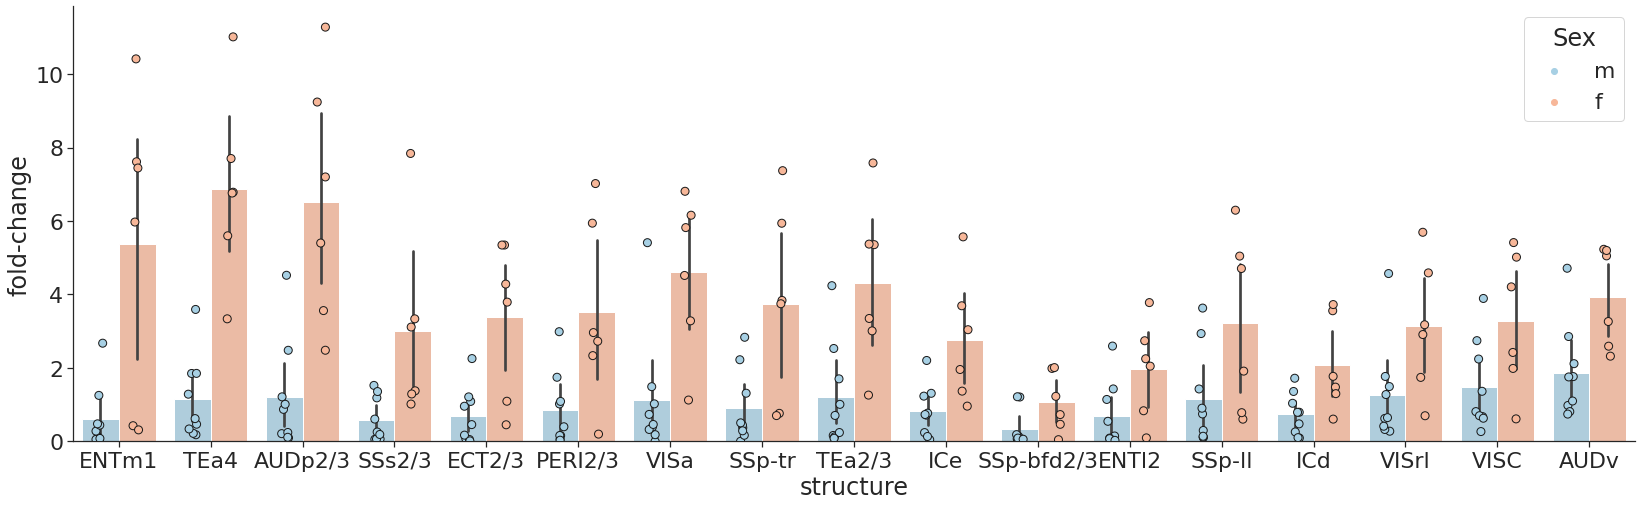

In [52]:
structures_data_male = []
structures_data_female = []
for structure in reversed(structures_female_higher):
    avg_male_saline_count = np.mean(saline_dfs_male[saline_dfs_male['Structure'] == structure]['cell_count'].to_numpy())
    all_male_morphine_count_values = morphine_dfs_male[morphine_dfs_male['Structure'] == structure]['cell_count'].to_numpy()
    normalized_male_morphine_count_values = all_male_morphine_count_values / avg_male_saline_count
    structure_df_male = pd.DataFrame()
    structure_df_male['value'] = normalized_male_morphine_count_values
    structure_df_male['structure'] = [get_acronym(structure)] * len(normalized_male_morphine_count_values)
    structure_df_male['sex'] = ['m'] * len(normalized_male_morphine_count_values)
    structures_data_male.append(structure_df_male)

    avg_female_saline_count = np.mean(saline_dfs_female[saline_dfs_female['Structure'] == structure]['cell_count'].to_numpy())
    all_female_morphine_count_values = morphine_dfs_female[morphine_dfs_female['Structure'] == structure]['cell_count'].to_numpy()
    normalized_female_morphine_count_values = all_female_morphine_count_values / avg_female_saline_count   
    structure_df_female = pd.DataFrame()
    structure_df_female['value'] = normalized_female_morphine_count_values
    structure_df_female['structure'] = [get_acronym(structure)] * len(normalized_female_morphine_count_values)
    structure_df_female['sex'] = ['f'] * len(normalized_female_morphine_count_values)
    structures_data_female.append(structure_df_female)
    
structures_data_male = pd.concat(structures_data_male)
structures_data_female = pd.concat(structures_data_female)
structures_data_male_female = pd.concat([structures_data_male, structures_data_female])

palette = "RdBu_r"

sns.set_theme(font_scale=2, style="ticks", palette="pastel", rc={'figure.figsize':(28,8)})

ax = sns.barplot(x="structure", y="value", hue="sex", data=structures_data_male_female, palette=palette)

# add stripplot with dodge=True
sns.stripplot(x="structure", y="value", hue="sex", data=structures_data_male_female, palette=palette, dodge=True, ax=ax, s=8, edgecolor='k', linewidth=1)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# remove extra legend handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Sex')
ax.set(xlabel="structure", ylabel="fold-change")


# Figure 5 <a id="fig5"/>

## 5a

In [53]:
def get_all_morphine_over_all_saline_density_ratio_df(all_dfs):
    # split dfs into morphine and saline
    morphine_dfs = []
    saline_dfs = []
    for df_path in all_dfs:
        df_path_dict = density_dfs[df_path]
        density_df = df_path_dict["df"]
        treatment = df_path_dict['treatment']
        if treatment == "morphine":
            morphine_dfs.append(density_df)
        elif treatment == "saline":
            saline_dfs.append(density_df)

    # create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
    morphine_dfs = pd.concat(morphine_dfs)
    assert morphine_dfs.shape[0] == 840 * 15

    saline_dfs = pd.concat(saline_dfs)
    assert saline_dfs.shape[0] == 840 * 12

    morphine_dfs.sort_values(by='Structure', inplace=True)
    saline_dfs.sort_values(by='Structure', inplace=True)
    morphine_dfs.reset_index(drop=True, inplace=True)
    saline_dfs.reset_index(drop=True, inplace=True)

    morphine_average_density_df = morphine_dfs.groupby('Structure')['density'].mean().reset_index()
    saline_average_density_df = saline_dfs.groupby('Structure')['density'].mean().reset_index()

    merged_df = pd.merge(morphine_average_density_df, saline_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))
    merged_df = merged_df[merged_df['density_saline'] > 0]
    merged_df['density_ratio'] = merged_df['density_morphine'] / merged_df['density_saline']

    density_ratio_df = merged_df[['Structure', 'density_ratio']]

    get_acronym = lambda x: x.split(">")[-1]
    density_ratio_df['acronym'] = list(map(get_acronym, density_ratio_df['Structure'].to_list()))
    density_ratio_df['log_density_ratio'] = np.log2(density_ratio_df['density_ratio'].to_numpy())

    # calculate p-values for every structure
    p_values = []
    significance = []
    for structure in density_ratio_df['Structure'].to_list():
        morphine_dataset = morphine_dfs[morphine_dfs['Structure'] == structure]['density'].to_list()
        assert len(morphine_dataset) == 15
        saline_dataset = saline_dfs[saline_dfs['Structure'] == structure]['density'].to_list()
        assert len(saline_dataset) == 12
        p_val = get_p_value(morphine_dataset, saline_dataset)
        signif = p_val <= significance_threshold
        p_values.append(p_val)
        significance.append(signif)

    density_ratio_df['p_value'] = p_values
    density_ratio_df['significant'] = significance

    return density_ratio_df


def get_morphine_saline_average_cell_count_dfs(all_dfs):
    morphine_dfs = []
    saline_dfs = []
    for df_path in all_dfs:
        df_path_dict = density_dfs[df_path]
        density_df = df_path_dict["df"]
        treatment = df_path_dict['treatment']

        if treatment == "morphine":
            morphine_dfs.append(density_df)
        elif treatment == "saline":
            saline_dfs.append(density_df)

    # create merged dfs (with repeating structures) - 1 for morphine, 1 for saline
    morphine_dfs = pd.concat(morphine_dfs)
    assert morphine_dfs.shape[0] == 840 * 15

    saline_dfs = pd.concat(saline_dfs)
    assert saline_dfs.shape[0] == 840 * 12

    morphine_dfs.sort_values(by='Structure', inplace=True)
    saline_dfs.sort_values(by='Structure', inplace=True)
    morphine_dfs.reset_index(drop=True, inplace=True)
    saline_dfs.reset_index(drop=True, inplace=True)

    morphine_average_cell_count_df = morphine_dfs.groupby('Structure')['cell_count'].mean().reset_index()
    saline_average_cell_count_df = saline_dfs.groupby('Structure')['cell_count'].mean().reset_index()
    morphine_average_cell_count_df['acronym'] = list(
        map(get_acronym, morphine_average_cell_count_df['Structure'].to_list())
    )
    saline_average_cell_count_df['acronym'] = list(
        map(get_acronym, saline_average_cell_count_df['Structure'].to_list())
    )
    return morphine_average_cell_count_df, saline_average_cell_count_df



In [54]:
def structure_from_acronym(acronym):
    return ">".join(atlas.get_structure_ancestors(acronym) + [acronym])

47
Min 0.6769359653631903 Max 3.797012977836145


Saving new screenshot at significant_structures_All_M_vs_S.png

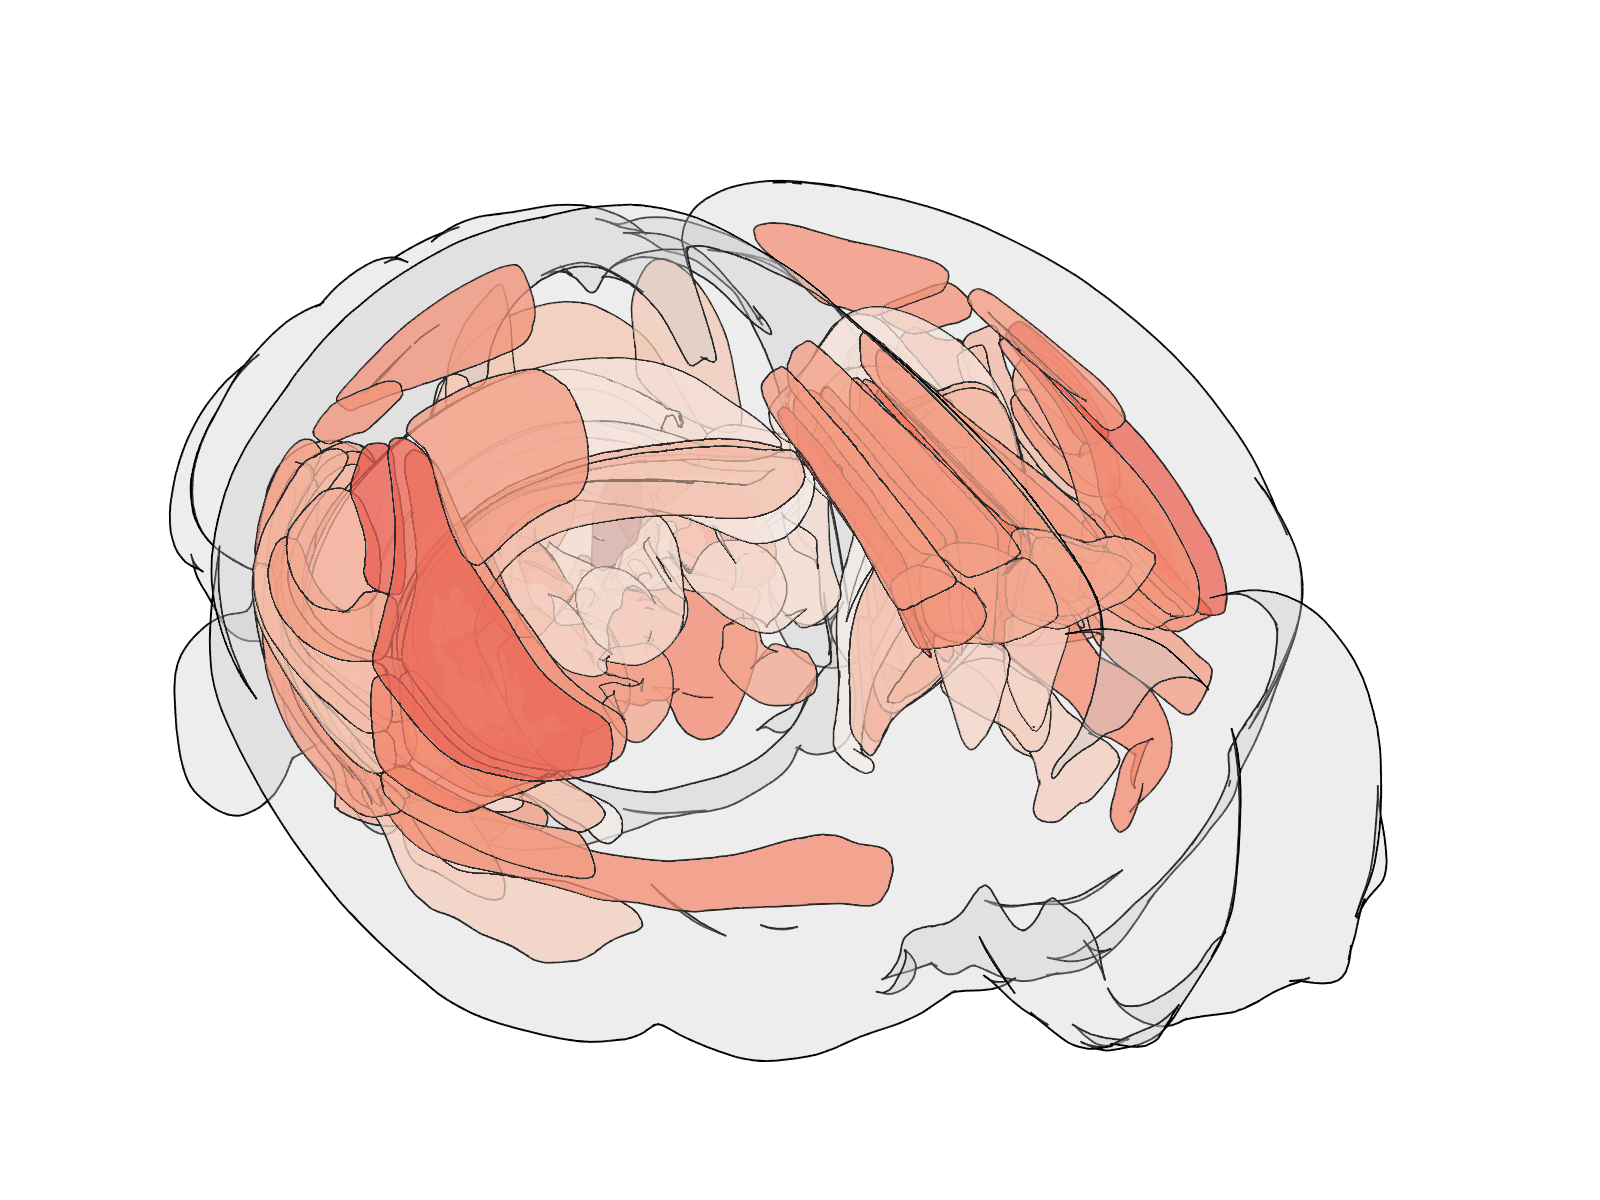

In [55]:
brainrender.settings.SHADER_STYLE = "cartoon"

alpha = 0.5

density_ratio_df = get_all_morphine_over_all_saline_density_ratio_df(all_dfs)

density_ratio_df['acronym'] = list(map(get_acronym, density_ratio_df['Structure'].to_list()))

morphine_average_cell_count_df, saline_average_cell_count_df = get_morphine_saline_average_cell_count_dfs(all_dfs)

significant_structures = density_ratio_df[density_ratio_df['significant'] == True]['acronym'].to_list()
filtered_significant_structures = [
    x for x in significant_structures if
    is_large_enough(x)
    and is_grey(x)
    and both_above_threshold(structure_from_acronym(x), morphine_average_cell_count_df, saline_average_cell_count_df)
]
filtered_significant_structures.append('DR')  # too small but significant everywhere
filtered_significant_structures_no_parents = exclude_parents(filtered_significant_structures)

density_ratio_df = density_ratio_df[density_ratio_df['acronym'].isin(filtered_significant_structures_no_parents)]
print(density_ratio_df.shape[0])
scale_max = np.max(np.abs(density_ratio_df['log_density_ratio'].to_numpy()))
scale_min = np.min(np.abs(density_ratio_df['log_density_ratio'].to_numpy()))
print("Min", scale_min, "Max", scale_max)

scene = CustomScene(inset=False)

for i, row in density_ratio_df.iterrows():
    region = row['acronym']
    log_density_ratio = row['log_density_ratio']
#     print("region", region, "log ratio", log_density_ratio)
    scene.add_brain_region(
        region,
        alpha=alpha,
        color=map_color(log_density_ratio, vmin=scale_min, vmax=scale_max,
                        name="Reds")
    )
scene.render(interactive=False)
scene.screenshot(name=f"significant_structures_All_M_vs_S")

screenshot_path = "significant_structures_All_M_vs_S.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

## 5b

Structures with significant difference: 13
Min 1.381494453484224 Max 5.8137811912170365


Saving new screenshot at significant_structures_1h_M_vs_S.png

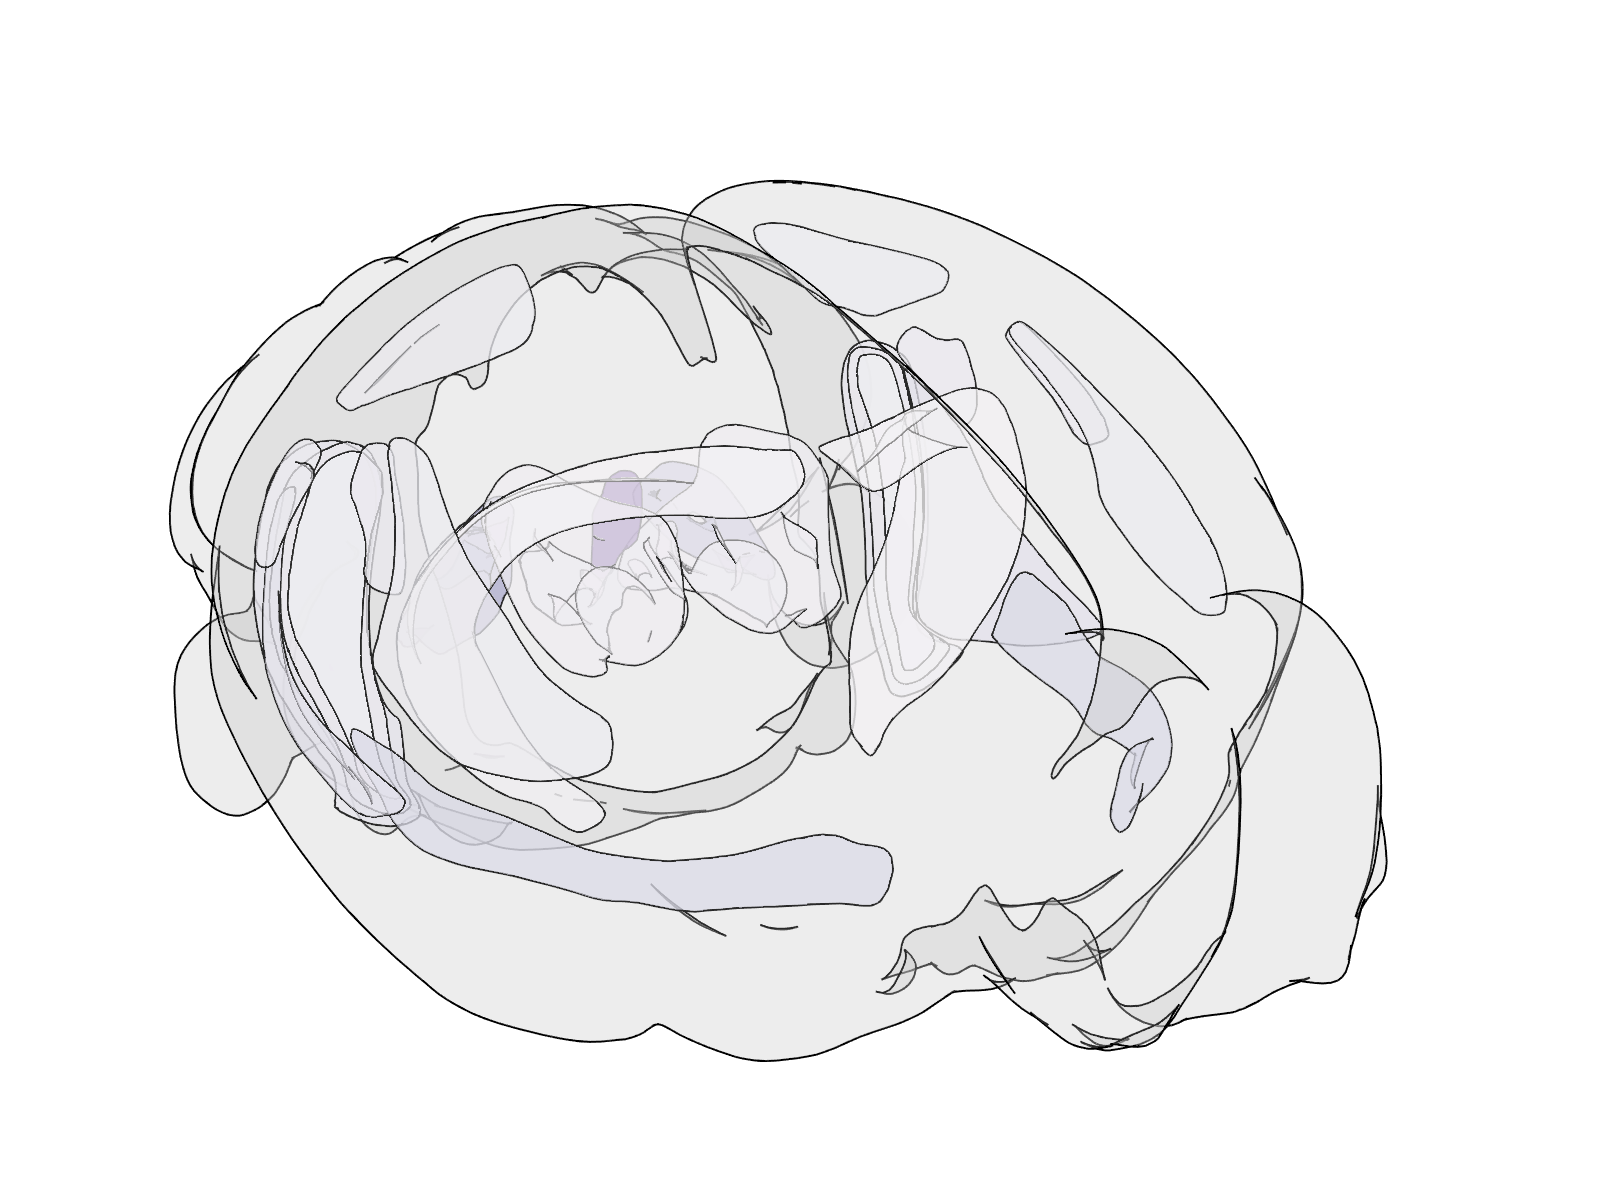

In [56]:
alpha = 0.5

morphine_dfs_1h = []
saline_dfs_1h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 1:
        morphine_dfs_1h.append(density_df)
    elif treatment == "saline" and time_point == 1:
        saline_dfs_1h.append(density_df)
    else:
        pass

morphine_dfs_1h = pd.concat(morphine_dfs_1h)
assert morphine_dfs_1h.shape[0] == 840 * 8

saline_dfs_1h = pd.concat(saline_dfs_1h)
assert saline_dfs_1h.shape[0] == 840 * 5

morphine_dfs_1h.sort_values(by='Structure', inplace=True)
saline_dfs_1h.sort_values(by='Structure', inplace=True)

morphine_dfs_1h.reset_index(drop=True, inplace=True)
saline_dfs_1h.reset_index(drop=True, inplace=True)

morphine_1h_average_density_df = morphine_dfs_1h.groupby('Structure')['density'].mean().reset_index()
saline_1h_average_density_df = saline_dfs_1h.groupby('Structure')['density'].mean().reset_index()

morphine_1h_average_density_df['acronym'] = list(
    map(get_acronym, morphine_1h_average_density_df['Structure'].to_list()))
saline_1h_average_density_df['acronym'] = list(
    map(get_acronym, saline_1h_average_density_df['Structure'].to_list()))

morphine_average_cell_count_df_1h = morphine_dfs_1h.groupby('Structure')['cell_count'].mean().reset_index()
saline_average_cell_count_df_1h = saline_dfs_1h.groupby('Structure')['cell_count'].mean().reset_index()
morphine_average_cell_count_df_1h['acronym'] = list(
    map(get_acronym, morphine_average_cell_count_df_1h['Structure'].to_list()))
saline_average_cell_count_df_1h['acronym'] = list(
    map(get_acronym, saline_average_cell_count_df_1h['Structure'].to_list()))

merged_df_1h = pd.merge(morphine_1h_average_density_df, saline_1h_average_density_df, on='Structure',
                        suffixes=('_morphine', '_saline'))

merged_df_1h = merged_df_1h[merged_df_1h['density_saline'] > 0]  # TODO: how do we deal with binary effects?

merged_df_1h['density_ratio'] = merged_df_1h['density_morphine'] / merged_df_1h['density_saline']

density_ratio_df_1h = merged_df_1h[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_1h['Structure'].to_list():
    morphine_dataset = morphine_dfs_1h[morphine_dfs_1h['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset) == 8
    saline_dataset = saline_dfs_1h[saline_dfs_1h['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset) == 5
    p_val = get_p_value(morphine_dataset, saline_dataset)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_1h['p_value'] = p_values
density_ratio_df_1h['significant'] = significance

density_ratio_df_1h['acronym'] = list(map(get_acronym, density_ratio_df_1h['Structure'].to_list()))
density_ratio_df_1h['log_density_ratio'] = np.log2(density_ratio_df_1h['density_ratio'].to_numpy())

significant_structures_1h = density_ratio_df_1h[density_ratio_df_1h['significant'] == True]['acronym'].to_list()

filtered_significant_structures_1h = [
    x for x in significant_structures_1h if
    is_large_enough(x)
    and is_grey(x)
    and both_above_threshold(structure_from_acronym(x), morphine_average_cell_count_df_1h, saline_average_cell_count_df_1h)
]

filtered_significant_structures_1h.append("DR")  # too small but significant everywhere

filtered_significant_structures_no_parents_1h = exclude_parents(filtered_significant_structures_1h)
print("Structures with significant difference:", len(filtered_significant_structures_no_parents_1h))

density_ratio_df_1h_significant = density_ratio_df_1h[density_ratio_df_1h['acronym'].isin(filtered_significant_structures_no_parents_1h)]

scale_max = np.max(np.abs(density_ratio_df_1h_significant['log_density_ratio'].to_numpy()))
scale_min = np.min(np.abs(density_ratio_df_1h_significant['log_density_ratio'].to_numpy()))
print("Min", scale_min, "Max", scale_max)

scene = CustomScene(inset=False)

for i, row in density_ratio_df_1h_significant.iterrows():
    region = row['acronym']
    log_density_ratio = row['log_density_ratio']
#     print("region", region, "log ratio", log_density_ratio)
    scene.add_brain_region(
        region,
        alpha=alpha,
        color=map_color(log_density_ratio, vmin=scale_min, vmax=scale_max,
                        name="Purples")
    )
scene.render(interactive=False)
scene.screenshot(name=f"significant_structures_1h_M_vs_S")    

screenshot_path = "significant_structures_1h_M_vs_S.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

## 5c

Structures with significant difference: 35
35
Min 1.1567895992531783 Max 3.921767357803674


Saving new screenshot at significant_structures_4h_M_vs_S.png

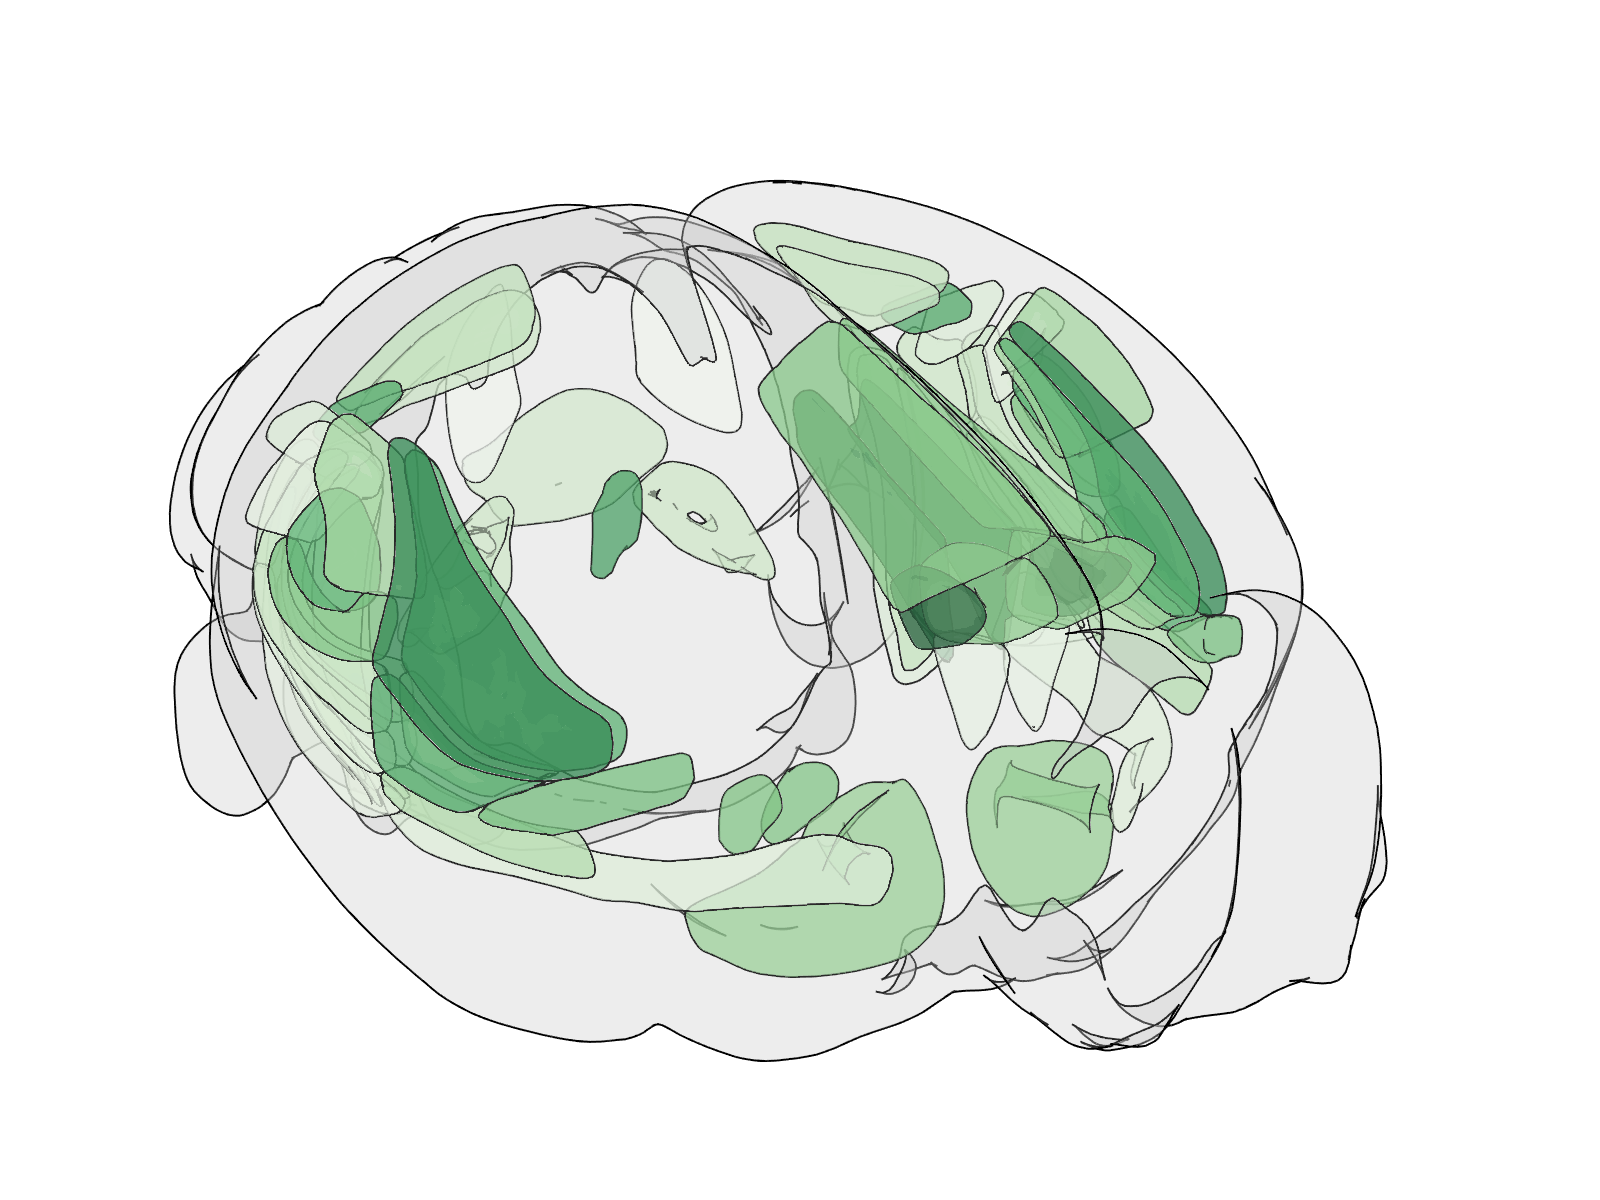

In [57]:
alpha = 0.5

morphine_dfs_4h = []
saline_dfs_4h = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    time_point = df_path_dict['time_point']
    if treatment == "morphine" and time_point == 4:
        morphine_dfs_4h.append(density_df)
    elif treatment == "saline" and time_point == 4:
        saline_dfs_4h.append(density_df)
    else:
        pass

morphine_dfs_4h = pd.concat(morphine_dfs_4h)
assert morphine_dfs_4h.shape[0] == 840 * 7

saline_dfs_4h = pd.concat(saline_dfs_4h)
assert saline_dfs_4h.shape[0] == 840 * 7

morphine_dfs_4h.sort_values(by='Structure', inplace=True)
saline_dfs_4h.sort_values(by='Structure', inplace=True)

morphine_dfs_4h.reset_index(drop=True, inplace=True)
saline_dfs_4h.reset_index(drop=True, inplace=True)

morphine_4h_average_density_df = morphine_dfs_4h.groupby('Structure')['density'].mean().reset_index()
saline_4h_average_density_df = saline_dfs_4h.groupby('Structure')['density'].mean().reset_index()

morphine_4h_average_density_df['acronym'] = list(map(get_acronym, morphine_4h_average_density_df['Structure'].to_list()))
saline_4h_average_density_df['acronym'] = list(map(get_acronym, saline_4h_average_density_df['Structure'].to_list()))

morphine_average_cell_count_df_4h = morphine_dfs_4h.groupby('Structure')['cell_count'].mean().reset_index()
saline_average_cell_count_df_4h = saline_dfs_4h.groupby('Structure')['cell_count'].mean().reset_index()
morphine_average_cell_count_df_4h['acronym'] = list(map(get_acronym, morphine_average_cell_count_df_4h['Structure'].to_list()))
saline_average_cell_count_df_4h['acronym'] = list(map(get_acronym, saline_average_cell_count_df_4h['Structure'].to_list()))

merged_df_4h = pd.merge(morphine_4h_average_density_df, saline_4h_average_density_df, on='Structure', suffixes=('_morphine', '_saline'))

merged_df_4h = merged_df_4h[merged_df_4h['density_saline'] > 0]

merged_df_4h['density_ratio'] = merged_df_4h['density_morphine'] / merged_df_4h['density_saline']

density_ratio_df_4h = merged_df_4h[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_4h['Structure'].to_list():
    morphine_dataset = morphine_dfs_4h[morphine_dfs_4h['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset) == 7
    saline_dataset = saline_dfs_4h[saline_dfs_4h['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset) == 7
    p_val = get_p_value(morphine_dataset, saline_dataset)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_4h['p_value'] = p_values
density_ratio_df_4h['significant'] = significance

density_ratio_df_4h['acronym'] = list(map(get_acronym, density_ratio_df_4h['Structure'].to_list()))
density_ratio_df_4h['log_density_ratio'] = np.log2(density_ratio_df_4h['density_ratio'].to_numpy())


significant_structures_4h = density_ratio_df_4h[density_ratio_df_4h['significant'] == True]['acronym'].to_list()

filtered_significant_structures_4h = [
    x for x in significant_structures_4h if
    is_large_enough(x)
    and is_grey(x)
    and both_above_threshold(structure_from_acronym(x), morphine_average_cell_count_df_4h, saline_average_cell_count_df_4h)
]

filtered_significant_structures_4h.append('DR')  # too small but significant everywhere

filtered_significant_structures_no_parents_4h = exclude_parents(filtered_significant_structures_4h)
print("Structures with significant difference:", len(filtered_significant_structures_no_parents_4h))

density_ratio_df_4h_significant = density_ratio_df_4h[density_ratio_df_4h['acronym'].isin(filtered_significant_structures_no_parents_4h)]

print(density_ratio_df_4h_significant.shape[0])
scale_max = np.max(np.abs(density_ratio_df_4h_significant['log_density_ratio'].to_numpy()))
scale_min = np.min(np.abs(density_ratio_df_4h_significant['log_density_ratio'].to_numpy()))
print("Min", scale_min, "Max", scale_max)


scene = CustomScene(inset=False)

for i, row in density_ratio_df_4h_significant.iterrows():
    region = row['acronym']
    log_density_ratio = row['log_density_ratio']
#     print("region", region, "log ratio", log_density_ratio)
    scene.add_brain_region(
        region,
        alpha=alpha,
        color=map_color(log_density_ratio, vmin=scale_min, vmax=scale_max,
                        name="Greens")
    )
scene.render(interactive=False)
scene.screenshot(name=f"significant_structures_4h_M_vs_S")

screenshot_path = "significant_structures_4h_M_vs_S.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

## 5d

Structures with significant difference: 33
Min 0.9320010691199896 Max 3.9632954067196695


Saving new screenshot at significant_structures_male_M_vs_S.png

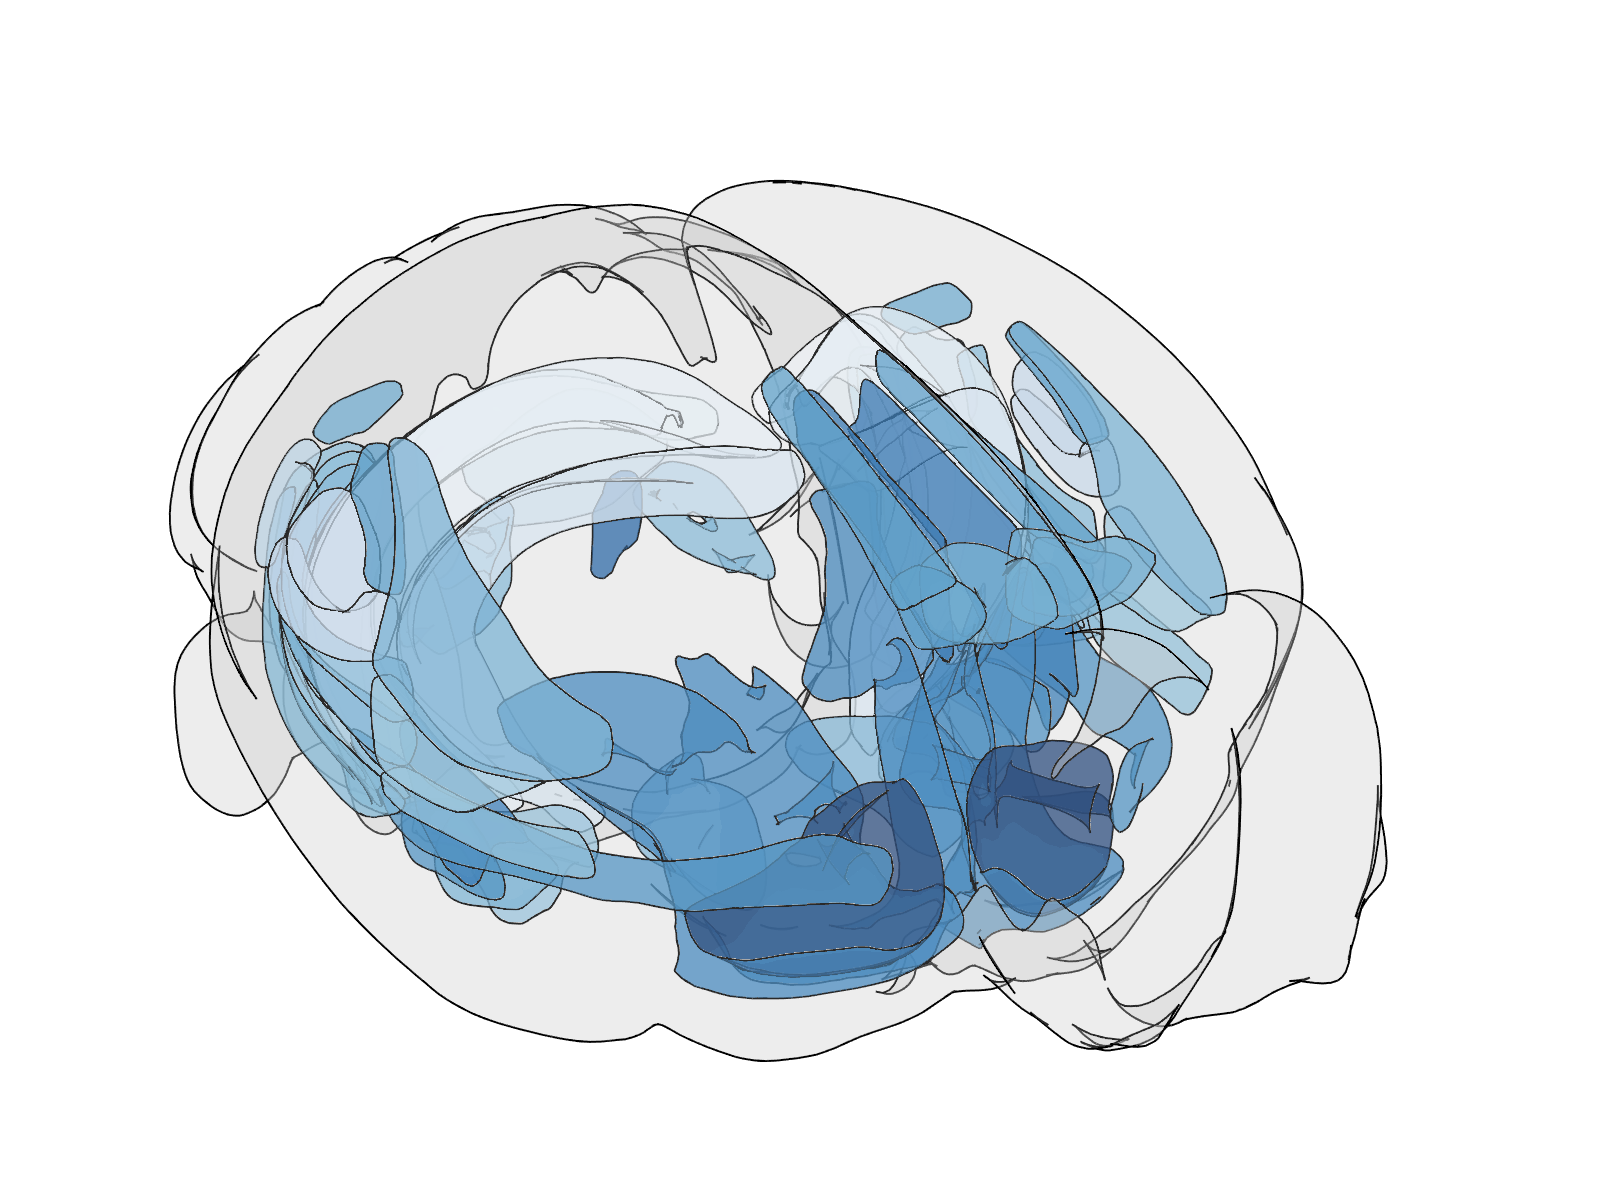

In [58]:
alpha = 0.5

morphine_dfs_male = []
saline_dfs_male = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'm':
        morphine_dfs_male.append(density_df)
    elif treatment == "saline" and sex == 'm':
        saline_dfs_male.append(density_df)
    else:
        pass

morphine_dfs_male = pd.concat(morphine_dfs_male)
assert morphine_dfs_male.shape[0] == 840 * 9

saline_dfs_male = pd.concat(saline_dfs_male)
assert saline_dfs_male.shape[0] == 840 * 6

morphine_dfs_male.sort_values(by='Structure', inplace=True)
saline_dfs_male.sort_values(by='Structure', inplace=True)

morphine_dfs_male.reset_index(drop=True, inplace=True)
saline_dfs_male.reset_index(drop=True, inplace=True)

morphine_male_average_density_df = morphine_dfs_male.groupby('Structure')['density'].mean().reset_index()
saline_male_average_density_df = saline_dfs_male.groupby('Structure')['density'].mean().reset_index()

morphine_male_average_density_df['acronym'] = list(
    map(get_acronym, morphine_male_average_density_df['Structure'].to_list()))
saline_male_average_density_df['acronym'] = list(
    map(get_acronym, saline_male_average_density_df['Structure'].to_list()))

morphine_average_cell_count_df_male = morphine_dfs_male.groupby('Structure')['cell_count'].mean().reset_index()
saline_average_cell_count_df_male = saline_dfs_male.groupby('Structure')['cell_count'].mean().reset_index()
morphine_average_cell_count_df_male['acronym'] = list(
    map(get_acronym, morphine_average_cell_count_df_male['Structure'].to_list()))
saline_average_cell_count_df_male['acronym'] = list(
    map(get_acronym, saline_average_cell_count_df_male['Structure'].to_list()))

merged_df_male = pd.merge(morphine_male_average_density_df, saline_male_average_density_df, on='Structure',
                          suffixes=('_morphine', '_saline'))

merged_df_male = merged_df_male[merged_df_male['density_saline'] > 0]
merged_df_male = merged_df_male[merged_df_male['density_morphine'] > 0]

merged_df_male['density_ratio'] = merged_df_male['density_morphine'] / merged_df_male['density_saline']

density_ratio_df_male = merged_df_male[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_male['Structure'].to_list():
    morphine_dataset_m = morphine_dfs_male[morphine_dfs_male['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset_m) == 9
    saline_dataset_m = saline_dfs_male[saline_dfs_male['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset_m) == 6
    p_val = get_p_value(morphine_dataset_m, saline_dataset_m)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_male['p_value'] = p_values
density_ratio_df_male['significant'] = significance
density_ratio_df_male['acronym'] = list(map(get_acronym, density_ratio_df_male['Structure'].to_list()))
density_ratio_df_male['log_density_ratio'] = np.log2(density_ratio_df_male['density_ratio'].to_numpy())


significant_structures_male = density_ratio_df_male[density_ratio_df_male['significant'] == True][
    'acronym'].to_list()

filtered_significant_structures_male = [
    x for x in significant_structures_male if
    is_large_enough(x)
    and is_grey(x)
    and both_above_threshold(structure_from_acronym(x), morphine_average_cell_count_df_male, saline_average_cell_count_df_male)
]

filtered_significant_structures_male.append("DR")  # too small but significant everywhere

filtered_significant_structures_no_parents_male = exclude_parents(filtered_significant_structures_male)
print("Structures with significant difference:", len(filtered_significant_structures_no_parents_male))

density_ratio_df_male_significant = density_ratio_df_male[density_ratio_df_male['acronym'].isin(filtered_significant_structures_no_parents_male)]

scale_max = np.max(np.abs(density_ratio_df_male_significant['log_density_ratio'].to_numpy()))
scale_min = np.min(np.abs(density_ratio_df_male_significant['log_density_ratio'].to_numpy()))
print("Min", scale_min, "Max", scale_max)

scene = CustomScene(inset=False)

for i, row in density_ratio_df_male_significant.iterrows():
    region = row['acronym']
    log_density_ratio = row['log_density_ratio']
#     print("region", region, "log ratio", log_density_ratio)
    scene.add_brain_region(
        region,
        alpha=alpha,
        color=map_color(log_density_ratio, vmin=scale_min, vmax=scale_max,
                        name="Blues")
    )
scene.render(interactive=False)
scene.screenshot(name=f"significant_structures_male_M_vs_S")

screenshot_path = "significant_structures_male_M_vs_S.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

## 5e

Structures with significant difference: 32
Min 1.2054208786543792 Max 4.087462841250339


Saving new screenshot at significant_structures_female_M_vs_S.png

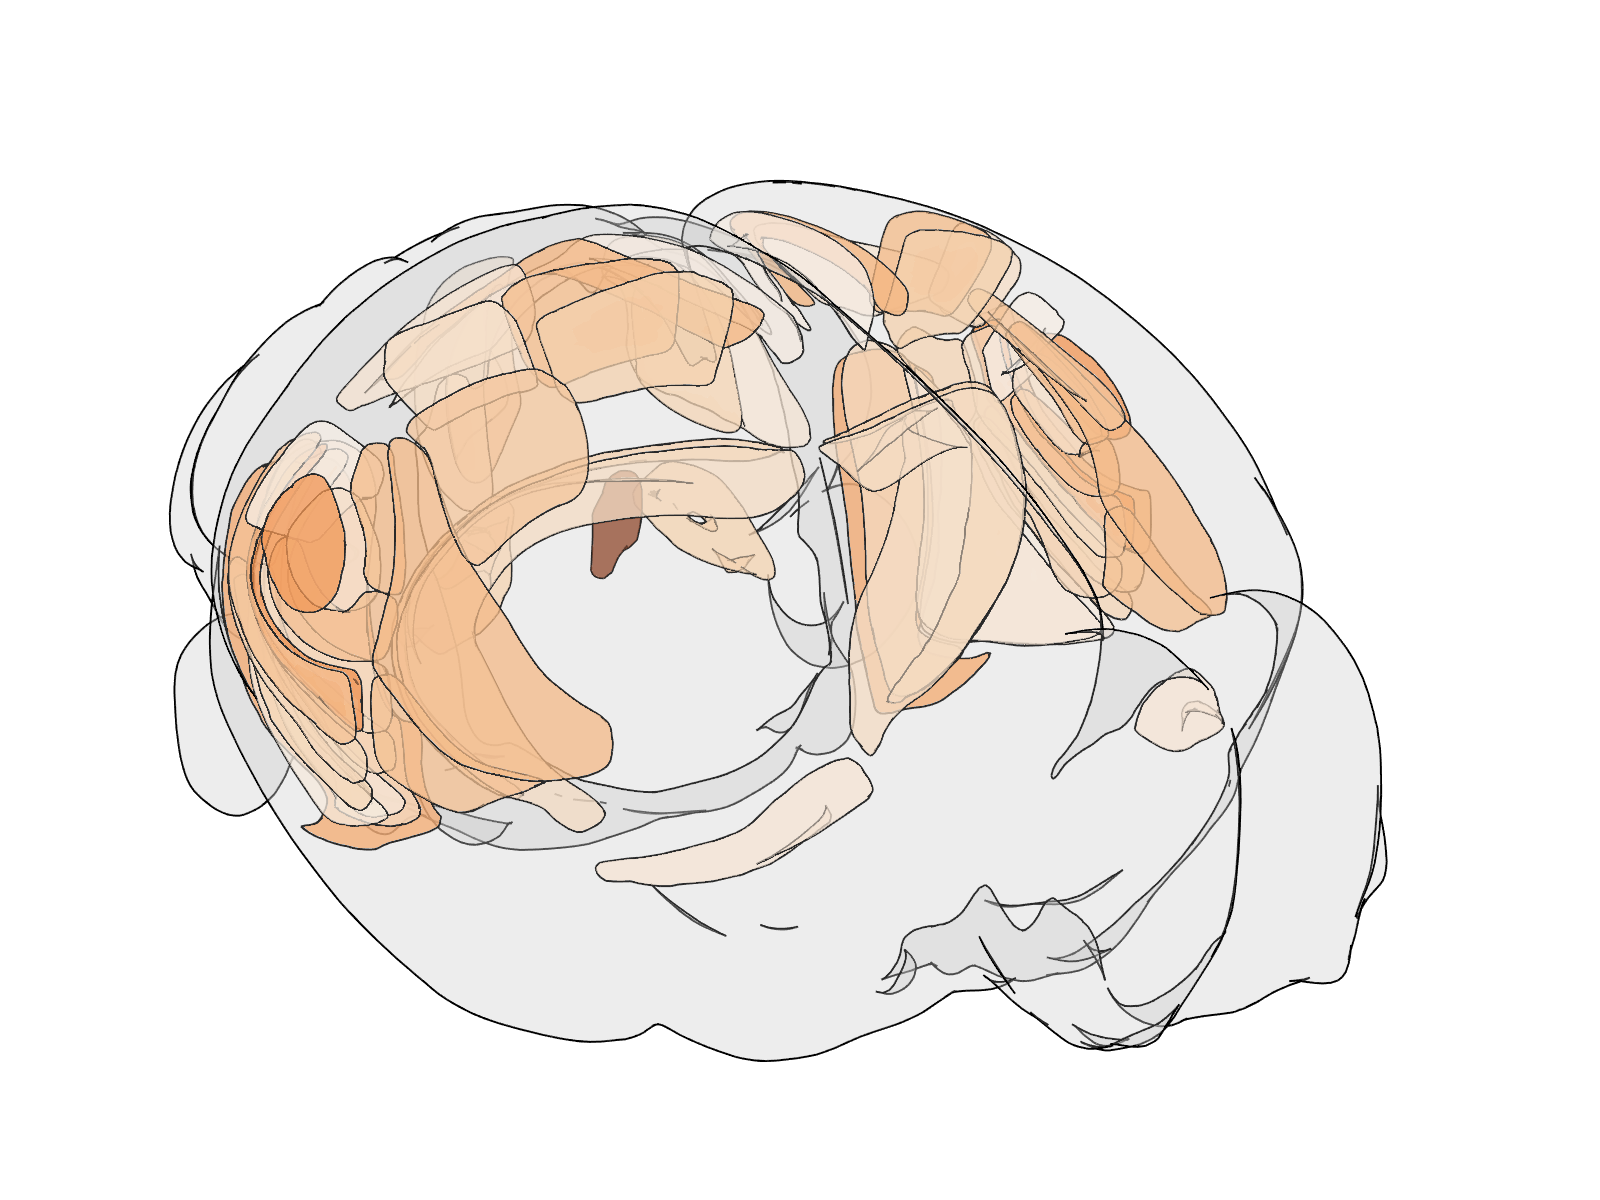

In [59]:
alpha = 0.5

# female
morphine_dfs_female = []
saline_dfs_female = []
for df_path in all_dfs:
    df_path_dict = density_dfs[df_path]
    density_df = df_path_dict["df"]
    treatment = df_path_dict['treatment']
    sex = df_path_dict['sex']
    if treatment == "morphine" and sex == 'f':
        morphine_dfs_female.append(density_df)
    elif treatment == "saline" and sex == 'f':
        saline_dfs_female.append(density_df)
    else:
        pass

morphine_dfs_female = pd.concat(morphine_dfs_female)
assert morphine_dfs_female.shape[0] == 840 * 6

saline_dfs_female = pd.concat(saline_dfs_female)
assert saline_dfs_female.shape[0] == 840 * 6

morphine_dfs_female.sort_values(by='Structure', inplace=True)
saline_dfs_female.sort_values(by='Structure', inplace=True)

morphine_dfs_female.reset_index(drop=True, inplace=True)
saline_dfs_female.reset_index(drop=True, inplace=True)

morphine_female_average_density_df = morphine_dfs_female.groupby('Structure')['density'].mean().reset_index()
saline_female_average_density_df = saline_dfs_female.groupby('Structure')['density'].mean().reset_index()

morphine_female_average_density_df['acronym'] = list(
    map(get_acronym, morphine_female_average_density_df['Structure'].to_list()))
saline_female_average_density_df['acronym'] = list(
    map(get_acronym, saline_female_average_density_df['Structure'].to_list()))

morphine_average_cell_count_df_female = morphine_dfs_female.groupby('Structure')['cell_count'].mean().reset_index()
saline_average_cell_count_df_female = saline_dfs_female.groupby('Structure')['cell_count'].mean().reset_index()
morphine_average_cell_count_df_female['acronym'] = list(
    map(get_acronym, morphine_average_cell_count_df_female['Structure'].to_list()))
saline_average_cell_count_df_female['acronym'] = list(
    map(get_acronym, saline_average_cell_count_df_female['Structure'].to_list()))

merged_df_female = pd.merge(morphine_female_average_density_df, saline_female_average_density_df, on='Structure',
                            suffixes=('_morphine', '_saline'))

merged_df_female = merged_df_female[
    merged_df_female['density_morphine'] > 0]
merged_df_female = merged_df_female[
    merged_df_female['density_saline'] > 0]

merged_df_female['density_ratio'] = merged_df_female['density_morphine'] / merged_df_female['density_saline']

density_ratio_df_female = merged_df_female[['Structure', 'density_ratio']]

p_values = []
significance = []
for structure in density_ratio_df_female['Structure'].to_list():
    morphine_dataset_f = morphine_dfs_female[morphine_dfs_female['Structure'] == structure]['density'].to_list()
    assert len(morphine_dataset_f) == 6
    saline_dataset_f = saline_dfs_female[saline_dfs_female['Structure'] == structure]['density'].to_list()
    assert len(saline_dataset_f) == 6
    p_val = get_p_value(morphine_dataset_f, saline_dataset_f)
    signif = p_val <= significance_threshold
    p_values.append(p_val)
    significance.append(signif)

density_ratio_df_female['p_value'] = p_values
density_ratio_df_female['significant'] = significance
density_ratio_df_female['acronym'] = list(map(get_acronym, density_ratio_df_female['Structure'].to_list()))
density_ratio_df_female['log_density_ratio'] = np.log2(density_ratio_df_female['density_ratio'].to_numpy())


significant_structures_female = density_ratio_df_female[density_ratio_df_female['significant'] == True][
    'acronym'].to_list()

filtered_significant_structures_female = [
    x for x in significant_structures_female if
    is_large_enough(x)
    and is_grey(x)
    and both_above_threshold(structure_from_acronym(x), morphine_average_cell_count_df_female, saline_average_cell_count_df_female)
]

filtered_significant_structures_female.append("DR")  # too small but significant everywhere

filtered_significant_structures_no_parents_female = exclude_parents(filtered_significant_structures_female)
print("Structures with significant difference:", len(filtered_significant_structures_no_parents_female))

density_ratio_df_female_significant = density_ratio_df_female[density_ratio_df_female['acronym'].isin(filtered_significant_structures_no_parents_female)]

scale_max = np.max(np.abs(density_ratio_df_female_significant['log_density_ratio'].to_numpy()))
scale_min = np.min(np.abs(density_ratio_df_female_significant['log_density_ratio'].to_numpy()))
print("Min", scale_min, "Max", scale_max)

scene = CustomScene(inset=False)

for i, row in density_ratio_df_female_significant.iterrows():
    region = row['acronym']
    log_density_ratio = row['log_density_ratio']
#     print("region", region, "log ratio", log_density_ratio)
    scene.add_brain_region(
        region,
        alpha=alpha,
        color=map_color(log_density_ratio, vmin=scale_min, vmax=scale_max,
                        name="Oranges")
    )
scene.render(interactive=False)
scene.screenshot(name=f"significant_structures_female_M_vs_S")

screenshot_path = "significant_structures_female_M_vs_S.png"

# Display the saved screenshot
display(Image(filename=screenshot_path))

In [60]:
end_time = datetime.now()
print("The whole notebook took", end_time - start_time)

The whole notebook took 0:03:50.500750
